# Data Leakage 문제 존재하면 shuffle 시켜도 나중에 Case랑 Date별로 다시 정렬시켜주는 코드 쓰면 됨

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 21.9 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=e96b44f27ef6f51232814b8546646f70e1b9ebf44885b88fcb5059334ea38efc
  Stored in directory: /root/.cache/pip/wheels/fe/f6/cb/40331472edf4fd399b8cad02973c6acbdf26898342928327fe
Successfully built filterpy


In [4]:
import random
import pandas as pd
import numpy as np
import os
import glob
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from tqdm import tqdm

In [290]:
def preprocessing(input_path):
  all_input_list = sorted(glob.glob(input_path))
  train = pd.DataFrame()
  for datapath in all_input_list:
    data = pd.read_csv(datapath) # 이게 지금 28일치 * 24시
    data['obs_time'] = data.index % 24 # 시간통일
    print(data)
    data = abs(data)
    col_list = data.columns
    for i in range(0,len(col_list)):
      col = col_list[i]    
      if '누적' in col :
        data[col] = data.groupby((data.obs_time == 0).cumsum()).agg(col_list[i-1]).cumsum()
    data.to_csv(datapath,index=False)
    train = pd.concat([train,data])
  return train
input_path_train = '/content/drive/MyDrive/상추/original_data/train_input/*.csv'
input_path_test = '/content/drive/MyDrive/상추/original_data/test_input/*.csv'

preprocessing(input_path_train)
preprocessing(input_path_test)

     DAT  obs_time    내부온도관측치    내부습도관측치      co2관측치     ec관측치  시간당분무량  \
0      0         0  25.300000  81.835000  536.016667  1.407439     0.0   
1      0         1  25.680357  81.264286  528.696429  1.409003   126.0   
2      0         2  25.273333  81.471666  532.833333  1.406913     0.0   
3      0         3  25.355000  81.398334  545.566667  1.406689   126.0   
4      0         4  25.391667  81.483333  558.583333  1.411070     0.0   
..   ...       ...        ...        ...         ...       ...     ...   
667   27        19  30.880000  82.255000  464.433333  0.000000   252.0   
668   27        20  29.068333  82.506667  534.633333  0.000000   126.0   
669   27        21  28.246667  82.835000  563.433333  0.000000     0.0   
670   27        22  28.005000  82.850000  577.150000  0.000000   126.0   
671   27        23  27.868333  82.453333  588.616667  0.000000     0.0   

     일간누적분무량   시간당백색광량   일간누적백색광량  시간당적색광량   일간누적적색광량  시간당청색광량  일간누적청색광량  \
0       0.00      0.00       0.00  

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,24.478333,59.196667,442.383333,0.916185,0.00,2594.56,6.1882,146712.9397,0.0,22242.1668,0.0,10457.954,6.1882,179413.0605
668,27,20,24.636667,58.330000,439.733333,0.916925,80.99,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
669,27,21,24.103333,57.768333,434.516667,0.916777,0.00,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
670,27,22,23.888333,57.255000,427.633333,0.918006,126.00,2801.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605


In [291]:
train_input_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/train_input/*.csv'))
train_target_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/train_target/*.csv'))

test_input_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/test_input/*.csv'))
test_target_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/test_target/*.csv'))
def make_dataset(all_input_list, all_target_list):
    df_all = pd.DataFrame()
    length = len(all_input_list)
    for idx in range(length):
        X = pd.read_csv(all_input_list[idx])
        y = pd.read_csv(all_target_list[idx])
        y['DAT'] = y['DAT']-1
        df_concat = pd.merge(X, y, on='DAT', how='left')
        df_concat['Case'] = idx+1
        df_all = pd.concat([df_all, df_concat])
    return df_all

train = make_dataset(train_input_list, train_target_list)
test = make_dataset(test_input_list, test_target_list)

In [292]:
train

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량,predicted_weight_g,Case
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259,86.591508,28
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28


In [293]:
train['내부온도관측치'][train['내부온도관측치'] == 0] = train['내부온도관측치'].mean()

<ipython-input-293-a3a709d65087>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['내부온도관측치'][train['내부온도관측치'] == 0] = train['내부온도관측치'].mean()


In [294]:
train['내부습도관측치'][train['내부습도관측치'] == 0] = train['내부습도관측치'].mean()
train['내부습도관측치'][train['내부습도관측치'] == 0]

<ipython-input-294-e5bc6e872e71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['내부습도관측치'][train['내부습도관측치'] == 0] = train['내부습도관측치'].mean()


Series([], Name: 내부습도관측치, dtype: float64)

In [295]:
train['05시내부온도관측치누적'] = 0
train['19시내부온도관측치누적'] = 0
train['23시내부온도관측치누적'] = 0

train['05시내부습도관측치누적'] = 0
train['19시내부습도관측치누적'] = 0
train['23시내부습도관측치누적'] = 0

train['05시co2관측치누적'] = 0
train['19시co2관측치누적'] = 0
train['23시co2관측치누적'] = 0

train['05시ec관측치누적'] = 0
train['19시ec관측치누적'] = 0
train['23시ec관측치누적'] = 0

train['05시분무량누적'] = 0
train['19시분무량누적'] = 0
train['23시분무량누적'] = 0

train['05시백색광누적'] = 0
train['19시백색광누적'] = 0
train['23시백색광누적'] = 0

train['05시적색광누적'] = 0
train['19시적색광누적'] = 0
train['23시적색광누적'] = 0

train['05시청색광누적'] = 0
train['19시청색광누적'] = 0
train['23시청색광누적'] = 0

train['05시총광량누적'] = 0
train['19시총광량누적'] = 0
train['23시총광량누적'] = 0



test['05시내부온도관측치누적'] = 0
test['19시내부온도관측치누적'] = 0
test['23시내부온도관측치누적'] = 0

test['05시내부습도관측치누적'] = 0
test['19시내부습도관측치누적'] = 0
test['23시내부습도관측치누적'] = 0

test['05시co2관측치누적'] = 0
test['19시co2관측치누적'] = 0
test['23시co2관측치누적'] = 0

test['05시ec관측치누적'] = 0
test['19시ec관측치누적'] = 0
test['23시ec관측치누적'] = 0

test['05시분무량누적'] = 0
test['19시분무량누적'] = 0
test['23시분무량누적'] = 0

test['05시백색광누적'] = 0
test['19시백색광누적'] = 0
test['23시백색광누적'] = 0

test['05시적색광누적'] = 0
test['19시적색광누적'] = 0
test['23시적색광누적'] = 0

test['05시청색광누적'] = 0
test['19시청색광누적'] = 0
test['23시청색광누적'] = 0

test['05시총광량누적'] = 0
test['19시총광량누적'] = 0
test['23시총광량누적'] = 0

train

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,...,0,0,0,0,0,0,0,0,0,0
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0


In [296]:
train = train.drop(train.filter(regex='일간누적').columns, axis=1)
test = test.drop(test.filter(regex='일간누적').columns, axis=1)
train #관측치에 칼만필터 씌워볼까?

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [297]:
train_new = train
test_new = test

In [298]:
train['시간대'] = 0
train['시간대'][(train['obs_time'] >= 0) & (train['obs_time'] <= 5)] = 1
train['시간대'][(train['obs_time'] > 5) & (train['obs_time'] < 20)] = 2
train['시간대'][(train['obs_time'] >= 20) & (train['obs_time'] <= 23)] = 3

test['시간대'] = 0
test['시간대'][(test['obs_time'] >= 0) & (test['obs_time'] <= 5)] = 1
test['시간대'][(test['obs_time'] > 5) & (test['obs_time'] < 20)] = 2
test['시간대'][(test['obs_time'] >= 20) & (test['obs_time'] <= 23)] = 3

test

<ipython-input-298-cb022eb2c26f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] >= 0) & (train['obs_time'] <= 5)] = 1
<ipython-input-298-cb022eb2c26f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] > 5) & (train['obs_time'] < 20)] = 2
<ipython-input-298-cb022eb2c26f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] >= 20) & (train['obs_t

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,24.478333,59.196667,442.383333,0.916185,0.00,6.1882,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
668,27,20,24.636667,58.330000,439.733333,0.916925,80.99,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
669,27,21,24.103333,57.768333,434.516667,0.916777,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
670,27,22,23.888333,57.255000,427.633333,0.918006,126.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3


In [299]:
train

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3


In [300]:

train['측정될수분량2'] = 0
for i in range(22,3361,24):
  s = train.iloc[i,6] + train.iloc[i+1,6] * ((train.iloc[i, 3] + train.iloc[i+1,3]) / 2)
  train.iloc[i, 41] = s


test['측정될수분량2'] = 0
for i in range(22,3361,24):
  s = test.iloc[i,6] + test.iloc[i+1,6] * ((test.iloc[i, 3] + test.iloc[i+1,3]) / 2)
  test.iloc[i, 41] = s
test


train['측정될수분량1'] = 0
for i in range(22,3361,24):
  s = train.iloc[i+1,6] * (train.iloc[i+1,3])
  train.iloc[i, 42] = s


test['측정될수분량1'] = 0
for i in range(22,3361,24):
  s = test.iloc[i+1,6] * (test.iloc[i+1,3])
  test.iloc[i, 42] = s
test



train['측정될수분량3'] = 0
for i in range(22,3361,24):
  s = (train.iloc[i,6] + train.iloc[i+1,6]) * ((train.iloc[i, 3] + train.iloc[i+1,3]) / 2)
  train.iloc[i, 43] = s


test['측정될수분량3'] = 0
for i in range(22,3361,24):
  s = (test.iloc[i,6] + test.iloc[i+1,6]) * ((test.iloc[i, 3] + test.iloc[i+1,3]) / 2)
  test.iloc[i, 43] = s
test

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대,측정될수분량2,측정될수분량1,측정될수분량3
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,24.478333,59.196667,442.383333,0.916185,0.00,6.1882,0.0,0.0,...,0,0,0,0,0,0,2,0.0,0.0,0.000000
668,27,20,24.636667,58.330000,439.733333,0.916925,80.99,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.000000
669,27,21,24.103333,57.768333,434.516667,0.916777,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.000000
670,27,22,23.888333,57.255000,427.633333,0.918006,126.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,126.0,0.0,7233.764995


In [301]:
train_x = train.drop(['predicted_weight_g'], axis = 1)
train_y = train['predicted_weight_g']
test_x = test.drop(['predicted_weight_g'], axis=1)

In [302]:
train_x = train_x.groupby(['DAT','Case','시간대']).sum().reset_index()
train_y_ready = train.groupby(['DAT','Case','시간대']).mean().reset_index()
test_x = test_x.groupby(['DAT','Case','시간대']).sum().reset_index()

In [303]:
train_x = train_x.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
train_y_ready = train_y_ready.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
test_x = test_x.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
train_x.drop(['index'], axis = 1, inplace=True)
test_x.drop(['index'], axis = 1, inplace=True)

In [304]:
x = train_x.groupby(['Case'])['내부온도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x.drop(['level_1'], axis = 1, inplace = True)
train_x['내부온도관측치'] = x

x2 = train_x.groupby(['Case'])['내부습도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x2.drop(['level_1'], axis = 1, inplace = True)
train_x['내부습도관측치'] = x2

x3 = train_x.groupby(['Case'])['co2관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x3.drop(['level_1'], axis = 1, inplace = True)
train_x['co2관측치'] = x3

x4 = train_x.groupby(['Case'])['ec관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x4.drop(['level_1'], axis = 1, inplace = True)
train_x['ec관측치'] = x4

x5 = train_x.groupby(['Case'])['시간당분무량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x5.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당분무량'] = x5

x6 = train_x.groupby(['Case'])['시간당백색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x6.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당백색광량'] = x6

x7 = train_x.groupby(['Case'])['시간당적색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x7.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당적색광량'] = x7

x8 = train_x.groupby(['Case'])['시간당청색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x8.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당청색광량'] = x8

x9 = train_x.groupby(['Case'])['시간당총광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x9.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당총광량'] = x9



t = test_x.groupby(['Case'])['내부온도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t.drop(['level_1'], axis = 1, inplace = True)
test_x['내부온도관측치'] = t

t2 = test_x.groupby(['Case'])['내부습도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t2.drop(['level_1'], axis = 1, inplace = True)
test_x['내부습도관측치'] = t2

t3 = test_x.groupby(['Case'])['co2관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t3.drop(['level_1'], axis = 1, inplace = True)
test_x['co2관측치'] = t3

t4 = test_x.groupby(['Case'])['ec관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t4.drop(['level_1'], axis = 1, inplace = True)
test_x['ec관측치'] = t4

t5 = test_x.groupby(['Case'])['시간당분무량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t5.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당분무량'] = t5

t6 = test_x.groupby(['Case'])['시간당백색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t6.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당백색광량'] = t6

t7 = test_x.groupby(['Case'])['시간당적색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t7.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당적색광량'] = t7

t8 = test_x.groupby(['Case'])['시간당청색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t8.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당청색광량'] = t8

t9 = test_x.groupby(['Case'])['시간당총광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t9.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당총광량'] = t9
test_x

,DAT,Case,시간대,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,...,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,측정될수분량2,측정될수분량1,측정될수분량3
0,0,1,1,15,157.490197,360.230509,2828.300000,6.198982,2307.00,0.000000e+00,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
1,0,1,2,175,551.546862,1200.858842,9320.750000,20.733929,10708.13,2.094768e+05,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
2,0,1,3,86,659.753530,1472.930508,11177.350000,24.897336,12246.13,2.094768e+05,...,0,0,0,0,0,0,0,53287.214088,53776.170332,53287.214088
3,1,1,1,15,823.168133,1894.221383,13990.538136,31.151334,13784.13,2.094768e+05,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
4,1,1,2,175,1237.346465,2748.433049,20432.738136,45.598078,20692.27,4.189937e+05,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,26,5,2,175,18064.448119,34045.100123,298129.376915,138.152084,82523.29,4.830401e+06,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
416,26,5,3,86,18167.036452,34274.596790,300117.860248,141.815671,82649.29,4.830401e+06,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
417,27,5,1,15,18309.500067,34618.675321,302802.869570,147.366055,83027.29,4.830401e+06,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
418,27,5,2,175,18669.410066,35426.903655,308281.619570,160.379524,85243.85,4.977114e+06,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000


In [305]:
train_new_x = train_new.drop(['predicted_weight_g'], axis = 1)
train_new_y = train_new['predicted_weight_g']
test_new_x = test_new.drop(['predicted_weight_g'], axis=1)

In [306]:
train_new_x = train_new_x.groupby(['DAT','Case']).sum().reset_index()
train_new_y_ready = train_new.groupby(['DAT','Case']).mean().reset_index()
test_new_x = test_new_x.groupby(['DAT','Case']).sum().reset_index()

In [307]:
train_new_x = train_new_x.sort_values(by=['Case','DAT'], axis=0).reset_index()
train_new_y_ready = train_new_y_ready.sort_values(by=['Case','DAT',], axis=0).reset_index()
test_new_x = test_new_x.sort_values(by=['Case','DAT'], axis=0).reset_index()
train_new_x.drop(['index'], axis = 1, inplace=True)
test_new_x.drop(['index'], axis = 1, inplace=True)

In [308]:
for i in range(784):
  #온도
  train_new_x.iloc[i,12] = train_x.iloc[0 + (3*i),4]
  train_new_x.iloc[i,13] = train_x.iloc[1 + (3*i),4]
  train_new_x.iloc[i,14] = train_x.iloc[2 + (3*i),4]
  #습도
  train_new_x.iloc[i,15] = train_x.iloc[0 + (3*i),5]
  train_new_x.iloc[i,16] = train_x.iloc[1 + (3*i),5]
  train_new_x.iloc[i,17] = train_x.iloc[2 + (3*i),5]
  #co2
  train_new_x.iloc[i,18] = train_x.iloc[0 + (3*i),6]
  train_new_x.iloc[i,19] = train_x.iloc[1 + (3*i),6]
  train_new_x.iloc[i,20] = train_x.iloc[2 + (3*i),6]
  #ec
  train_new_x.iloc[i,21] = train_x.iloc[0 + (3*i),7]
  train_new_x.iloc[i,22] = train_x.iloc[1 + (3*i),7]
  train_new_x.iloc[i,23] = train_x.iloc[2 + (3*i),7]
  #분무
  train_new_x.iloc[i,24] = train_x.iloc[0 + (3*i),8]
  train_new_x.iloc[i,25] = train_x.iloc[1 + (3*i),8]
  train_new_x.iloc[i,26] = train_x.iloc[2 + (3*i),8]
  #백색
  train_new_x.iloc[i,27] = train_x.iloc[0 + (3*i),9]
  train_new_x.iloc[i,28] = train_x.iloc[1 + (3*i),9]
  train_new_x.iloc[i,29] = train_x.iloc[2 + (3*i),9]
  #적색
  train_new_x.iloc[i,30] = train_x.iloc[0 + (3*i),10]
  train_new_x.iloc[i,31] = train_x.iloc[1 + (3*i),10]
  train_new_x.iloc[i,32] = train_x.iloc[2 + (3*i),10]
  #청색
  train_new_x.iloc[i,33] = train_x.iloc[0 + (3*i),11]
  train_new_x.iloc[i,34] = train_x.iloc[1 + (3*i),11]
  train_new_x.iloc[i,35] = train_x.iloc[2 + (3*i),11]
  #총광
  train_new_x.iloc[i,36] = train_x.iloc[0 + (3*i),12]
  train_new_x.iloc[i,37] = train_x.iloc[1 + (3*i),12]
  train_new_x.iloc[i,38] = train_x.iloc[2 + (3*i),12]

for i in range(len(test_new_x)):
  #온도
  test_new_x.iloc[i,12] = test_x.iloc[0 + (3*i),4]
  test_new_x.iloc[i,13] = test_x.iloc[1 + (3*i),4]
  test_new_x.iloc[i,14] = test_x.iloc[2 + (3*i),4]
  #습도
  test_new_x.iloc[i,15] = test_x.iloc[0 + (3*i),5]
  test_new_x.iloc[i,16] = test_x.iloc[1 + (3*i),5]
  test_new_x.iloc[i,17] = test_x.iloc[2 + (3*i),5]
  #co2
  test_new_x.iloc[i,18] = test_x.iloc[0 + (3*i),6]
  test_new_x.iloc[i,19] = test_x.iloc[1 + (3*i),6]
  test_new_x.iloc[i,20] = test_x.iloc[2 + (3*i),6]
  #ec
  test_new_x.iloc[i,21] = test_x.iloc[0 + (3*i),7]
  test_new_x.iloc[i,22] = test_x.iloc[1 + (3*i),7]
  test_new_x.iloc[i,23] = test_x.iloc[2 + (3*i),7]
  #분무
  test_new_x.iloc[i,24] = test_x.iloc[0 + (3*i),8]
  test_new_x.iloc[i,25] = test_x.iloc[1 + (3*i),8]
  test_new_x.iloc[i,26] = test_x.iloc[2 + (3*i),8]
  #백색
  test_new_x.iloc[i,27] = test_x.iloc[0 + (3*i),9]
  test_new_x.iloc[i,28] = test_x.iloc[1 + (3*i),9]
  test_new_x.iloc[i,29] = test_x.iloc[2 + (3*i),9]
  #적색
  test_new_x.iloc[i,30] = test_x.iloc[0 + (3*i),10]
  test_new_x.iloc[i,31] = test_x.iloc[1 + (3*i),10]
  test_new_x.iloc[i,32] = test_x.iloc[2 + (3*i),10]
  #청색
  test_new_x.iloc[i,33] = test_x.iloc[0 + (3*i),11]
  test_new_x.iloc[i,34] = test_x.iloc[1 + (3*i),11]
  test_new_x.iloc[i,35] = test_x.iloc[2 + (3*i),11]
  #총광
  test_new_x.iloc[i,36] = test_x.iloc[0 + (3*i),12]
  test_new_x.iloc[i,37] = test_x.iloc[1 + (3*i),12]
  test_new_x.iloc[i,38] = test_x.iloc[2 + (3*i),12]
test_new_x

,DAT,Case,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,...,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대,측정될수분량2,측정될수분량1,측정될수분량3
0,0,1,276,659.753530,1472.930508,11177.350000,24.897336,12246.13,209476.7582,0.0000,...,0.000,0.000,0.000,0.000000e+00,2.094768e+05,2.094768e+05,46,53287.214088,53776.170332,53287.214088
1,1,1,276,688.051268,1515.552541,11127.871469,24.828015,9215.14,209516.9815,0.0000,...,0.000,0.000,0.000,2.094768e+05,4.189937e+05,4.189937e+05,46,769.000000,0.000000,46255.350024
2,2,1,276,681.777709,1465.085341,11733.194068,24.794710,11911.77,209625.2750,0.0000,...,0.000,0.000,0.000,4.189937e+05,6.286190e+05,6.286190e+05,46,389.630000,0.000000,24671.696329
3,3,1,276,675.930000,1544.551663,11865.466667,24.811042,12297.57,209588.1458,0.0000,...,0.000,0.000,0.000,6.286190e+05,8.382072e+05,8.382072e+05,46,53630.059726,53435.246823,53630.059726
4,4,1,276,655.253275,1603.898332,12680.383333,24.931104,8874.35,209628.3691,0.0000,...,0.000,0.000,0.000,8.382072e+05,1.047836e+06,1.047836e+06,46,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,276,621.237343,1360.970960,11056.883333,5.876635,3198.84,146685.0928,22270.2984,...,87742.798,98213.284,98213.284,4.518548e+06,4.697974e+06,4.697974e+06,46,119.570000,0.000000,6792.871341
136,24,5,276,610.544249,1367.500518,10527.803448,21.898880,3250.28,146233.3542,22192.5228,...,98213.284,108649.307,108649.307,4.697974e+06,4.876835e+06,4.876835e+06,46,7218.014999,7205.309989,7218.014999
137,25,5,276,600.999883,1375.736610,10654.514124,21.982178,2733.42,146647.9636,22248.7860,...,108649.307,119110.394,119110.394,4.876835e+06,5.056193e+06,5.056193e+06,46,7191.450008,7126.139987,7191.450008
138,26,5,276,614.828333,1369.153332,10744.616667,22.039573,2985.42,146579.8934,22253.7504,...,119110.394,129568.348,129568.348,5.056193e+06,5.235485e+06,5.235485e+06,46,0.000000,0.000000,0.000000


In [309]:
train_new_y = train_new_y_ready['predicted_weight_g']
train_new_y

0       0.167719
1       0.181787
2       0.265921
3       0.423650
4       0.475272
         ...    
779    64.875499
780    74.002614
781    76.342275
782    82.621245
783    86.591508
Name: predicted_weight_g, Length: 784, dtype: float64

In [310]:
train_new_x.drop(['obs_time','시간대','내부온도관측치','내부습도관측치','co2관측치','ec관측치'], axis = 1, inplace = True)
test_new_x.drop(['obs_time','시간대','내부온도관측치','내부습도관측치','co2관측치','ec관측치'], axis = 1, inplace = True)

In [311]:
train_x = train_new_x
train_y = train_new_y
test_x = test_new_x

In [312]:
train_x = train_x.drop(train_x.filter(regex='시간당').columns, axis=1)
test_x = test_x.drop(test_x.filter(regex='시간당').columns, axis=1)


In [313]:
check = pd.concat([train_x,train_y],axis=1)
z = check[(check['DAT'] == 0) | (check['DAT'] == 27)]
for idx,i in enumerate(z.columns):
  if((i == 'DAT') | (i == 'predicted_weight_g') | (i == 'Case')):
    continue
  z.drop([i],axis=1,inplace = True)
z

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,DAT,Case,predicted_weight_g
0,0,1,0.167719
27,27,1,82.251627
28,0,2,1.051178
55,27,2,65.505384
56,0,3,0.685391
83,27,3,44.324891
84,0,4,1.656917
111,27,4,128.563772
112,0,5,4.223077
139,27,5,150.635598


In [314]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           784 non-null    int64  
 1   Case          784 non-null    int64  
 2   05시내부온도관측치누적  784 non-null    float64
 3   19시내부온도관측치누적  784 non-null    float64
 4   23시내부온도관측치누적  784 non-null    float64
 5   05시내부습도관측치누적  784 non-null    float64
 6   19시내부습도관측치누적  784 non-null    float64
 7   23시내부습도관측치누적  784 non-null    float64
 8   05시co2관측치누적   784 non-null    float64
 9   19시co2관측치누적   784 non-null    float64
 10  23시co2관측치누적   784 non-null    float64
 11  05시ec관측치누적    784 non-null    float64
 12  19시ec관측치누적    784 non-null    float64
 13  23시ec관측치누적    784 non-null    float64
 14  05시분무량누적      784 non-null    float64
 15  19시분무량누적      784 non-null    float64
 16  23시분무량누적      784 non-null    float64
 17  05시백색광누적      784 non-null    float64
 18  19시백색광누적      784 non-null    

In [315]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           140 non-null    int64  
 1   Case          140 non-null    int64  
 2   05시내부온도관측치누적  140 non-null    float64
 3   19시내부온도관측치누적  140 non-null    float64
 4   23시내부온도관측치누적  140 non-null    float64
 5   05시내부습도관측치누적  140 non-null    float64
 6   19시내부습도관측치누적  140 non-null    float64
 7   23시내부습도관측치누적  140 non-null    float64
 8   05시co2관측치누적   140 non-null    float64
 9   19시co2관측치누적   140 non-null    float64
 10  23시co2관측치누적   140 non-null    float64
 11  05시ec관측치누적    140 non-null    float64
 12  19시ec관측치누적    140 non-null    float64
 13  23시ec관측치누적    140 non-null    float64
 14  05시분무량누적      140 non-null    float64
 15  19시분무량누적      140 non-null    float64
 16  23시분무량누적      140 non-null    float64
 17  05시백색광누적      140 non-null    float64
 18  19시백색광누적      140 non-null    

In [316]:
train_x['하루평균온도'] = (train_x['05시내부온도관측치누적'] + train_x['19시내부온도관측치누적'] + train_x['23시내부온도관측치누적']) / 3
train_x['하루평균습도'] = (train_x['05시내부습도관측치누적'] + train_x['19시내부습도관측치누적'] + train_x['23시내부습도관측치누적']) / 3
train_x['하루평균co2'] = (train_x['05시co2관측치누적'] + train_x['19시co2관측치누적'] + train_x['23시co2관측치누적']) / 3
train_x['하루평균ec'] = (train_x['05시ec관측치누적'] + train_x['19시ec관측치누적'] + train_x['23시ec관측치누적']) / 3
train_x['하루평균분무량'] = (train_x['05시분무량누적'] + train_x['19시분무량누적'] + train_x['23시분무량누적']) / 3
train_x['하루평균백색광'] = (train_x['05시백색광누적'] + train_x['19시백색광누적'] + train_x['23시백색광누적']) / 3
train_x['하루평균적색광'] = (train_x['05시적색광누적'] + train_x['19시적색광누적'] + train_x['23시적색광누적']) / 3
train_x['하루평균청색광'] = (train_x['05시청색광누적'] + train_x['19시청색광누적'] + train_x['23시청색광누적']) / 3
train_x['하루평균총광량'] = (train_x['05시총광량누적'] + train_x['19시총광량누적'] + train_x['23시총광량누적']) / 3


test_x['하루평균온도'] = (test_x['05시내부온도관측치누적'] + test_x['19시내부온도관측치누적'] + test_x['23시내부온도관측치누적']) / 3
test_x['하루평균습도'] = (test_x['05시내부습도관측치누적'] + test_x['19시내부습도관측치누적'] + test_x['23시내부습도관측치누적']) / 3
test_x['하루평균co2'] = (test_x['05시co2관측치누적'] + test_x['19시co2관측치누적'] + test_x['23시co2관측치누적']) / 3
test_x['하루평균ec'] = (test_x['05시ec관측치누적'] + test_x['19시ec관측치누적'] + test_x['23시ec관측치누적']) / 3
test_x['하루평균분무량'] = (test_x['05시분무량누적'] + test_x['19시분무량누적'] + test_x['23시분무량누적']) / 3
test_x['하루평균백색광'] = (test_x['05시백색광누적'] + test_x['19시백색광누적'] + test_x['23시백색광누적']) / 3
test_x['하루평균적색광'] = (test_x['05시적색광누적'] + test_x['19시적색광누적'] + test_x['23시적색광누적']) / 3
test_x['하루평균청색광'] = (test_x['05시청색광누적'] + test_x['19시청색광누적'] + test_x['23시청색광누적']) / 3
test_x['하루평균총광량'] = (test_x['05시총광량누적'] + test_x['19시총광량누적'] + test_x['23시총광량누적']) / 3
test_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,측정될수분량3,하루평균온도,하루평균습도,하루평균co2,하루평균ec,하루평균분무량,하루평균백색광,하루평균적색광,하루평균청색광,하루평균총광량
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,53287.214088,456.263530,1011.339953,7775.466667,17.276749,8420.420000,1.396512e+05,0.0000,0.000000,1.396512e+05
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,46255.350024,1136.106465,2543.712494,18909.499247,42.158254,18645.890000,3.491547e+05,0.0000,0.000000,3.491547e+05
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,24671.696329,1821.706952,4008.123946,30455.271092,66.944550,29785.240000,5.587439e+05,0.0000,0.000000,5.587439e+05
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,53630.059726,2498.107506,5523.282831,42255.565537,91.756953,41827.753333,7.683444e+05,0.0000,0.000000,7.683444e+05
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,0.000000,3160.903024,7113.847275,54720.137759,116.639399,52099.510000,9.779594e+05,0.0000,0.000000,9.779594e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,6792.871341,16148.948989,29746.767441,264713.876009,72.759171,72598.886667,4.342044e+06,201397.4340,94723.122000,4.638165e+06
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,7218.014999,16765.109349,31111.669626,275472.668346,91.090874,75847.023333,4.488428e+06,223615.8820,105170.632667,4.817215e+06
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,7191.450008,17367.649232,32483.939569,286040.176915,113.032090,78792.586667,4.634938e+06,245845.9136,115623.365000,4.996407e+06
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,0.000000,17975.257008,33856.157346,296786.510248,135.085656,81654.150000,4.781541e+06,268098.0092,126082.363333,5.175721e+06


In [317]:
train_x = train_x.drop(train_x.filter(regex = '총광').columns, axis =1)
test_x = test_x.drop(test_x.filter(regex = '총광').columns, axis =1)


train_x['ec_x_분무05'] = (train_x['05시ec관측치누적']+1) * (train_x['05시분무량누적']+1)
train_x['ec_x_분무19'] = (train_x['19시ec관측치누적']+1) * (train_x['19시분무량누적']+1)
train_x['ec_x_분무23'] = (train_x['23시ec관측치누적']+1) * (train_x['23시분무량누적']+1)
train_x['ec_x_분무평균'] = (train_x['하루평균ec']+1) * (train_x['하루평균분무량']+1)

test_x['ec_x_분무05'] = (test_x['05시ec관측치누적']+1) * (test_x['05시분무량누적']+1)
test_x['ec_x_분무19'] = (test_x['19시ec관측치누적']+1) * (test_x['19시분무량누적']+1)
test_x['ec_x_분무23'] = (test_x['23시ec관측치누적']+1) * (test_x['23시분무량누적']+1)
test_x['ec_x_분무평균'] = (test_x['하루평균ec']+1) * (test_x['하루평균분무량']+1)



train_x['적색_+_청색05'] = (train_x['05시적색광누적']) + (train_x['05시청색광누적'])
train_x['적색_+_청색19'] = (train_x['19시적색광누적']) + (train_x['19시청색광누적'])
train_x['적색_+_청색23'] = (train_x['23시적색광누적']) + (train_x['23시청색광누적'])
train_x['적색_+_청색평균'] = (train_x['하루평균적색광']) + (train_x['하루평균청색광'])

test_x['적색_+_청색05'] = (test_x['05시적색광누적']) + (test_x['05시청색광누적'])
test_x['적색_+_청색19'] = (test_x['19시적색광누적']) + (test_x['19시청색광누적'])
test_x['적색_+_청색23'] = (test_x['23시적색광누적']) + (test_x['23시청색광누적'])
test_x['적색_+_청색평균'] = (test_x['하루평균적색광']) + (test_x['하루평균청색광'])


In [318]:
#측정될 수분량 합
train_x['수분량합'] =  train_x['측정될수분량1'] + train_x['측정될수분량2'] + train_x['측정될수분량3']
test_x['수분량합'] =  test_x['측정될수분량1'] + test_x['측정될수분량2'] + test_x['측정될수분량3']

train_x['수분량합12'] =  train_x['측정될수분량1'] + train_x['측정될수분량2']
test_x['수분량합12'] =  test_x['측정될수분량1'] + test_x['측정될수분량2']

train_x['수분량합13'] =  train_x['측정될수분량1'] + train_x['측정될수분량3']
test_x['수분량합13'] =  test_x['측정될수분량1'] + test_x['측정될수분량3']

train_x['수분량합23'] = train_x['측정될수분량2'] + train_x['측정될수분량3']
test_x['수분량합23'] =  test_x['측정될수분량2'] + test_x['측정될수분량3']
'''
train_x['수분량평'] =  (train_x['측정될수분량1'] + train_x['측정될수분량2'] + train_x['측정될수분량3'])/3
test_x['수분량평'] =  (test_x['측정될수분량1'] + test_x['측정될수분량2'] + test_x['측정될수분량3'])/3
'''


"\ntrain_x['수분량평'] =  (train_x['측정될수분량1'] + train_x['측정될수분량2'] + train_x['측정될수분량3'])/3\ntest_x['수분량평'] =  (test_x['측정될수분량1'] + test_x['측정될수분량2'] + test_x['측정될수분량3'])/3\n"

In [319]:
# 일 x 일일누적
'''
dif_col = train_x.filter(regex='측정될').columns

day_list = [1.10758948200158, 1.78018128719155,2.05605431049513, 2.40488980907117,2.92986931159212, 3.63982448871592, 4.25751673658059, 5.01798785501286, 5.86414264005969,6.87944471563261,8.50614425836535, 10.4277930930136, 12.751160731087, 15.0790099550155, 18.0492122683902,21.0180764599857, 25.0937717755754, 29.2299496420804, 34.3501893350132, 40.2487714267103, 47.5265860246802,54.7355247863804, 62.3193252574661,70.7259227425427,79.0778722010111,  85.2917982740899,  92.8526075315711,  98.9439116521094 ]

for j in range(len(dif_col)):
  train_x['일일'+dif_col[j]] = 0
  for i in range(1,29):
    dif = train_x[train_x['Case'] == i]
    for k in range(len(dif)):
      #print(len(dif))
      #print(day_list[k])
      #print(train_x.loc[k+((i-1)*28),'일일'+dif_col[j]] )
      train_x.loc[k+((i-1)*28),'일일'+dif_col[j]] = train_x.loc[k+((i-1)*28),dif_col[j]] * day_list[k]

dif_col = test_x.filter(regex='측정될').columns

for j in range(len(dif_col)):
  test_x['일일'+dif_col[j]] = 0
  for i in range(1,29):
    dif = test_x[test_x['Case'] == i]
    for k in range(len(dif)):
      test_x.loc[k+((i-1)*28),'일일'+dif_col[j]] = test_x.loc[k+((i-1)*28),dif_col[j]] * day_list[k]


test_x'''

"\ndif_col = train_x.filter(regex='측정될').columns\n\nday_list = [1.10758948200158, 1.78018128719155,2.05605431049513, 2.40488980907117,2.92986931159212, 3.63982448871592, 4.25751673658059, 5.01798785501286, 5.86414264005969,6.87944471563261,8.50614425836535, 10.4277930930136, 12.751160731087, 15.0790099550155, 18.0492122683902,21.0180764599857, 25.0937717755754, 29.2299496420804, 34.3501893350132, 40.2487714267103, 47.5265860246802,54.7355247863804, 62.3193252574661,70.7259227425427,79.0778722010111,  85.2917982740899,  92.8526075315711,  98.9439116521094 ]\n\nfor j in range(len(dif_col)):\n  train_x['일일'+dif_col[j]] = 0\n  for i in range(1,29):\n    dif = train_x[train_x['Case'] == i]\n    for k in range(len(dif)):\n      #print(len(dif))\n      #print(day_list[k])\n      #print(train_x.loc[k+((i-1)*28),'일일'+dif_col[j]] )\n      train_x.loc[k+((i-1)*28),'일일'+dif_col[j]] = train_x.loc[k+((i-1)*28),dif_col[j]] * day_list[k]\n\ndif_col = test_x.filter(regex='측정될').columns\n\nfor j in rang

In [320]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           784 non-null    int64  
 1   Case          784 non-null    int64  
 2   05시내부온도관측치누적  784 non-null    float64
 3   19시내부온도관측치누적  784 non-null    float64
 4   23시내부온도관측치누적  784 non-null    float64
 5   05시내부습도관측치누적  784 non-null    float64
 6   19시내부습도관측치누적  784 non-null    float64
 7   23시내부습도관측치누적  784 non-null    float64
 8   05시co2관측치누적   784 non-null    float64
 9   19시co2관측치누적   784 non-null    float64
 10  23시co2관측치누적   784 non-null    float64
 11  05시ec관측치누적    784 non-null    float64
 12  19시ec관측치누적    784 non-null    float64
 13  23시ec관측치누적    784 non-null    float64
 14  05시분무량누적      784 non-null    float64
 15  19시분무량누적      784 non-null    float64
 16  23시분무량누적      784 non-null    float64
 17  05시백색광누적      784 non-null    float64
 18  19시백색광누적      784 non-null    

In [321]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           140 non-null    int64  
 1   Case          140 non-null    int64  
 2   05시내부온도관측치누적  140 non-null    float64
 3   19시내부온도관측치누적  140 non-null    float64
 4   23시내부온도관측치누적  140 non-null    float64
 5   05시내부습도관측치누적  140 non-null    float64
 6   19시내부습도관측치누적  140 non-null    float64
 7   23시내부습도관측치누적  140 non-null    float64
 8   05시co2관측치누적   140 non-null    float64
 9   19시co2관측치누적   140 non-null    float64
 10  23시co2관측치누적   140 non-null    float64
 11  05시ec관측치누적    140 non-null    float64
 12  19시ec관측치누적    140 non-null    float64
 13  23시ec관측치누적    140 non-null    float64
 14  05시분무량누적      140 non-null    float64
 15  19시분무량누적      140 non-null    float64
 16  23시분무량누적      140 non-null    float64
 17  05시백색광누적      140 non-null    float64
 18  19시백색광누적      140 non-null    

In [322]:
train_x.drop(train_x.filter(regex = '백색'), axis = 1, inplace=True)
test_x.drop(test_x.filter(regex = '백색'), axis = 1, inplace=True)

train_x.drop(train_x.filter(regex = '청색'), axis = 1, inplace=True)
test_x.drop(test_x.filter(regex = '청색'), axis = 1, inplace=True)

train_x.drop(['측정될수분량2','측정될수분량1','측정될수분량3'],axis=1,inplace=True)
test_x.drop(['측정될수분량2','측정될수분량1','측정될수분량3'],axis=1,inplace=True)

In [323]:
train_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,하루평균분무량,하루평균적색광,ec_x_분무05,ec_x_분무19,ec_x_분무23,ec_x_분무평균,수분량합,수분량합12,수분량합13,수분량합23
0,0,1,152.375357,543.497022,648.737022,488.959286,1548.437616,1873.470950,3273.179762,10802.813095,...,2682.846667,9116.8448,3.521074e+03,1.074594e+05,1.364875e+05,6.513707e+04,10439.835069,126.000000,10313.835069,10439.835069
1,1,1,802.423055,1203.154720,1309.763053,2363.573595,3423.836927,3747.271928,16105.807923,23392.424589,...,6659.120000,22818.5888,1.858032e+05,4.784304e+05,5.375161e+05,3.832637e+05,9849.778061,119.570000,9730.208061,9849.778061
2,2,1,1465.109946,1846.319946,1950.046613,4235.789751,5287.029753,5609.433087,28612.826002,36268.142669,...,10712.963333,36507.0944,6.320298e+05,1.126382e+06,1.216881e+06,9.737012e+05,30652.860045,20441.190027,20441.190027,20423.340035
3,3,1,2102.321331,2476.117657,2577.822656,6094.882606,7142.959272,7466.219273,41656.083912,53215.550578,...,14733.380000,50202.2192,1.359387e+06,2.036533e+06,2.157985e+06,1.833728e+06,9849.080633,119.570000,9729.510633,9849.080633
4,4,1,2730.360368,3112.468700,3214.372034,7955.275545,9016.890547,9341.378879,59940.042104,67442.975437,...,18641.933333,63895.1376,2.328741e+06,3.209621e+06,3.360449e+06,2.948257e+06,29331.716423,19569.822423,19569.822423,19523.787999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,23,28,16924.798611,17314.583610,17410.510277,32531.546176,33353.864510,33585.191177,274662.719060,280926.952393,...,357467.726667,108869.8436,1.970806e+08,2.132453e+08,2.150474e+08,2.083829e+08,0.000000,0.000000,0.000000,0.000000
780,24,28,17552.605851,17919.984185,18016.789185,33938.389108,34789.454108,35024.420775,285424.226531,291661.038678,...,365772.813333,128048.4240,2.178648e+08,2.255612e+08,2.274649e+08,2.236183e+08,0.000000,0.000000,0.000000,0.000000
781,25,28,18161.116713,18518.971712,18614.863378,35378.022844,36231.462844,36470.189510,296363.720287,302643.803620,...,368854.636667,150374.9856,2.303067e+08,2.379806e+08,2.398952e+08,2.360499e+08,0.000000,0.000000,0.000000,0.000000
782,26,28,18758.823379,19115.493377,19226.358377,36825.764510,37675.707843,37913.426176,307403.486954,313160.003620,...,371617.196667,172659.6256,2.427676e+08,2.501907e+08,2.520665e+08,2.483326e+08,0.000000,0.000000,0.000000,0.000000


In [324]:
test_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,하루평균분무량,하루평균적색광,ec_x_분무05,ec_x_분무19,ec_x_분무23,ec_x_분무평균,수분량합,수분량합12,수분량합13,수분량합23
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,8420.420000,0.0000,1.661525e+04,2.327515e+05,3.171680e+05,1.539162e+05,160350.598509,107063.384421,107063.384421,106574.428177
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,18645.890000,0.0000,4.432103e+05,9.642666e+05,1.088681e+06,8.047672e+05,47024.350024,769.000000,46255.350024,47024.350024
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,29785.240000,0.0000,1.353080e+06,2.299793e+06,2.520410e+06,2.023813e+06,25061.326329,389.630000,24671.696329,25061.326329
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,41827.753333,0.0000,2.916614e+06,4.245585e+06,4.582283e+06,3.879908e+06,160695.366276,107065.306549,107065.306549,107260.119452
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,52099.510000,0.0000,5.111651e+06,6.513238e+06,6.832547e+06,6.129073e+06,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,72598.886667,201397.4340,5.019786e+06,5.387534e+06,5.665717e+06,5.354907e+06,6912.441341,119.570000,6792.871341,6912.441341
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,75847.023333,223615.8820,6.085622e+06,7.297294e+06,7.600360e+06,6.984911e+06,21641.339987,14423.324988,14423.324988,14436.029998
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,78792.586667,245845.9136,8.043660e+06,9.313736e+06,9.621612e+06,8.984997e+06,21509.040003,14317.589995,14317.589995,14382.900016
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,81654.150000,268098.0092,1.007673e+07,1.148343e+07,1.180376e+07,1.111209e+07,0.000000,0.000000,0.000000,0.000000


In [325]:
basic_col = train_x.columns
kal_train = train_x

for i in range(2,34):
  train_x['kf_X_'+str(i)]=0

for j in range(1,29):
  kal = train_x[train_x['Case'] == j]
  for i in tqdm(range(len(basic_col))):
      if((i == 0) | (i == 1)):
        continue
      current=0
      sum_c=[]
      z = kal.loc[:, kal.columns[i]]
      a = []           #필터링 된 피쳐(after)
      b = []           #필터링 전 피쳐(before)
      my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
      my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
      my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
      my_filter.H = np.array([[1.,0.]])    # Measurement function
      my_filter.P *= 1000.                 # covariance matrix
      my_filter.R = 5                      # state uncertainty
      my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.5) # process uncertainty   
      for k in z.values:
          my_filter.predict()
          my_filter.update(k)
          # do something with the output
          x = my_filter.x
          a.extend(x[0])
          b.append(k)
      sum_c=sum_c+a
      #train_x.loc[(j+0)*24:(j+1)*24+1,'kf_X_'+str(i)]=sum_c
      print(sum_c)
      train_x['kf_X_'+str(i)][train_x['Case'] == j] = sum_c

train_x

basic_col = test_x.columns
kal_test = test_x

for i in range(2,34):
  test_x['kf_X_'+str(i)]=0

for j in range(1,6): #수정 Data_Leakage
  kal = test_x[test_x['Case'] == j]
  for i in tqdm(range(len(basic_col))):
      if((i == 0) | (i == 1)):
        continue
      current=0
      sum_c=[]
      z = kal.loc[:, kal.columns[i]]
      a = []           #필터링 된 피쳐(after)
      b = []           #필터링 전 피쳐(before)
      my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
      my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
      my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
      my_filter.H = np.array([[1.,0.]])    # Measurement function
      my_filter.P *= 1000.                 # covariance matrix
      my_filter.R = 5                      # state uncertainty
      my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.5) # process uncertainty   
      for k in z.values:
          my_filter.predict()
          my_filter.update(k)
          # do something with the output
          x = my_filter.x
          a.extend(x[0])
          b.append(k)
      sum_c=sum_c+a
      test_x['kf_X_'+str(i)][test_x['Case'] == j] = sum_c

#fillna도 해줘야함


  0%|          | 0/34 [00:00<?, ?it/s]<ipython-input-325-aaef45f85c34>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['kf_X_'+str(i)][train_x['Case'] == j] = sum_c
 53%|█████▎    | 18/34 [00:00<00:00, 174.91it/s]

[152.00035641131547, 796.8497044177539, 1459.7103357354324, 2105.2264228772015, 2740.069009361859, 3376.7999342143326, 4013.485727103513, 4651.07014751302, 5288.033007457328, 5917.718112134753, 6542.773230742329, 7164.090094932939, 7783.00422906904, 8398.372665989391, 9013.566640802013, 9627.588040994597, 10239.420392593349, 10849.725797386875, 11459.241448046949, 12067.844356637312, 12690.766212435405, 13325.396547730272, 13968.756324834872, 14617.514282914777, 15270.399939979165, 15926.72945488019, 16587.10075883728, 17253.808850346428]
[542.1466557091669, 1199.36825686913, 1847.1030324865067, 2482.2272089296052, 3117.6692723295237, 3754.4367387369666, 4393.079650172017, 5030.724690036056, 5660.614005087255, 6285.317375981881, 6906.307397322241, 7525.091445311839, 8140.6862655384675, 8756.042608447673, 9370.237915368894, 9982.591284168528, 10593.218034014306, 11203.146387154715, 11812.391473936426, 12431.54211904573, 13064.290959768812, 13706.76042627248, 14355.51161411506, 15008.442

100%|██████████| 34/34 [00:00<00:00, 167.51it/s]

[143.11388066385678, 726.2743644828861, 1290.6093673360415, 1823.5092662247587, 2395.775941097983, 3003.056549151439, 3613.714394645377, 4230.581838444807, 4857.451260525739, 5488.0583359900775, 6130.681471038714, 6783.87052555373, 7442.976556246597, 8095.933926301348, 8741.797683659575, 9382.514162923751, 10039.34914972315, 10700.447818804725, 11347.200675793214, 11995.277269143642, 12649.962974522026, 13301.87874060561, 13953.405758371053, 14615.242325462947, 15273.792639514779, 15921.901859068588, 16564.113410105358, 17201.163095601703]
[519.1421423696949, 1081.4093934513626, 1596.6882360154052, 2159.3448198740466, 2756.251735036365, 3376.0472244406174, 3991.0665614707877, 4617.3313062422085, 5250.6741419337395, 5886.706752086351, 6537.11524692845, 7197.682477125613, 7855.502976323477, 8503.126225747117, 9139.018677350563, 9789.354614701488, 10452.252032042312, 11104.497505431274, 11749.056309827183, 12400.079312403388, 13052.509987354897, 13703.98043485076, 14358.681191165326, 1501


100%|██████████| 34/34 [00:00<00:00, 206.97it/s]


[83.8672527908751, 500.78655187894276, 923.1852312897817, 1341.5815209383138, 1772.5742698000786, 2190.61440459347, 2596.727850960604, 3019.1065375295575, 3447.9829935927223, 3884.543701987239, 4327.422875935727, 4781.337479649738, 5253.056918842491, 5724.420181406729, 6199.549697569263, 6694.835418621944, 7201.521527216412, 7706.453160182376, 8199.972474007933, 8676.142675788748, 9136.184402516323, 9584.03402598478, 10019.504744984199, 10445.847577606242, 10870.530429738847, 11292.731332142816, 11708.734730950164, 12131.364204792228]
[357.9337521072704, 776.8588398857623, 1196.4224929139682, 1623.2931924069892, 2037.850785198883, 2447.3677456963915, 2867.120918123044, 3297.7120283702247, 3732.8241790514066, 4176.205126823742, 4626.985842007463, 5086.631206571544, 5558.777343250976, 6031.246959672156, 6512.827623213761, 7016.452854940303, 7524.8023565119, 8023.6250644776155, 8506.237119990692, 8972.153180387804, 9423.966228461975, 9864.019630019851, 10294.50163983784, 10721.52394050233

  0%|          | 0/34 [00:00<?, ?it/s]

[97.76392347527863, 549.4242058931663, 1048.4291474136826, 1553.5244896409909, 2064.320005031072, 2586.1981419013905, 3117.5167548641703, 3643.203744457679, 4159.6624293612795, 4668.557218329891, 5170.635633408613, 5670.266087488606, 6166.899941411059, 6662.5123046288345, 7158.300038247417, 7654.581310544599, 8155.119287100466, 8660.32184070534, 9173.451494486146, 9693.358772700749, 10216.409044126834, 10738.269643928714, 11260.30257094769, 11780.35306963909, 12295.76271535722, 12806.196453691262, 13314.830663552988, 13820.09326872269]
[388.40397526598656, 880.9836499020464, 1384.7327345629853, 1891.2272273858487, 2407.1719983504818, 2933.817097971593, 3463.2546940997318, 3984.722482174536, 4496.284892611905, 5001.808656193515, 5502.773556166104, 6000.765553318548, 6496.7939979200555, 6991.656814708028, 7486.753375713172, 7984.019294910282, 8485.681838462058, 8993.252648119984, 9508.984981852953, 10029.962663851207, 10552.721176928937, 11073.24255817494, 11594.353112896522, 12112.90603

100%|██████████| 34/34 [00:00<00:00, 203.46it/s]


[1238.5069584313082, 2590.76940472414, 4013.4350570529323, 5474.8180423514, 6988.150724695179, 8564.717485580608, 10174.17208449391, 11795.574509341066, 13396.038383147396, 14978.209060642153, 16530.11783669601, 18077.627022251116, 19619.432417454147, 21175.163975319985, 22755.616839666272, 24365.324824480136, 26006.264621232818, 27671.97632573628, 29361.794899329685, 31079.017201234357, 32815.28187500126, 34569.09610357714, 36343.842916690526, 38143.940061085705, 39959.2622305374, 41785.996813139274, 43622.830311900965, 45467.928755253364]
[3484.5270158481217, 17313.625928023226, 31968.143228363144, 45533.81938440363, 58746.4675246057, 71673.48607948468, 84540.7159143428, 97548.63997301135, 110646.08063364847, 123919.6207616524, 137045.8104020514, 150094.1235234278, 163088.73733350929, 176102.17278166217, 189305.13083842615, 202525.70114180126, 215481.37898412254, 228258.9898249041, 240952.45272990194, 253468.26300622761, 266432.6586816573, 279226.13391064154, 292262.51659845235, 3057

  0%|          | 0/34 [00:00<?, ?it/s]

[133.2716862763602, 722.4933452055461, 1317.9377247351572, 1918.8924621146944, 2518.4367927756175, 3117.830543876979, 3716.5918505372547, 4311.371828524237, 4905.920387460586, 5498.858351274288, 6091.620254497462, 6683.601329347929, 7274.352494345302, 7863.444077551771, 8453.23973403007, 9043.625176062784, 9632.535540002125, 10222.749133875592, 10815.040621767394, 11410.697284691798, 12011.159178135, 12608.765075832443, 13202.498037618361, 13792.515528343341, 14379.732572254894, 14963.859802069126, 15545.29297789747, 16124.515783637224]
[501.5330799479354, 1093.071481899646, 1691.5255575239703, 2292.572527338359, 2892.4653604551595, 3491.5283317686153, 4088.0146506842616, 4682.1674202064205, 5274.124434611599, 5866.339466273689, 6457.4125350589375, 7047.877743856024, 7637.252768569205, 8225.85657985302, 8815.17084620763, 9404.966288197056, 9993.802965651805, 10584.143664983878, 11177.166993130922, 11774.851019428692, 12374.79202540957, 12970.772255041216, 13562.907644969378, 14151.6512

 97%|█████████▋| 33/34 [00:00<00:00, 164.51it/s]

[2721.5381407905134, 13880.433272162642, 25233.75498711137, 36600.991788362444, 47756.32145578439, 58589.04945678828, 69383.2161681152, 80209.85918696997, 91183.86934991382, 102045.08151058001, 113120.02269828838, 124096.52545704313, 134919.63407260968, 145664.83001483922, 156411.79197592192, 167238.51662778106, 177961.08318461454, 188636.75351640928, 199469.9193137872, 210377.64555744163, 221178.42438117313, 231849.95867493722, 242480.75813159003, 253123.4550801407, 263809.0958012944, 274456.0347120898, 285061.5746457456, 295654.2272835402]
[9251.664509670349, 20513.216544574156, 31764.72664094874, 43045.89167206164, 53973.94808239845, 64783.02369506256, 75638.18216320459, 86459.8839566827, 97389.15385580428, 108339.10732512732, 119370.34151728121, 130244.75829330368, 140989.39955467338, 151709.1780200137, 162518.41808011147, 173255.7026176906, 183905.32508221897, 194624.0186529388, 205448.91445992346, 216251.19457973354, 226960.55272878808, 237592.29748994226, 248202.1413751863, 2588

100%|██████████| 34/34 [00:00<00:00, 152.92it/s]


[9538.956095360616, 10104.587322053041, 10207.829378117569, 10065.853091961664, 9929.765863771248, 9856.582961692342, 9909.919620200399, 9773.903708251528, 9760.786122281519, 27061.455435016927, 39567.67860098651, 48781.97570811333, 55934.23824695095, 61279.62877197072, 80760.42626130099, 81280.76858907533, 81445.63251404918, 81325.92767307993, 95379.06624945947, 92687.13603696445, 89669.1787007002, 86260.45143521813, 83268.47215769318, 80405.37132598428, 77132.3933871937, 74589.13073851474, 72234.06559504733, 70042.4704776657]


  0%|          | 0/34 [00:00<?, ?it/s]

[125.54114614656393, 683.2798976725683, 1248.544561873854, 1817.6807598574894, 2392.969880163405, 2974.879616405884, 3557.564807627646, 4131.043726241353, 4698.447012178875, 5262.473547631264, 5827.2972800895295, 6394.180369466459, 6967.056557385264, 7546.97177416154, 8133.363607274614, 8723.051398623811, 9315.652899495115, 9913.430775808283, 10516.986386976025, 11124.460270566735, 11737.450678143845, 12353.191088522062, 12970.14183792494, 13592.197405339666, 14220.070260958542, 14858.007821729256, 15501.549801831308, 16157.914907427885]
[477.0247693440622, 1037.9442794868673, 1605.272595200054, 2177.4713723515074, 2756.2861922691145, 3339.3447936771317, 3918.616480087775, 4488.579011135544, 5053.251772564913, 5617.033551707254, 6182.391396377353, 6750.827120197275, 7326.72585781957, 7909.368313422975, 8497.990369796691, 9088.444401459868, 9683.175682846193, 10283.57828305614, 10889.060769822567, 11498.759905286834, 12114.308113418274, 12729.722619310112, 13349.122396714438, 13973.5861

100%|██████████| 34/34 [00:00<00:00, 194.44it/s]



[1582.3108898400922, 3145.613318227727, 4724.148475895117, 6303.24951779299, 7880.38960517496, 9454.500814818004, 11030.58806279649, 12613.662885735486, 14201.494244099176, 15799.623980428705, 17408.807835447467, 19024.550078110726, 20647.80588988576, 22275.802199148016, 23908.545798649575, 25544.83111991106, 27184.873944458297, 28830.484907782826, 30482.646375583405, 32141.726591311195, 33806.4023045058, 35476.48744559332, 37150.68230778443, 38829.498613133124, 40512.17583869782, 42197.31440767044, 43885.36884981583, 45685.43504170678]
[2474.385702382671, 12403.928921691375, 23830.34898339401, 33974.63576781523, 43594.091994277434, 53273.788151727094, 62853.77843046841, 72503.90118797481, 82283.1267646519, 93090.77760814599, 103646.61209828558, 113968.54068958179, 124954.29573103446, 136251.6800800901, 147338.29507877692, 158247.05687443545, 168941.56248677013, 179403.52370848, 189646.76726076362, 200084.43369521073, 210370.884132809, 220478.1175505136, 230792.1003573247, 241081.1931

  0%|          | 0/34 [00:00<?, ?it/s]

[140.7032414534851, 753.5031913449615, 1385.6064603000177, 2045.2310703706037, 2708.6179551463174, 3391.616236963565, 4086.1634991339506, 4783.561343275012, 5471.432614352272, 6156.111493157566, 6835.133460308284, 7511.417706672578, 8188.185886107231, 8870.910295489757, 9557.659349044896, 10243.169680207024, 10926.164973652478, 11606.08471150163, 12288.392309978823, 12975.450453730378, 13655.382373894883, 14323.234960191345, 14966.172641539963, 15593.320722918541, 16209.829491584522, 16804.911925928034, 17375.18096222315, 17923.592713650953]
[520.852866538405, 1144.5621673480784, 1800.7490770556135, 2466.7075135803743, 3140.749655351885, 3826.7179361396584, 4529.497287245682, 5223.36789174647, 5910.346395526398, 6592.304969804463, 7270.713494629166, 7944.158442517589, 8623.008911926312, 9306.99481081403, 9993.462961546009, 10674.927666979855, 11357.004429962397, 12038.082696133, 12721.732722114524, 13403.488200149844, 14075.96371595945, 14729.541702240947, 15362.332513877342, 15982.233

100%|██████████| 34/34 [00:00<00:00, 186.25it/s]


[1179.647548069207, 2606.346913567885, 3920.0588911515724, 5253.615122864512, 6519.379841513027, 7747.475927833365, 8992.723617672382, 10222.00289739213, 11436.878185658004, 12657.318991507593, 13889.058413535284, 15162.513061830858, 16471.604638083943, 17815.636799211694, 19196.810674411307, 20597.289766808488, 22027.527076440427, 23476.237285505056, 24952.01674540964, 26452.304902451917, 27979.344614807604, 29540.85383626998, 31137.983801658458, 32769.44779988767, 34446.02820643265, 36155.84773780327, 37895.76391780063, 39669.18701013529]
[1425.9950119709797, 2842.8545065333747, 4158.255323763952, 5492.017060543358, 6743.791397828075, 7973.458095937938, 9211.729700343842, 10438.263145551196, 11649.533613937405, 12868.284885184374, 14106.18633609274, 15384.805039971008, 16698.993651858505, 18048.21776603733, 19432.070503030984, 20836.48443348032, 22267.505408076086, 23722.203258431287, 25202.477538147345, 26705.074755282323, 28237.68511184957, 29804.579157749005, 31406.554523293635, 3

  0%|          | 0/34 [00:00<?, ?it/s]

[166.45220154869773, 882.6049434623651, 1623.3843075895238, 2352.5221848428023, 3063.4042816679635, 3795.701124703113, 4563.802780856606, 5306.44548802233, 6025.944680602736, 6714.22180583463, 7386.098509354916, 8051.681343521982, 8707.38057902778, 9366.857283830694, 10026.310303814276, 10686.448781245723, 11341.698282609634, 11975.444700613361, 12609.075024890735, 13246.921519569472, 13884.38612143929, 14521.409161894728, 15168.989205620705, 15821.379451324025, 16479.886771212925, 17146.62716787161, 17833.463767343776, 18521.367282966617]
[597.2369050167587, 1341.247440430995, 2073.1313660523947, 2786.884628435759, 3512.805685245848, 4277.252220125428, 5034.372835350968, 5757.763630728071, 6452.164988693484, 7128.026361085594, 7793.794303870833, 8454.08508579366, 9110.332958054989, 9768.717657778008, 10427.627268999348, 11085.49069163577, 11724.730459553411, 12356.852497207705, 12995.700968678719, 13636.135148505622, 14272.082136866604, 14915.987259107349, 15568.167491342443, 16223.84

 47%|████▋     | 16/34 [00:00<00:00, 158.01it/s]

[438.85120631104826, 2128.9858214978776, 3768.298567054882, 5439.123307017264, 7124.520373411336, 8830.109645990593, 10530.401917645368, 12223.403422407482, 13921.923151295328, 15631.255671663286, 17346.545187345062, 19064.97798777253, 20785.077688770165, 22510.5468197839, 24240.345446680996, 25973.815237477873, 27714.714175225094, 29467.283615292585, 31234.045036687265, 33014.24152315842, 34804.93313646966, 36602.6601203093, 38408.87035795572, 40221.49238218285, 42042.878865482686, 43872.38356627033, 45712.56573006292, 47555.28874136647]
[1421.898304211657, 3060.346037082988, 4715.3757612038235, 6402.497010129417, 8108.526956571054, 9818.15257878562, 11509.320550820361, 13205.288268385839, 14908.558957529734, 16623.227509352597, 18342.279623743958, 20063.779596681994, 21788.154673578018, 23516.20395872132, 25248.57059818128, 26985.588831030247, 28732.490795863647, 30493.912167299306, 32270.159801642647, 34057.36183834158, 35853.02368289446, 37656.630011835325, 39468.34153031113, 41287

  0%|          | 0/34 [00:00<?, ?it/s]

[124.26217101437432, 677.9363817994586, 1242.6418487630642, 1798.4946712861024, 2351.715617717964, 2902.459214104812, 3452.327991451371, 4002.615283900786, 4553.516224070432, 5104.129297170886, 5655.251876145642, 6205.826916301396, 6755.777898650439, 7302.693306006862, 7847.145662190283, 8389.44938707885, 8929.59334439287, 9468.206920094028, 10005.00416956881, 10540.321883206434, 11074.275857664117, 11606.956152891084, 12137.940851371091, 12667.689603051766, 13196.746411955275, 13726.141236634558, 14256.6027848291, 14771.670803452103]
[466.9492078675958, 1029.3028867818973, 1592.8141840454691, 2145.378541646022, 2696.7990379887506, 3246.6833393288443, 3796.2761244952694, 4346.900473087104, 4897.957790164023, 5448.794198920551, 5999.210606404764, 6549.432481402143, 7097.830631656232, 7643.328951620453, 8186.402120089773, 8727.299206828735, 9266.395504617609, 9803.884266186233, 10339.774240534973, 10874.299474218169, 11407.613950042776, 11939.340601322025, 12469.567682430854, 12998.85546

100%|██████████| 34/34 [00:00<00:00, 189.38it/s]


[552.7490079786587, 1111.7280144654042, 1673.635139691409, 2226.636882733697, 2778.0051590870517, 3327.998247805324, 3877.8722567329023, 4428.96044955374, 4979.861399699492, 5530.5533290371095, 6080.9728562218925, 6631.332410546033, 7179.237201014213, 7724.4004791041, 8267.152176605228, 8807.792304067674, 9346.661212235542, 9883.953771717497, 10419.668971926027, 10954.00689694877, 11487.154178584793, 12018.5896519702, 12548.677594903533, 13077.896871924258, 13607.341449220776, 14137.656493151406, 14659.091709156437, 15164.31531546919]
[116.08212446063096, 610.671382985977, 1109.6659119992355, 1604.899305328128, 2115.801571239234, 2659.848953931909, 3227.207324984619, 3830.031607889503, 4487.296003530037, 5244.775139245555, 6114.963626852786, 7097.6856310746325, 8159.075168525007, 9296.539419723636, 10503.079584956748, 11780.993456750322, 13137.795085112231, 14589.223405180815, 16138.619248862416, 17771.765049087706, 19476.09962112174, 21235.638115987836, 23033.352357639542, 24851.79489

  0%|          | 0/34 [00:00<?, ?it/s]

[98.185844470327, 590.0840541615472, 1084.8365678766893, 1579.5310947079245, 2072.6211450806654, 2572.2967702935193, 3092.6573381733306, 3631.349827763838, 4171.173403170028, 4709.508921192797, 5248.686370758753, 5797.852865190781, 6348.157094904389, 6899.290633506397, 7450.930209747346, 7995.499060157004, 8538.230609064154, 9086.460216687385, 9643.458761010914, 10195.687196260309, 10745.723278897149, 11297.146617261635, 11853.771270497984, 12419.219918165527, 12999.448192814547, 13571.288646253432, 14138.990797856528, 14696.585464876855]
[428.14761011138006, 919.0655528493162, 1414.2194402481098, 1909.3522694502633, 2407.2261005159157, 2920.06956208724, 3451.7098975838558, 3991.8686183628215, 4530.765349263599, 5068.104042820869, 5610.053208936011, 6163.095227263786, 6714.460743789416, 7264.165466400088, 7812.415283122399, 8355.425207455633, 8901.251122952504, 9451.575659517086, 10005.76669146441, 10556.090755255946, 11108.360025661876, 11659.67749057286, 12220.650886469739, 12792.095

100%|██████████| 34/34 [00:00<00:00, 187.65it/s]



[396.6348430086446, 1680.3495802408142, 3019.4734623811264, 4296.017795049837, 5527.363251734785, 6768.300069253943, 8086.414223789013, 9399.884823713115, 10749.21424408164, 12184.661936825074, 13708.8119038893, 15298.988241274074, 16932.77795086234, 18601.39594035847, 20300.52339068607, 22026.1074233977, 23782.325934194032, 25557.763718654638, 27356.051355528292, 29184.193238641892, 31033.219497757083, 32888.53668633321, 34763.27356471548, 36658.82746071953, 38560.04349055318, 40474.898954554534, 42409.06005338189, 44363.5974973062]
[1091.4480236878035, 2369.555529648551, 3676.4920865022814, 4909.961092509134, 6140.315396581785, 7439.922204287945, 8796.006590020153, 10127.419560677225, 11539.80313832322, 13046.993407665634, 14628.202652002052, 16258.518406295669, 17922.235316445414, 19616.400201025026, 21335.12648239771, 23080.57382927363, 24850.89759859176, 26640.11697022874, 28455.380013478334, 30294.43481751484, 32144.608190213272, 34006.91242335756, 35888.49590944468, 37786.34563

  0%|          | 0/34 [00:00<?, ?it/s]

[133.5112211480978, 727.7346921271778, 1329.7462696137638, 1932.5267783689405, 2532.385954430596, 3132.410249350847, 3732.817012212146, 4330.494921801612, 4938.895359259679, 5558.206725535738, 6173.393814547342, 6784.6430016417125, 7391.700227165461, 7996.047450860758, 8598.640735370416, 9198.48087064759, 9797.356334518465, 10394.621640318333, 10989.145242964705, 11583.359559064203, 12178.173222125595, 12773.300038581803, 13367.4049908732, 13962.784452683265, 14559.068066329715, 15155.151901596717, 15749.96868984711, 16343.045305090533]
[494.0892945717565, 1092.81529247642, 1695.1878895169132, 2297.4590677884516, 2896.0855200429464, 3495.725589135907, 4095.091420452815, 4702.637889338504, 5322.301208360545, 5939.0886514764425, 6551.776371571971, 7158.626978706823, 7762.6300632630155, 8365.02244684173, 8965.322661769442, 9564.352907491439, 10162.305148787524, 10757.259635171304, 11351.910558465685, 11946.320546440722, 12541.228061261081, 13135.522182163246, 13730.95994182172, 14326.7077

100%|██████████| 34/34 [00:00<00:00, 164.38it/s]


[599.0494798562486, 1197.5629911033552, 1800.4229461508771, 2401.085714298446, 3000.304076674403, 3600.8686694362955, 4198.63917122012, 4806.448916093144, 5426.185990155377, 6042.603404893358, 6654.560779246143, 7261.887829959554, 7866.40245437869, 8469.114813708551, 9069.13525686955, 9667.722600816336, 10265.410818992426, 10859.97125154543, 11454.38111482857, 12048.555629036848, 12643.33417288813, 13237.743137004167, 13832.892409011985, 14428.530491211284, 15024.408952682428, 15619.70741523108, 16213.016953456057, 16804.79102494204]
[282.0531999690323, 1446.3150417458294, 2709.665547388675, 4050.6125822245135, 5471.450116162277, 6918.121741595841, 8373.468228366464, 9843.605755464429, 11368.03993134976, 12931.028626705222, 14535.358835678739, 16184.928013400595, 17864.21495520035, 19558.215197624544, 21256.73647008132, 22959.645892688575, 24667.79279429013, 26396.21546802283, 28145.39806034823, 29910.57922627585, 31682.208385774513, 33461.74268074819, 35250.598387575345, 37052.5660284

  0%|          | 0/34 [00:00<?, ?it/s]

[132.8694924808426, 738.1649445855793, 1384.8930220255788, 2029.075406545292, 2669.6919287244687, 3306.477073517888, 3940.116020975399, 4572.33887654235, 5207.495830315377, 5846.113436188951, 6484.410271012882, 7121.731220712697, 7758.431581197554, 8395.727929760897, 9034.402287761031, 9672.960577049318, 10309.302717188886, 10944.190441728546, 11578.352200860943, 12211.219105576916, 12842.428827923208, 13472.576999574641, 14101.404908829776, 14730.398105662725, 15359.65066756508, 15986.483736579783, 16610.49434850625, 17230.243028168006]


100%|██████████| 34/34 [00:00<00:00, 187.11it/s]


[522.6134638485131, 1128.0889181330479, 1759.6672115896954, 2401.1877635354967, 3037.1694812582095, 3671.203653427051, 4301.107575413521, 4935.754241214267, 5572.38872150266, 6211.077091489957, 6849.572857513527, 7487.411528640919, 8124.581438575054, 8763.073213859398, 9402.5864894544, 10040.925807907743, 10676.798966137314, 11311.668257345145, 11945.677422383927, 12577.863382005757, 13208.546349395223, 13838.45064777434, 14467.896454459044, 15097.211538609037, 15725.070137625735, 16350.166796244423, 16970.44966723251, 17588.286485061803]
[616.530338084391, 1234.6434703310447, 1868.0651212497112, 2509.681548453396, 3145.6061663300416, 3778.966479939659, 4408.497284719998, 5043.357178351513, 5679.694005783657, 6318.8187454855215, 6957.233945732381, 7595.136038193218, 8232.302633719402, 8871.226193314731, 9510.340048964305, 10148.269690020137, 10783.908714576237, 11418.578709806947, 12052.299064028843, 12684.23008527902, 13314.714790911701, 13944.277777946343, 14573.664668292737, 15202.9

  0%|          | 0/34 [00:00<?, ?it/s]

[131.96073052571626, 720.651878488057, 1337.3635172316453, 1941.4496363153557, 2543.196484748093, 3144.1950223044, 3745.252947715975, 4349.8285223817675, 4955.241309677296, 5561.271020966988, 6167.775357038146, 6784.877528200372, 7399.98967484351, 8013.86372676835, 8634.617344740456, 9298.819364773351, 9999.360172792987, 10692.582594512905, 11374.685290950763, 12043.77729617883, 12702.471258461817, 13352.040110309397, 13990.896971477265, 14620.60775329523, 15242.224200246239, 15855.897179743086, 16465.175838906373, 17070.1101245254]
[490.0302901522448, 1112.3354715379755, 1716.2982197399174, 2312.6896656440504, 2911.8149506578093, 3505.0947483181203, 4110.110163346444, 4715.26111046191, 5321.501088362629, 5927.955042248711, 6540.039642901241, 7156.383326731926, 7770.7512341000165, 8384.986815890768, 9035.964643907102, 9727.325474931162, 10424.19282871895, 11110.328043126208, 11783.72709879227, 12445.74385000336, 13099.24617454693, 13741.531312747447, 14374.689883932633, 14999.140121065

 44%|████▍     | 15/34 [00:00<00:00, 145.31it/s]

[591.4689118894867, 1212.8743536645302, 1816.1100849814645, 2413.5493783449647, 3012.785764092681, 3609.4915668078734, 4214.541066193257, 4819.7984841910475, 5426.048804388279, 6032.529273543931, 6646.29681096237, 7262.229552018041, 7876.5379870645265, 8492.853715681535, 9150.51870215362, 9846.974015396027, 10542.635815208607, 11227.070435773621, 11898.278466555303, 12558.532043471783, 13210.345026440653, 13851.196417601468, 14482.469041469096, 15105.65988928078, 15720.413922262433, 16330.58655166706, 16936.08051173234, 17538.949220806124]
[335.1929546485843, 1556.0296217725681, 2535.6366078969913, 3426.0552789185554, 4351.097072656189, 5401.318279743944, 6586.814998684915, 7818.917582404976, 9079.41982549051, 10418.214884196657, 11834.013238026457, 13329.653697264106, 14853.646108027697, 16391.231359685444, 17961.160463584623, 19578.730177959438, 21225.604902671752, 22916.613249860886, 24647.35669581863, 26413.475991244937, 28204.306245372845, 30012.59277055526, 31843.46225893825, 336

 94%|█████████▍| 32/34 [00:00<00:00, 151.71it/s]

100%|██████████| 34/34 [00:00<00:00, 138.61it/s]


[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828113775548131, -0.0004960929800705991, -0.00041622130388055704, -0.00034336774645321816, -0.00027764795077415646, -0.00021908341843505442, -0.00016758196683642183, -0.0001229342710606344, -8.482275142001395e-05]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.00

 50%|█████     | 17/34 [00:00<00:00, 168.60it/s]

[131.78330707434193, 718.7044616492881, 1338.8089952356886, 1944.7958623802303, 2551.3392375102035, 3157.54926480365, 3760.303360136944, 4366.2848647937735, 4970.740915410074, 5574.034163016738, 6176.0222546064615, 6785.144044469744, 7392.471714783495, 7998.658670942651, 8612.034054698644, 9267.487353704792, 9957.765782998022, 10642.528535186835, 11317.488436645735, 11979.494110727683, 12631.248103691607, 13273.865084887799, 13906.90034908581, 14532.42174215996, 15151.104409317351, 15762.519491025867, 16370.03582466685, 16974.128459024447]
[489.4463044963754, 1119.8584611978304, 1726.2276630122183, 2324.5888975324624, 2928.481791135768, 3522.0511907281, 4123.1587163894565, 4728.136860142153, 5332.477994685077, 5935.6182939432, 6540.206782008096, 7149.096859891433, 7756.473582389899, 8363.56123227078, 9006.288294376358, 9688.122893503418, 10376.26146450161, 11055.423517657917, 11721.96917310561, 12377.426454431208, 13024.300673871869, 13660.878315561002, 14289.368847589858, 14910.506988

100%|██████████| 34/34 [00:00<00:00, 153.35it/s]


[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828113775548131, -0.0004960929800705991, -0.00041622130388055704, -0.00034336774645321816, -0.00027764795077415646, -0.00021908341843505442, -0.00016758196683642183, -0.0001229342710606344, -8.482275142001395e-05]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.00

 38%|███▊      | 13/34 [00:00<00:00, 123.87it/s]

[159.49015897365217, 820.2492534094434, 1471.174933815126, 2119.9955511358025, 2758.5020168842916, 3390.3458652322415, 4018.3937591230297, 4654.291405278472, 5291.579959950475, 5933.1256740858535, 6575.247319838976, 7218.87424692143, 7860.9615483338175, 8504.219212629254, 9148.124236210717, 9793.26469489667, 10438.960927364778, 11086.17272715659, 11733.92148374614, 12381.420622298208, 13028.273133395971, 13675.309650304023, 14325.435508108469, 14977.29821047741, 15624.878646109886, 16267.637074056438, 16900.637791361256, 17528.207111528704]
[556.833872534305, 1203.1104021859596, 1852.2682045843362, 2489.965670751982, 3121.1072336056723, 3748.3825999425835, 4384.543359544525, 5022.53829495233, 5664.137434615247, 6304.848717983151, 6949.642545585893, 7593.305112540073, 8237.457964631412, 8882.297587567262, 9528.36494512292, 10174.138682390354, 10821.327210196994, 11469.039708232714, 12116.821140368056, 12763.570242817985, 13410.939618782839, 14060.874542647143, 14712.429170806912, 15360.

100%|██████████| 34/34 [00:00<00:00, 131.59it/s]


[11375.337247278452, 237410.24068059368, 721775.5855449662, 1463658.397508991, 2440725.0135107664, 3680941.57733321, 5194353.618541256, 6994440.213985499, 9176013.53138616, 11751536.737151638, 14727159.836984752, 18083158.896350853, 21871610.860492587, 26109178.396884125, 31307594.565292988, 37742015.17527222, 45489919.338315256, 54212208.5167438, 64486004.73203704, 75731735.8628528, 87876067.81465138, 101014759.71947882, 115043432.1047184, 129974079.82842699, 145911435.91880092, 162797154.3453989, 182005674.71281907, 203698207.7024833]
[120495.3284247061, 529592.1099248136, 1215986.8174894487, 2109429.6945597106, 3283987.1422741897, 4736093.861574798, 6461746.928778125, 8494594.807325438, 10961547.151599618, 13833363.996249001, 17068092.60943837, 20681842.94609689, 24786483.52737556, 29572896.28121344, 35429474.508024946, 42562322.05442796, 50833854.086769626, 60313623.481843136, 71264074.79807326, 83083735.29456568, 95865880.47182636, 109535931.8641073, 124169398.10459529, 139712153.

  0%|          | 0/34 [00:00<?, ?it/s]

[104.60016535841947, 715.7738168381788, 1347.482706744515, 1985.120017124001, 2619.565257342946, 3242.523384117002, 3870.099161656207, 4498.670655446702, 5126.414958090915, 5749.241313108418, 6369.148335200155, 6992.695523510041, 7614.80249033977, 8232.711832767742, 8850.933185896, 9468.603909628697, 10090.142406747322, 10709.221137735844, 11325.63480633793, 11939.846981874984, 12550.680896086602, 13160.43465809541, 13769.022865653935, 14375.532927462033, 14982.237114398826, 15585.779300442426, 16187.908764602045, 16790.798537740448]
[479.68705199998556, 1104.183059903116, 1746.190499979783, 2380.592799086628, 3003.972245228768, 3631.558147584689, 4260.570773643484, 4884.936568967417, 5508.031528674582, 6119.023129435166, 6737.883363899319, 7356.603312162461, 7972.107718689046, 8589.218679426202, 9205.749335176537, 9825.990787175093, 10444.659132252049, 11060.448111935555, 11674.678830436489, 12285.903398372106, 12895.095619370959, 13504.697648446852, 14112.777744318988, 14720.85897863

 56%|█████▌    | 19/34 [00:00<00:00, 184.93it/s]

[68852.89037513791, 267156.58342438313, 468256.6884048335, 668515.2494518877, 868595.7216058915, 1068859.3428138974, 1268972.3553470015, 1469281.8168962437, 1669449.0669712329, 1857696.2267440807, 2049264.8486366423, 2243194.193234506, 2438836.9621399334, 2635729.4255279265, 2833430.975990729, 3031881.867317165, 3230923.450855324, 3430319.360250488, 3589001.8131537116, 3707960.245342315, 3793597.8012760514, 3851318.269391058, 3885816.532983456, 3901249.2171928966, 3901326.9314682, 3889358.96796949, 3868272.893106979, 3840624.3647756767]
[107808.78065005929, 306397.57707506826, 507438.1442664948, 707665.2228983858, 907726.4751269338, 1107890.4369542666, 1308021.7165892494, 1508341.9179461652, 1708515.6361679884, 1896766.6877267184, 2088337.56563503, 2282268.079390146, 2477911.2650215584, 2674803.604943897, 2872504.632509129, 3070954.6998412097, 3269995.231326166, 3466028.0368542834, 3616025.755844362, 3727645.35802806, 3807124.6829563333, 3859732.2725205896, 3890046.623855173, 3902119.6

100%|██████████| 34/34 [00:00<00:00, 173.09it/s]


[58887.2253375761, 234837.2372016852, 431946.3798255804, 631470.1208370994, 831567.4817012398, 1032004.6560747933, 1232448.5194961568, 1433029.8015130248, 1633462.287875876, 1825925.3135786876, 2020618.5768585326, 2216842.948617386, 2414209.5815877244, 2612423.4068652154, 2811186.426728368, 3010413.9677816555, 3210047.0445742644, 3408803.7901806133, 3572934.581903886, 3696475.3904961953, 3785937.895632569, 3846814.920992476, 3883878.032778367, 3901352.7224788303, 3903013.2835114417, 3892228.81150506, 3871983.2285321234, 3844885.030366516]
[4090.379052432906, 748795.9055225385, 2650202.4795555463, 5778153.406467784, 10194897.391518878, 15968296.835738711, 23142620.244222168, 31808800.02682171, 41994042.69390843, 53757578.97191793, 67117539.79935934, 81939253.70506147, 98372677.7902663, 116429551.38302882, 136239281.71884018, 158016893.07232958, 181722730.32244143, 207703520.6990943, 236245937.33193398, 267450384.81404144, 298223511.21976167, 330494506.1373349, 365258693.2727642, 4024894

  0%|          | 0/34 [00:00<?, ?it/s]

[167.21529368836048, 873.1818622008259, 1608.160835535897, 2334.138244575142, 3053.477704569514, 3752.0682033754933, 4459.809432081262, 5173.526532676478, 5895.782855080224, 6625.965212331625, 7360.062785463534, 8083.64783416794, 8779.323242501225, 9446.962629281968, 10108.537966983245, 10770.874162892864, 11425.526639211103, 12077.348388758455, 12726.100942683206, 13388.498116062403, 14067.35467218262, 14753.25089982841, 15434.78853546513, 16113.056583577258, 16773.226677960356, 17415.535924057956, 18039.312271111936, 18657.076538338846]
[590.8645018246393, 1318.9241759575452, 2049.634987814721, 2768.4975511095117, 3464.883288753583, 4170.999909271647, 4884.19882121342, 5604.975360337901, 6333.926973754214, 7066.051152124119, 7788.568475055354, 8502.798102320581, 9182.444636231898, 9839.455117051593, 10508.147333412668, 11160.534943413211, 11809.915252855253, 12456.271337247668, 13111.73964312198, 13783.773110473718, 14465.49276169794, 15159.563947018934, 15835.201567891672, 16507.023

 50%|█████     | 17/34 [00:00<00:00, 161.96it/s]

[11262.508728355058, 22755.46050757584, 34300.29754654657, 44502.07532207383, 55464.94498494898, 66721.62169923862, 77754.69998122164, 88987.19786288588, 100628.00471441855, 111979.13726808308, 122900.0118944514, 134462.3552420579, 145703.35192329573, 157018.0784168069, 168690.51103941386, 180521.05039093495, 198577.70508265376, 221780.10014358655, 249767.10090082095, 282026.75066622463, 317323.8486683391, 355111.79828751227, 394895.936412406, 433501.9712717548, 465601.23774630314, 491882.784210931, 512969.81981513515, 529493.3950577701]
[0.004987531082912833, -0.009613207998260598, -0.006564153525728547, -0.00495187331960522, -0.003967580811704498, -0.003303776006638622, -0.0028237456723560215, -0.002457916718150919, -0.002167200062411637, -0.00192795702005863, -0.001725083225116515, -0.0015485335091744955, -0.0013914501793667964, -0.0012490952114108873, -0.001118208095619595, -0.0009965974487759718, -0.0008828635727924318, 15.819843501474798, 2651.519505164001, 7472.3086032923875, 14

100%|██████████| 34/34 [00:00<00:00, 146.48it/s]


[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828113775548131, -0.0004960929800705991, -0.00041622130388055704, -0.00034336774645321816, -0.00027764795077415646, -0.00021908341843505442, -0.00016758196683642183, -0.0001229342710606344, -8.482275142001395e-05]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.00

  0%|          | 0/34 [00:00<?, ?it/s]

[152.8029915035972, 777.3970649023148, 1497.0222001138966, 2227.8449192087996, 2901.723078774765, 3561.9181181739427, 4208.70527277134, 4846.516234179642, 5483.939082224864, 6116.767141783242, 6743.638288291447, 7383.492079665531, 8017.245655738645, 8646.994607404336, 9272.214758583841, 9926.671747868966, 10600.13063606661, 11309.574706997591, 12012.359617503018, 12717.978197421451, 13438.932355396304, 14161.761832649656, 14868.638343506509, 15554.092941559118, 16220.356702777823, 16867.333631748996, 17495.915548604615, 18111.638384184418]
[529.5544440281725, 1149.749972744903, 1954.4463590656865, 2650.632671769023, 3312.3428848903436, 3962.3445121711625, 4600.017701696611, 5233.990562010639, 5867.529231155652, 6496.635043454794, 7122.6194591379535, 7760.827546539684, 8393.49282875933, 9021.743596874605, 9647.572177483344, 10315.042194070125, 11000.16870796101, 11717.065634684654, 12413.849944763044, 13126.242345726609, 13853.079699597367, 14569.100487263171, 15267.85281299014, 15945.9

 53%|█████▎    | 18/34 [00:00<00:00, 174.09it/s]

[0.0049875311409752765, 1926.4191494773945, 3608.3078270394035, 6213.919190386757, 8950.085930484234, 11784.340212889118, 14826.491371359085, 17712.29862802619, 20701.76235560827, 23748.688896275013, 26944.260924399212, 30158.813233026038, 33362.920374789624, 36559.11451369818, 39617.177771613715, 42623.91367854206, 45630.2731768164, 48250.9213407598, 50990.129790252635, 53864.75006731881, 56897.5987767952, 60035.62813739204, 63191.0408994365, 66235.15189663108, 69216.05865666273, 72203.22164000141, 75217.66996929524, 78306.91790180388]
[1695.4663341909832, 3179.744558510567, 5830.231853340737, 8686.181924774362, 11504.141373481432, 14494.117872747363, 17381.68306915037, 20327.774015591327, 23344.35942533832, 26619.360837337834, 29807.633125719836, 33059.6224643965, 36251.06080909512, 39293.081133471926, 42347.98874585008, 45424.18080841901, 48057.33728221197, 50749.86903019185, 53554.47143626879, 56527.63065493276, 59643.82131695651, 62807.72396734894, 65856.42919751491, 68784.1831431

  0%|          | 0/34 [00:00<?, ?it/s]

[163.83208517957956, 863.6745248650386, 1588.4660770655853, 2305.490418415417, 3019.2710935971886, 3713.855490766993, 4416.6661549060145, 5124.496855102161, 5841.761116499515, 6569.055975284034, 7302.482088927071, 8026.537869788087, 8721.811767292327, 9385.887735421058, 10041.054743382798, 10698.538022816536, 11345.644169458892, 11989.582684260948, 12631.11752279534, 13292.428555320648, 13975.577996562448, 14668.50039267671, 15362.499508433324, 16053.59068582966, 16725.630113715255, 17378.370149226448, 18011.084706719947, 18635.094822088573]
[580.237736587566, 1302.2077461601398, 2022.1517264578422, 2733.805559643609, 3425.396255435353, 4127.734496491578, 4836.233669766163, 5551.368833450071, 6276.369656417462, 7006.830115069654, 7730.424358746281, 8444.510061446575, 9120.191888683179, 9770.460937670021, 10434.769246688822, 11079.540831066997, 11721.095537308867, 12360.009695772296, 13013.263676118913, 13688.381830613003, 14377.244080922412, 15081.863007714303, 15770.446136190287, 1645

 41%|████      | 14/34 [00:00<00:00, 135.53it/s]

[8950.495428368899, 19612.158499961508, 30762.346102781314, 42096.73988073971, 54027.171077959174, 65727.7334527841, 77408.18449590912, 88885.83071827693, 100229.5204135096, 111530.1233710914, 123015.31993008067, 134501.42622803088, 145247.39813697818, 155637.0497038123, 165786.83529862412, 175645.37242713963, 185332.30928554927, 194883.4217412091, 204301.64919210045, 213696.87714907125, 223165.92506159068, 232519.6596605652, 241692.83253259133, 250946.54552604092, 260149.72330431492, 269396.78793778183, 278595.43490282143, 287571.0435478143]
[10739.738986202272, 21421.66012605439, 32636.531169530816, 44034.77912015021, 55995.270053964705, 67680.8513097643, 79339.06617061014, 90789.12272047208, 102102.7144682065, 113424.64278211327, 124907.12060945103, 136343.42187980402, 146984.4171514394, 157395.89683140564, 167511.17147902344, 177310.29631416238, 186992.4755983243, 196514.2013387847, 205922.74116848735, 215387.80104605964, 224833.8165856279, 234155.9204134319, 243382.79815693927, 25

 82%|████████▏ | 28/34 [00:00<00:00, 134.24it/s]

[8684.18786380947, 20435.8748050333, 32877.608877302475, 44133.853123729044, 55541.4466983708, 67057.50320385602, 77986.15351192816, 88827.89979607527, 99215.78675653422, 109953.1347972905, 120590.7716052215, 130773.45787991106, 141521.98566055525, 152739.98667036984, 164245.50710411888, 175670.88120280587, 191432.6062351762, 213019.9474403858, 240019.09176696945, 271325.0647803191, 305963.91238101234, 343475.6721231192, 383256.2918890574, 423415.97015263233, 457965.36657209444, 486234.3328378642, 509014.4804007343, 526948.914661134]
[0.004987531082912833, -0.009613207998260598, -0.006564153525728547, -0.00495187331960522, -0.003967580811704498, -0.003303776006638622, -0.0028237456723560215, -0.002457916718150919, -0.002167200062411637, -0.00192795702005863, -0.001725083225116515, -0.0015485335091744955, -0.0013914501793667964, -0.0012490952114108873, -0.001118208095619595, -0.0009965974487759718, -0.0008828635727924318, -0.0007761950408015236, -0.0006762079233655447, -0.00058281143577

100%|██████████| 34/34 [00:00<00:00, 125.19it/s]


[93511.65603091691, 493161.23797770205, 1141313.7774119517, 1952504.867754753, 2976983.0851744832, 4207168.675438771, 5579518.727268295, 7120472.653318796, 8784134.057757732, 10646967.974594722, 12674173.475762442, 14833647.588361843, 17295537.97780271, 20060783.125985958, 23074073.22080243, 26316415.22450496, 30592255.413105886, 36282677.01467455, 43339118.8878478, 51543333.43507483, 60790290.05451283, 71096815.56581774, 82531593.8911508, 94592289.15371378, 105814642.20639762, 115964564.80508314, 125154696.05916893, 133420682.88344532]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828

  0%|          | 0/34 [00:00<?, ?it/s]

[132.9642568000461, 733.4111679455025, 1347.023082557364, 1954.3302991015594, 2571.649833298268, 3196.7999616636966, 3822.7322319463397, 4447.0956552148045, 5063.543061376611, 5674.9778227809475, 6282.199959450444, 6889.491278297593, 7497.841424724834, 8106.385837876772, 8712.254035995196, 9321.579710374266, 9932.525538084365, 10544.8483811753, 11161.733421177987, 11785.32945382474, 12412.994853900223, 13046.475604716357, 13680.86951145092, 14314.81589358581, 14944.679404132845, 15578.83822040648, 16223.390167438789, 16864.507276991808]
[509.2967583620214, 1115.8534197226563, 1726.8142539029147, 2338.161628729711, 2959.791822665207, 3584.76248466598, 4209.981703155617, 4830.623070740071, 5445.365046640474, 6054.319175438012, 6661.12994866388, 7268.447223081984, 7876.136953020483, 8483.695612764239, 9090.200753204263, 9699.85207170703, 10311.221300744171, 10925.143581614697, 11544.940360363868, 12170.12437595726, 12800.295350896884, 13433.516096878519, 14066.952056145838, 14699.12357888

 47%|████▋     | 16/34 [00:00<00:00, 155.77it/s]

[5745.940149715461, 11492.485520405908, 16617.61827781027, 21627.66732139004, 26608.40639969755, 31646.358201131494, 36711.90082520587, 41739.4496002896, 46745.68917745362, 51783.39175292007, 56841.50616003961, 61875.057914485784, 66927.58492936024, 71959.50235576517, 76975.94942832603, 81980.48183998025, 87006.51329639376, 92049.98906583138, 97078.31589323895, 102094.00479077322, 107099.1000082361, 112123.84614095702, 117165.72197633119, 122194.23981414277, 127211.0726350007, 132217.7856817732, 137243.93184748723, 142315.39622940723]
[0.004987531082912833, -0.009613207998260598, -0.006564153525728547, -0.00495187331960522, -0.003967580811704498, -0.003303776006638622, -0.0028237456723560215, -0.002457916718150919, -0.002167200062411637, -0.00192795702005863, -0.001725083225116515, -0.0015485335091744955, -0.0013914501793667964, -0.0012490952114108873, -0.001118208095619595, -0.0009965974487759718, -0.0008828635727924318, -0.0007761950408015236, -0.0006762079233655447, -0.0005828114357

100%|██████████| 34/34 [00:00<00:00, 150.07it/s]


[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828113775548131, -0.0004960929800705991, -0.00041622130388055704, -0.00034336774645321816, -0.00027764795077415646, -0.00021908341843505442, -0.00016758196683642183, -0.0001229342710606344, -8.482275142001395e-05]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.00

  0%|          | 0/34 [00:00<?, ?it/s]

[130.08450595135142, 770.8705988531121, 1449.3648624035554, 2117.407967793956, 2761.1374041243635, 3386.4975782777656, 3999.3090041828777, 4608.9428249618295, 5219.289681918124, 5833.069402020038, 6447.722848239303, 7067.190266813073, 7688.356639138993, 8310.9011281374, 8936.185970268063, 9563.065309987065, 10196.732265831652, 10840.478569654617, 11493.340007805897, 12154.467747049071, 12823.011545397905, 13490.834542993407, 14156.485049528701, 14823.08863481637, 15482.113048903288, 16133.914063791084, 16779.459728968835, 17424.338665255218]
[535.9298911975796, 1214.3884766919261, 1888.3394635244968, 2532.3824096203793, 3156.8513140272516, 3769.760870537224, 4376.79234233841, 4984.384278593854, 5597.264739346489, 6211.179486128538, 6829.886258751962, 7450.967881573702, 8073.741450819717, 8698.96726307401, 9325.437513368572, 9956.828151796253, 10597.538906497472, 11247.576969577036, 11905.595694931804, 12571.831416428011, 13241.013768467588, 13907.141499298425, 14573.729480729691, 15235

 24%|██▎       | 8/34 [00:00<00:00, 74.88it/s]

[1026.1231659344317, 2175.832031587834, 3330.5278116188474, 4426.130616158526, 5583.511797493146, 6753.340936879553, 7968.1846801925985, 9294.5537545797, 10656.758222578823, 11997.138426449312, 13375.370487933977, 14781.345361617789, 16215.341766343417, 17691.810038864176, 19208.18704561966, 20766.763297271234, 22377.011632746646, 24049.24385144388, 25790.732862565947, 27596.512454535237, 29457.788806142165, 31365.261091184002, 33310.51008279605, 35288.79898476454, 37290.47573804831, 39310.5735134931, 41342.11656472646, 43384.58377359299]
[3812.334615498187, 19471.788082970423, 35056.886007618, 49279.316657729716, 62956.60007163404, 76261.35347910365, 89314.54946018428, 103380.67650698451, 117382.33788235651, 131007.00062714714, 145054.5588647712, 159279.26433316214, 172861.51361884657, 186283.68696418864, 199555.06358858958, 212866.41465782782, 226198.7371780721, 240037.50410567748, 254462.4740886105, 268834.88121796004, 282484.8970687739, 295933.0115503267, 309492.696297834, 322511.4

 47%|████▋     | 16/34 [00:00<00:00, 74.29it/s]

[370.64837905811487, 1483.627388003938, 2713.1777853121175, 3962.319497720717, 5257.074576568989, 6655.028226925281, 7756.87620203531, 8860.47388133808, 9917.807204460067, 10996.183124846617, 12043.284857032668, 13182.663315081349, 14421.371249740856, 15598.117865747665, 16660.608370972615, 17723.850777554395, 18824.98771480623, 20017.11584498986, 21137.940839133524, 22312.459509338583, 23532.406690710704, 24678.219456059236, 25820.791016383333, 27015.646447613188, 28272.621929650137, 29444.081765438117, 30632.692302753512, 31864.31834758314]
[622.019950134351, 1736.8386522043406, 2966.0048686489913, 4122.4491327778005, 5456.667342918527, 6875.987132851756, 7984.453198391801, 9044.886320693931, 10025.956225467293, 11138.358322964696, 12212.731660568106, 13372.772214227305, 14627.452914014551, 15780.534267157094, 16825.941010708128, 17905.763867130703, 19022.394493465366, 20226.02035526531, 21356.513536772374, 22537.64229542853, 23737.21770354307, 24893.757997895853, 26045.60290404144, 

 71%|███████   | 24/34 [00:00<00:00, 65.80it/s]

[330.8911055745356, 1401.9859441362262, 2589.4321848509812, 3795.033777395473, 5049.692261780266, 6429.761572993704, 7597.036324400878, 8707.954183495927, 9739.314290693203, 10813.356569406444, 11899.499546103201, 13030.393089308984, 14251.939232668385, 15436.728833361829, 16507.00990545832, 17578.91822922687, 18684.147281459616, 19859.65071469738, 20996.04105553353, 22164.55064032617, 23370.747721779422, 24533.306395026808, 25689.607321492855, 26864.782542909248, 28098.910495394062, 29263.25174658179, 30452.493538964736, 31674.756083617976]
[43962.937656545466, 164242.79306640453, 306781.9264164213, 452506.391417339, 598992.6230638695, 745551.0619851474, 892172.5586930029, 1036405.8089204683, 1180281.9731772633, 1324990.1189213886, 1470267.5325161077, 1615979.3165248018, 1762004.8809012056, 1908278.752962413, 2053070.154348362, 2197458.9387334003, 2342313.160370886, 2487517.4490292654, 2633034.7918245704, 2778798.5216155066, 2924741.4647283275, 3069708.047937955, 3214411.44191541, 335

 91%|█████████ | 31/34 [00:00<00:00, 66.24it/s]

[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828113775548131, -0.0004960929800705991, -0.00041622130388055704, -0.00034336774645321816, -0.00027764795077415646, -0.00021908341843505442, -0.00016758196683642183, -0.0001229342710606344, -8.482275142001395e-05]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.00

100%|██████████| 34/34 [00:00<00:00, 67.53it/s]


[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828113775548131, -0.0004960929800705991, -0.00041622130388055704, -0.00034336774645321816, -0.00027764795077415646, -0.00021908341843505442, -0.00016758196683642183, -0.0001229342710606344, -8.482275142001395e-05]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.00

  0%|          | 0/34 [00:00<?, ?it/s]

[181.70241030040035, 884.6140215742536, 1627.1460544006889, 2369.3295519112194, 3126.385877975909, 3868.998552497156, 4604.635037292812, 5314.062028058206, 6001.693835922463, 6679.687248446669, 7356.558778982929, 8053.627407186169, 8780.69015591758, 9532.186734816007, 10271.118837384349, 11013.24081456493, 11769.781562119411, 12531.342641965726, 13282.347246229678, 14023.977819402853, 14765.044603234302, 15489.939359461201, 16202.281443978936, 16912.569004753546, 17609.858792205105, 18308.48575248222, 19004.092106711138, 19696.49166719988]
[615.2186166124789, 1352.0802901646675, 2061.882992471871, 2836.1733021286896, 3582.6187069350453, 4315.949366692005, 5038.856829282799, 5731.40058596844, 6410.792137390385, 7085.260788600727, 7768.556324488889, 8483.915400332662, 9228.775638141711, 9971.367210093853, 10707.777905248857, 11456.194193380297, 12225.85055705235, 12977.219910260505, 13719.92549812834, 14458.401918163832, 15191.09559981054, 15913.973146675651, 16619.78203972533, 17327.499

 41%|████      | 14/34 [00:00<00:00, 120.39it/s]


[2294.8379052726445, 13671.216935999139, 24582.591254922085, 37484.609467165596, 50071.61760986666, 61319.65770641269, 72970.30647566599, 84535.64925008059, 96344.2626359949, 108426.63876565592, 120322.5277726276, 132105.84370894436, 143577.84035995617, 154623.61240053127, 165950.27975405595, 177495.99874768037, 189402.13362092467, 201049.4420744662, 212831.7145288553, 224741.41026259403, 236490.00662796118, 248011.5269968266, 259168.94335788616, 270696.8988787037, 282299.17525698926, 294051.7348301653, 305591.20103871345, 316945.7525258833]
[10713.501247049644, 22164.22872191307, 34298.718506700556, 47087.45396294302, 57758.96121430101, 69193.87649752892, 80993.58824475243, 92958.99474004265, 104894.8853034073, 116924.58673160552, 128549.25631020291, 140120.91452495253, 151443.73443715862, 162795.84040086524, 174170.25044726057, 186144.62001669247, 197838.52443934637, 209492.2162064285, 221280.96236303812, 232927.62488406885, 244535.8684237637, 255766.3725965536, 267364.9946120429, 2

 79%|███████▉  | 27/34 [00:00<00:00, 77.63it/s] 

[0.004987531082912833, -0.009613207998260598, -0.006564153525728547, -0.00495187331960522, -0.003967580811704498, -0.003303776006638622, -0.0028237456723560215, -0.002457916718150919, -0.002167200062411637, -0.00192795702005863, -0.001725083225116515, -0.0015485335091744955, -0.0013914501793667964, 982.2561313210907, 8088.39723324368, 22284.160972797516, 42071.90595563922, 66348.18800275361, 94261.52140943788, 125124.21838537336, 158362.05769186272, 193484.39045676516, 230063.4890150737, 267725.04719979764, 306143.449616662, 345032.85805906885, 384153.66474686324, 423303.16950355907]
[19947.552058878086, 540006.6297135898, 1605165.127398137, 3443499.4497394455, 5887051.446945716, 8779439.27674287, 12372851.027075607, 16603321.320806026, 21563138.180525787, 27283254.560438287, 33616416.214646116, 40555374.57854668, 48011000.78347677, 55939291.5146714, 64726309.1132064, 74362302.04634392, 84932125.19217615, 96164089.84705883, 108364989.97489673, 121569704.09865081, 135608114.00413123, 15

  0%|          | 0/34 [00:00<?, ?it/s]

[174.99694260944855, 913.4194317190218, 1683.6424586508565, 2444.0527267790044, 3196.1787929313737, 3925.7053910925783, 4664.695203569934, 5409.983284743377, 6150.542374287852, 6885.961820031673, 7618.860228330793, 8338.71146608263, 9029.341042169997, 9691.949637839052, 10348.346834845717, 11003.569891324485, 11651.332643624355, 12295.711536867511, 12938.29075854531, 13595.477487837625, 14270.854549375204, 14954.45764976493, 15636.918651734204, 16316.70932557273, 16981.08676131122, 17628.69615751211, 18260.804570832686, 18888.898372972882]
[620.2936979052902, 1382.0603732696088, 2149.1340811037585, 2899.5924304047494, 3625.908892813477, 4363.718375363659, 5108.860411681678, 5852.853452522396, 6589.8132228066615, 7321.256308192371, 8040.578394403102, 8749.803203538833, 9424.663341706731, 10076.9824543089, 10739.05843684395, 11385.376664108582, 12028.387114576943, 12669.376646957362, 13320.006914864889, 13988.52878591378, 14668.79249193824, 15362.942246713244, 16040.610036751474, 16716.4

 32%|███▏      | 11/34 [00:00<00:00, 109.60it/s]

[7.382826717042519, 10.929868053974053, 11.545570389234465, 11.696943795692704, 26.519782583449643, 50.03250339567365, 77.25795931084122, 106.28424579737481, 136.17457563176814, 166.53112590407304, 197.1769259075376, 228.09319534662097, 259.322930843416, 290.89584214194593, 322.65145461785994, 354.4443777462767, 386.4300022687666, 418.54549716028004, 450.7918321679854, 479.71705766233566, 509.1596930488048, 539.4764979919227, 570.070474693023, 598.135176317572, 628.6074006863861, 660.3233736932177, 693.0349175390912, 726.4815490133979]
[10.88189753266584, 10.982287972387123, 10.983344690805998, 19.421493206270604, 41.32860729639046, 68.22140102097075, 97.21393385995864, 127.15099464873651, 157.5058395920743, 188.085552023466, 218.87231729915442, 249.82695325680547, 281.1288980590728, 312.6771207041794, 344.19602587962976, 375.90261904922704, 407.7304365726672, 439.6819483093607, 470.56039417365156, 499.32693828484287, 528.8980540485289, 558.5398090661724, 587.7821370880528, 616.9389917

 76%|███████▋  | 26/34 [00:00<00:00, 129.71it/s]

[2294.8379052726445, 14483.710427420763, 26160.045198191187, 38242.905003166736, 50873.08052955331, 61531.56076199804, 72553.79767023536, 83294.92328819078, 93692.48692236962, 104445.94320331582, 115680.83637247684, 127338.29552602947, 139173.0685578811, 150227.0428302542, 161781.85330043553, 172666.62809290554, 184048.32805562342, 195827.33205079407, 208674.49957684582, 227964.24761347097, 252468.75511672944, 281745.50892551785, 315078.30938208615, 351708.9177691478, 386225.898099302, 415106.62032140803, 438893.000595308, 458045.97384268104]
[11486.99750641342, 22962.4890703144, 34805.6474064545, 47194.19217470001, 57924.154784168124, 69028.29428854997, 79805.73940885506, 90203.64915039498, 100704.86406442733, 112078.08908147413, 123620.80533724943, 135867.052238153, 147176.98619472623, 158747.3605081492, 169816.63760898335, 181175.56016456295, 192751.17336449394, 204331.5503561029, 220539.691834182, 242690.59217455704, 269951.25547459227, 301642.4233052626, 336657.19583842024, 373601

100%|██████████| 34/34 [00:00<00:00, 114.52it/s]


[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828113775548131, -0.0004960929800705991, -0.00041622130388055704, -0.00034336774645321816, -0.00027764795077415646, -0.00021908341843505442, -0.00016758196683642183, -0.0001229342710606344, -8.482275142001395e-05]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.00

  0%|          | 0/34 [00:00<?, ?it/s]

[151.83593587611958, 752.2364454631688, 1467.2777320077807, 2170.4127535827038, 2817.3429175807805, 3451.576481878947, 4074.7333081934626, 4690.879088321662, 5308.618344186273, 5922.553170404461, 6531.019197393749, 7152.647341252652, 7768.498648561691, 8380.318891109753, 8987.868702206473, 9625.658733241948, 10281.055209065282, 10968.121221685433, 11649.910493568, 12334.88840405738, 13035.089619718134, 13737.77123625192, 14426.155556894011, 15094.778849182163, 15745.873583672168, 16380.860467886634, 17005.405727449106, 17624.560657831233]
[521.0765169285239, 1132.1081279491293, 1908.7056865359627, 2577.1859293674993, 3213.1940160776576, 3839.7891355805846, 4455.904018463914, 5069.7441501915655, 5684.801513449885, 6295.866193363034, 6903.9463024690385, 7524.029056899369, 8138.950505666099, 8749.668482772373, 9358.499841566736, 10008.752540707328, 10671.405649861648, 11365.974479509972, 12043.429876676502, 12734.780480667025, 13440.715107965281, 14137.835975870614, 14819.235922052492, 15

 38%|███▊      | 13/34 [00:00<00:00, 124.75it/s]

[616.4530745758635, 1268.6849157060647, 2025.4473405352212, 2681.3030329434705, 3317.299387338965, 3940.4909921318513, 4555.557072962746, 5171.968835735377, 5785.511890832111, 6393.376368492915, 7011.557845303505, 7627.816685969088, 8239.982427110563, 8848.032587946283, 9466.64760404837, 10117.896576996922, 10789.294777918121, 11478.906474577769, 12158.840322776754, 12853.191059934114, 13561.88354668423, 14257.648920685739, 14933.267902524323, 15590.408839301272, 16230.599389241223, 16857.6579701076, 17479.03343800992, 18092.5765930448]
[333.6550730897012, 1661.8618223213632, 3002.7353072596516, 4338.432837478055, 5675.053913497801, 7016.725538074605, 8363.986797515663, 9719.461485463831, 11080.371729677103, 12441.682507563832, 13802.002975465988, 15159.621050591515, 16516.600564812543, 17874.957368429532, 19233.208904377, 20589.135221526198, 21955.78444019574, 23325.564226092745, 24700.32486947854, 26076.956129832517, 27456.517140425447, 28842.553001330918, 30230.974340714936, 31624.5

100%|██████████| 34/34 [00:00<00:00, 105.38it/s]


[26808.36703749671, 198327.78328183273, 516939.86181133875, 978560.2415246186, 1561309.7840566107, 2335660.866878702, 3207696.9945314704, 4301783.381786819, 5542198.203005788, 6926520.484171822, 8444708.586382784, 10108824.77442592, 11899933.583465919, 13885747.103055546, 16081603.012293372, 18487778.837146737, 21082826.16265578, 23893654.15459587, 26980379.91770289, 30273386.755867504, 33841622.34444904, 37624949.832186855, 41575575.31226117, 45752859.711892106, 50181226.94866095, 54844207.13730775, 59685046.3676864, 64818358.47332008]
[41191.38813000558, 232094.81077348042, 572416.9726746643, 1047157.1913874743, 1654327.6605108718, 2432048.5605290574, 3333470.114049324, 4455322.62933628, 5722340.77535632, 7131025.479720466, 8646666.365725802, 10327213.241950208, 12147372.12119306, 14148385.74840992, 16358152.882607542, 18791575.608322665, 21418329.56051731, 24266950.186110873, 27357221.132912308, 30691354.666104708, 34281259.57755963, 38077709.80352608, 42060915.21453617, 46269278.34

  0%|          | 0/34 [00:00<?, ?it/s]

[172.2189435764628, 903.918912708519, 1663.748850498317, 2413.3027342496443, 3158.51673238369, 3883.5453236039925, 4616.338791348741, 5353.963508647037, 6099.336700229894, 6852.522143026382, 7610.318502548772, 8358.296572877904, 9077.467983921595, 9765.371148314709, 10443.677038058167, 11121.24769275201, 11787.87697940645, 12451.420400083047, 13111.816541880418, 13788.308192412105, 14483.76443671686, 15188.368156921688, 15891.637683011142, 16592.160514649044, 17273.669673659013, 17935.021536245436, 18575.898178097043, 19209.04940977749]
[612.0709785159752, 1366.7567323501348, 2122.069829072316, 2863.610925677377, 3584.8980954723343, 4317.427383268753, 5055.913242524691, 5800.802297119241, 6552.878945942202, 7308.460849445918, 8055.725131747541, 8793.055778692036, 9493.059578445109, 10167.274617326359, 10853.39540745233, 11517.951785898165, 12178.71609593346, 12836.40078964261, 13505.302337014653, 14193.149235646377, 14892.886454836334, 15608.044116903095, 16305.774041426786, 16999.4045

 26%|██▋       | 9/34 [00:00<00:00, 86.70it/s]

[1147.566706236767, 2570.4298423519745, 3980.030733552182, 5397.909504957407, 6837.656261109644, 8285.012139353672, 9718.57263174207, 11140.42134792818, 12560.05466304224, 13978.433733720094, 15396.30433590927, 16812.697278859447, 18218.055660890517, 19623.80724470826, 21034.265758755886, 22442.383447038414, 23852.852579617258, 25262.19938223488, 26680.758510864183, 28107.448572292327, 29538.397003653983, 30973.29498769378, 32405.61262958624, 33838.5309728516, 35274.82467824526, 36715.51653278311, 38161.059322341265, 39611.38166419415]
[1388.120322124512, 2805.055838469962, 4216.27048651025, 5638.023103842666, 7086.012218633561, 8528.887414564666, 9959.73141616634, 11380.700633708046, 12800.19231991788, 14218.756528135864, 15636.36473675763, 17049.984018811214, 18454.657846870174, 19861.18896378167, 21270.103159511164, 22678.64052569564, 24089.428399049182, 25499.089624435223, 26918.625353111995, 28345.96840789034, 29776.70474390446, 31210.863427319415, 32643.5112557667, 34075.16263773

 53%|█████▎    | 18/34 [00:00<00:00, 75.51it/s]

[0.004987531090170583, -0.009613207990949668, -0.006564153518428706, -0.004951873312311244, -0.003967580804414102, -0.0033037759993506405, -0.0028237456650697865, -0.002457916710866015, -0.0021672000551277906, -0.0019279570127756543, -0.001725083217834278, -0.0015485335018929009, -0.0013914501720857734, -0.0012490952041303825, -0.0011182080883395669, -0.0009965974414963862, -0.0008828635655132604, 17.79742096354653, 7888.70794036187, 22312.627168895382, 42224.20454168694, 62948.64779460129, 84232.61007473714, 105856.07691386288, 128229.50871427503, 154237.77472274122, 183296.3550360103, 214857.3333851123]
[0.004987531090170583, -0.009613207990949668, -0.006564153518428706, -0.004951873312311244, -0.003967580804414102, -0.0033037759993506405, -0.0028237456650697865, -0.002457916710866015, -0.0021672000551277906, -0.0019279570127756543, -0.001725083217834278, -0.0015485335018929009, -0.0013914501720857734, -0.0012490952041303825, -0.0011182080883395669, -0.0009965974414963862, 18.2397235

100%|██████████| 34/34 [00:00<00:00, 89.98it/s]


[302902.8741013269, 1173672.597832974, 2627615.5639621574, 4447131.470920065, 6945532.6466745455, 9811055.915013961, 13145804.69657022, 16822428.665048532, 21200975.146953568, 26073421.49825948, 31289302.589640208, 36993918.54221561, 43261833.66955597, 50239378.68266299, 57589225.57383232, 65396631.01561477, 73714990.36591294, 82489436.8893296, 92132123.70181814, 102606050.84993882, 116920945.13315904, 135605810.7182095, 158883979.865629, 184093379.4942573, 207566959.76683044, 229290974.18034694, 249408944.3604857, 268044526.83701786]
[142728.82169063625, 843671.2946345222, 2080856.1633335305, 3773345.384439109, 6019542.793526899, 8723474.292465512, 11912350.285221972, 15461691.515097398, 19589859.943362914, 24280912.31569334, 29349367.409947164, 34888115.68564375, 40946423.76579891, 47694134.740581736, 54955079.065658525, 62600863.606110424, 70746485.07280216, 79375447.9063117, 88765674.00832878, 99000993.52659467, 112058484.61080344, 129412008.5017895, 151252114.79526687, 176281563.8

  0%|          | 0/34 [00:00<?, ?it/s]

[109.6273603607795, 723.7918930473892, 1475.111840861155, 2226.6302063351877, 2910.672189918973, 3579.1864039207667, 4233.360662557727, 4876.528032214895, 5516.821115022572, 6146.84113809034, 6771.42927884196, 7413.051544891185, 8050.440314349605, 8684.824504719658, 9314.79164657815, 9976.439213368098, 10656.871275557407, 11373.221421669969, 12082.691342675595, 12794.005077094494, 13521.946634945503, 14252.434401519895, 14965.581064769935, 15655.833063930464, 16324.861943939526, 16971.520807245117, 17596.355378101856, 18205.67672727194]
[479.0252941919734, 1112.5473309185354, 1951.8349113495128, 2659.878387935807, 3329.639846876264, 3986.614105728119, 4629.678643549038, 5267.761878504901, 5901.250013303578, 6525.438497097144, 7150.522925931506, 7791.506580444114, 8428.505061580734, 9061.553345306547, 9691.61864011052, 10367.497735487545, 11057.137392919865, 11781.262019893937, 12484.17746380135, 13202.862545254013, 13937.410183838785, 14660.436454721694, 15364.406914010817, 16045.68234

 44%|████▍     | 15/34 [00:00<00:00, 146.80it/s]

[24.8883568213044, 49.608071030140536, 73.37677304672165, 97.80546141261975, 122.38916417969398, 147.05068731267087, 171.76487180468405, 196.4960058665519, 221.26128619553668, 246.09049730291932, 270.8622065427732, 295.61848234439816, 320.39278209685284, 345.18122196918273, 369.9471415253263, 394.58748122787347, 419.35740953355, 444.3786979377825, 469.77172916133884, 495.30881323314304, 521.0641407017544, 547.2850476721009, 573.931577385994, 600.8741575989717, 627.9908606214818, 655.1415610262085, 682.1619271048081, 708.9969231608151]
[0.0049875311409752765, 2076.6696400903265, 5519.980412199831, 8725.77295145868, 12043.346118207233, 15218.917422800389, 18225.421921578843, 21205.119398903673, 24066.809765840997, 27075.858740389824, 30203.1680262699, 33288.45987396711, 36244.70677999663, 39204.01442761415, 42229.98905062493, 45192.57211596359, 48281.426841422835, 51353.39587930197, 54462.817697476916, 57569.745822765864, 60649.8105792898, 63686.77403250485, 66601.44441018254, 69580.0118

100%|██████████| 34/34 [00:00<00:00, 118.29it/s]



[51036.832713273165, 274511.9403533203, 607127.4835135313, 1090327.6675025835, 1698446.825186614, 2408419.649874268, 3250271.2461825768, 4169240.2194897723, 5250784.710131547, 6494291.948464245, 7857972.515199533, 9314965.620300137, 10908654.655895734, 12677101.844180547, 14586444.938949224, 16646047.020637387, 18859253.029152524, 21262210.187433045, 23864005.428264506, 26616173.997589435, 29564343.22584174, 32635074.000038635, 35931090.33546446, 39463536.34417596, 43216930.95257642, 47243351.01503781, 51445262.2530748, 55771091.47754726]
[24036.842978244553, 182307.61794956995, 475043.48166629253, 906221.3901645469, 1466694.6746433075, 2135003.6106899846, 2926202.385417988, 3811329.734713904, 4840934.509241785, 6026728.124632444, 7351447.520505397, 8778049.055136621, 10328103.323021995, 12036318.69155846, 13895022.294324754, 15891920.101287158, 18064123.38305472, 20412139.42123495, 22955461.417704314, 25662902.444052707, 28559948.770472668, 31596520.936269294, 34829429.40209475, 3830

  0%|          | 0/34 [00:00<?, ?it/s]

[152.6557936981085, 686.7601529975093, 1243.3766559231658, 1805.5621566667537, 2374.7820191195065, 2955.0091944538876, 3545.5422219591937, 4127.470390080802, 4700.817525794818, 5264.177996896292, 5819.804986168686, 6371.377672802446, 6919.581783534828, 7466.512632950862, 8013.498856737181, 8561.581281855613, 9114.809952107027, 9672.343958910811, 10237.59317785389, 10809.955323070582, 11385.779309872969, 11960.864870516152, 12535.695506689559, 13108.231864561041, 13675.048943578757, 14236.127493556054, 14794.731608743159, 15348.866835029128]
[499.643061424215, 1036.3614233251765, 1595.239597065711, 2160.8403488713748, 2737.27736128435, 3324.0606711529604, 3911.0601403712967, 4489.160108024294, 5055.365694942889, 5615.036881037492, 6167.552792736746, 6717.185576810165, 7264.921524115322, 7810.8311029002, 8357.574546207008, 8907.873071866637, 9462.980216407146, 10023.518295282498, 10592.132764210652, 11166.340283233758, 11742.423375203907, 12316.248737647116, 12890.009105196898, 13460.572

 35%|███▌      | 12/34 [00:00<00:00, 114.70it/s]

[5825.377041088267, 22193.55492140138, 37101.85141962312, 50611.69442465162, 63687.0002022332, 76429.32447595567, 89088.86679134592, 101964.93054336129, 114975.70131403574, 128170.2437069613, 141212.86757204033, 154171.10983027218, 167057.81755684814, 179957.23607929196, 193037.84536374078, 206102.6944071922, 218871.57538109002, 231407.51150433734, 243790.04353978342, 255943.08859226885, 268526.55999420845, 280974.00515866163, 293697.65045599913, 306952.6057913164, 319958.03619469085, 332873.8433504714, 345823.5650175124, 358661.86351272697]
[16465.10695008203, 30955.929931940464, 44502.75366554319, 57680.61356520902, 70521.48004462579, 83263.36457490496, 95903.69543632788, 108870.0128519475, 121974.76702603369, 135095.99974375125, 148039.00838548306, 160947.94958665033, 173881.4312261754, 186817.20892243023, 199827.84729787245, 212711.11414828818, 225273.6196209863, 237611.6061244362, 249787.1402446821, 261794.3248051438, 274312.23733353714, 286727.13286565, 299479.99568051996, 312708

 71%|███████   | 24/34 [00:00<00:00, 94.29it/s] 

[754.4894414115615, 2001.8685657832657, 3250.7996611589733, 4522.520634830977, 5874.187250572475, 7352.727485429326, 8915.116628123298, 10508.631161592364, 12068.260190250825, 13577.47644504622, 15033.005293234337, 16470.317571327025, 17895.641595377638, 19334.648385628218, 20805.28522375433, 22336.485754302626, 23948.65610594884, 25635.622050038102, 27390.64291571473, 29210.600927284817, 31086.632947234226, 33008.54362381146, 34968.244398414216, 36957.221237381156, 38965.77136586961, 40986.71953750307, 43017.72432883386, 45055.29525967168]
[13708.372375275969, 28828.10903585776, 42764.59004274704, 56023.38870604627, 68919.89996275869, 81651.05846772851, 94355.60451627825, 107320.05286257024, 120418.12887395405, 133545.94388884888, 146528.77524686133, 159446.43080001514, 172363.21357498836, 185323.4319276244, 198373.33104615868, 211298.42155833842, 223918.83284794659, 236332.41133544606, 248571.21087016017, 260723.13656404277, 273251.6234333679, 285744.3598907913, 298618.03295565856, 3

100%|██████████| 34/34 [00:00<00:00, 101.15it/s]


[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0005828113775548131, -0.0004960929800705991, -0.00041622130388055704, -0.00034336774645321816, -0.00027764795077415646, -0.00021908341843505442, -0.00016758196683642183, -0.0001229342710606344, -8.482275142001395e-05]


  0%|          | 0/34 [00:00<?, ?it/s]

[176.99649211245298, 921.2023905897208, 1699.5354680855712, 2467.5744431121375, 3225.9303462186795, 3958.311545666581, 4701.882073079351, 5453.582655465768, 6214.603837597378, 6983.302180833683, 7755.656039451739, 8517.120519443237, 9249.360382227862, 9949.434873822107, 10640.324371949979, 11336.861851641092, 12023.170358165797, 12704.396272364753, 13381.185425640431, 14073.463297465849, 14784.01676350385, 15502.198125488409, 16218.170847363599, 16930.97582586201, 17624.617791306504, 18297.293039124994, 18949.49989686622, 19593.882861619004]
[629.9673965384657, 1395.9984287817078, 2170.693649438837, 2929.8611091635426, 3660.0549127366044, 4401.160095213592, 5151.49980026778, 5911.679576114989, 6679.9325261275635, 7451.033645741408, 8211.23311809776, 8960.181309175692, 9671.662646720773, 10357.51843468936, 11059.385524102987, 11742.940944102582, 12422.099107882248, 13096.754181744147, 13782.567845228295, 14486.652329321681, 15200.857405784478, 15929.087255255225, 16639.603408113584, 173

 41%|████      | 14/34 [00:00<00:00, 134.90it/s]


[23.910753864680682, 47.89019553864107, 71.97263951272141, 96.10815682948184, 120.4471843724079, 144.62374860055084, 168.66506062926658, 192.56708798236772, 216.35534436935748, 240.0940461437465, 263.9276815355103, 287.8782555935598, 312.0822084164739, 336.4321223956621, 360.6706371442206, 385.1023818525627, 409.65200091472207, 434.3441422060649, 459.08829983396583, 483.9572252970358, 508.81801445870076, 533.7976462652427, 559.3015612630538, 585.4034347608264, 612.1897005243245, 639.5668387569528, 667.3322333251685, 695.3461658738281]
[767.0872818074359, 10227.118571602692, 21527.541616782088, 32223.430278713142, 42728.019231544546, 53356.7522522782, 64036.7714633976, 75070.24990454908, 85712.12381677216, 97471.60652252716, 108568.83627371314, 119321.47977557142, 130050.27213216916, 140781.1587348843, 151908.6818449945, 163347.26908768053, 174181.7726390218, 185531.13369385456, 197328.77068553274, 209108.32022728067, 222719.74964834182, 241854.84719222694, 266268.4285338423, 294803.38

 82%|████████▏ | 28/34 [00:00<00:00, 99.42it/s] 

[8462.216971869182, 20469.424146535715, 32937.106928388035, 45598.15669908517, 58719.39099546731, 71783.904546724, 84776.70440365162, 97646.59489940535, 110368.10620472868, 123031.25428287247, 135834.4619328591, 148741.26878530742, 161058.2706791979, 172910.58236506928, 184521.7686176362, 195810.62064184426, 206876.9207154001, 217800.20382845, 228585.61108316004, 239349.7680818917, 250193.37990257828, 260944.73717378837, 271549.5599968967, 282171.5020126427, 292754.3935125849, 303357.41524973256, 313904.4835850128, 324240.8849637611]
[16.538833186261545, 40.54810721133742, 64.63493540781937, 88.7493663418217, 113.00541019346997, 137.23461455160364, 161.32197204982796, 185.2764347569547, 209.11008584569117, 232.8695513694931, 256.6684832375911, 280.56277932588864, 304.6921161338698, 329.0017278515417, 353.2719676577159, 377.643154737762, 402.14685435295223, 426.78413997711414, 451.50762887685136, 476.3523561774519, 501.19960136709335, 526.1161000740017, 551.4653318787707, 577.3632373950

100%|██████████| 34/34 [00:00<00:00, 106.08it/s]

[103211.04733440744, 673612.7422715412, 1734192.0715858128, 3146072.1702182624, 5004438.870039294, 7305511.477621024, 10132955.052388007, 13243731.269510975, 16938847.89271804, 21150877.36987975, 25701387.017815247, 30638313.69922954, 36098649.360702105, 42088106.424538046, 48803471.55436614, 55942099.115373015, 63628875.42372375, 72088495.53584382, 81232905.15700407, 91187964.90803823, 103762948.30731684, 120043685.30381058, 139970382.5465796, 162845206.26444846, 185248077.53680345, 206477670.58734995, 226529316.98743612, 245433242.29338363]
[0.0049875311409752765, -0.00961320793977316, -0.006564153467329845, -0.00495187326125344, -0.003967580753381365, -0.003303775948334809, -0.002823745614066179, -0.0024579166598717233, -0.0021672000041409014, -0.0019279569617948575, -0.001725083166858647, -0.0015485334509217656, -0.0013914501211186384, -0.0012490951531668724, -0.0011182080373793894, -0.0009965973905393056, -0.0008828635145590758, -0.0007761949825712722, -0.0006762078651382033, -0.0


  0%|          | 0/34 [00:00<?, ?it/s]<ipython-input-325-aaef45f85c34>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['kf_X_'+str(i)][test_x['Case'] == j] = sum_c
100%|██████████| 34/34 [00:00<00:00, 166.00it/s]


In [326]:
train_x.columns.to_list()

['DAT',
 'Case',
 '05시내부온도관측치누적',
 '19시내부온도관측치누적',
 '23시내부온도관측치누적',
 '05시내부습도관측치누적',
 '19시내부습도관측치누적',
 '23시내부습도관측치누적',
 '05시co2관측치누적',
 '19시co2관측치누적',
 '23시co2관측치누적',
 '05시ec관측치누적',
 '19시ec관측치누적',
 '23시ec관측치누적',
 '05시분무량누적',
 '19시분무량누적',
 '23시분무량누적',
 '05시적색광누적',
 '19시적색광누적',
 '23시적색광누적',
 '하루평균온도',
 '하루평균습도',
 '하루평균co2',
 '하루평균ec',
 '하루평균분무량',
 '하루평균적색광',
 'ec_x_분무05',
 'ec_x_분무19',
 'ec_x_분무23',
 'ec_x_분무평균',
 '수분량합',
 '수분량합12',
 '수분량합13',
 '수분량합23',
 'kf_X_2',
 'kf_X_3',
 'kf_X_4',
 'kf_X_5',
 'kf_X_6',
 'kf_X_7',
 'kf_X_8',
 'kf_X_9',
 'kf_X_10',
 'kf_X_11',
 'kf_X_12',
 'kf_X_13',
 'kf_X_14',
 'kf_X_15',
 'kf_X_16',
 'kf_X_17',
 'kf_X_18',
 'kf_X_19',
 'kf_X_20',
 'kf_X_21',
 'kf_X_22',
 'kf_X_23',
 'kf_X_24',
 'kf_X_25',
 'kf_X_26',
 'kf_X_27',
 'kf_X_28',
 'kf_X_29',
 'kf_X_30',
 'kf_X_31',
 'kf_X_32',
 'kf_X_33']

In [327]:
copy_train_x = train_x.copy()
copy_test_x = test_x.copy()

In [328]:
copy_train_x.drop(copy_train_x.filter(regex = 'kf').columns, axis = 1, inplace = True)
copy_test_x.drop(copy_test_x.filter(regex = 'kf').columns, axis = 1, inplace = True)

In [329]:
raw_cols_tr = copy_train_x.columns
raw_cols_te = copy_test_x.columns

In [330]:
new_train_x = pd.DataFrame()

for i in range(1,29):
  target = copy_train_x[copy_train_x['Case'] == i]
  mean_arr = []
  median_arr = []


  pbar = tqdm(target.columns[:])
  for column in pbar:
      column_list = target[column].to_list()
      for i in range(7):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
          
      for i in range(7, len(column_list)):
          mean_arr.append(float(np.mean(column_list[i-7:i])))
          median_arr.append(float(np.median(column_list[i-7:i])))
      print(mean_arr)
      target[f'{column}_mean_7'] = mean_arr
      target[f'{column}_median_7'] = median_arr
      mean_arr = []
      median_arr = []
  
  new_train_x = pd.concat([new_train_x, target], axis=0)
train_x_moving_7 = new_train_x.drop(raw_cols_tr, axis=1)

new_test_x = pd.DataFrame()

for i in range(1,6):
  target = copy_test_x[copy_test_x['Case'] == i]
  mean_arr = []
  median_arr = []


  pbar = tqdm(target.columns[:])
  for column in pbar:
      column_list = target[column].to_list()
      for i in range(7):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
          
      for i in range(7, len(column_list)):
          mean_arr.append(float(np.mean(column_list[i-7:i])))
          median_arr.append(float(np.median(column_list[i-7:i])))
      print(mean_arr)
      target[f'{column}_mean_7'] = mean_arr
      target[f'{column}_median_7'] = median_arr
      mean_arr = []
      median_arr = []
  
  new_test_x = pd.concat([new_test_x, target], axis=0)
test_x_moving_7 = new_test_x.drop(raw_cols_te, axis=1)

train_x = pd.concat([train_x, train_x_moving_7], axis=1)
test_x = pd.concat([test_x, test_x_moving_7], axis=1)

  0%|          | 0/34 [00:00<?, ?it/s]<ipython-input-330-6d822b0a2db3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_mean_7'] = mean_arr
<ipython-input-330-6d822b0a2db3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_median_7'] = median_arr
100%|██████████| 34/34 [00:00<00:00, 308.79it/s]


[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[152.3753573, 802.4230551200001, 1465.10994587, 2102.32133057, 2730.36036805, 3369.71892679, 4006.92892768, 2089.891130197143, 2731.8721364, 3371.8870428314285, 4005.3131116457143, 4635.806970685714, 5264.381660894286, 5889.523376994286, 6510.593664525715, 7128.643455495715, 7743.509570142857, 8357.261354581427, 8970.00729339, 9582.301101942856, 10193.845816072857, 10814.986958075713, 11444.007567235714, 12080.677016592857, 12724.458385802855, 13375.00387550286, 14032.123978644286, 14696.856888715714]
[543.49702234, 1203.15471988, 1846.31994647, 2476.11765654, 3112.46869999, 3750.92892739, 4392.01302234, 2474.928570707143, 3115.6219578957143, 3750.28686457, 4381.08198057, 5009.740173707142, 5635.454626081429, 6257.10086623

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[2, 2, 2, 2, 2, 2, 2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[143.4666653633115, 731.2878302669412, 1288.2888282998247, 1807.9668495178082, 2408.3201791445263, 3046.240173053725, 3657.2668372154058, 1868.9767661230776, 2459.8472665559525, 3058.135933425069, 3667.342552802658, 4297.061358964992, 4936.95130837938, 5580.921972605366, 6227.371208069189, 6873.355920158545, 7516.58418007887, 8169.749106511459, 8823.379031061011, 9465.463693627598, 10105.021213664926, 10750.968972178058, 11399.381015824185, 12051.39832108595, 12702.080626481229, 13348.87626744619, 13997.881646320104, 14642.951072821235]
[520.4349977175386, 1084.3796619192794, 1587.9701835632186, 2172.4001816431532, 2790.713510195398, 3428.0718378384736, 4033.368504015586, 2231.0484109846643, 2824.149625493444, 3428.2692210

100%|██████████| 34/34 [00:00<00:00, 263.41it/s]



[886.1016889250131, 2104.1433910502415, 3144.496269761972, 4295.3407579126315, 5603.909390691515, 6974.955253031249, 8327.186025423687, 4476.5903966851865, 5722.539730354999, 6999.237312739242, 8341.608054966016, 9734.742679538209, 11149.897578361057, 12584.714973233897, 14051.460828979782, 15560.948935755105, 17098.0454226434, 18663.96127518599, 20274.383810802072, 21938.204489542815, 23638.45254872731, 25375.93167156203, 27161.519210682913, 28989.01293356314, 30846.190108315383, 32705.316212957514, 34562.599799588046, 36430.54398271794]
[11198.838888888888, 26429.161111111098, 41281.705555555534, 56323.199999999975, 71991.36666666664, 87703.02222222218, 102891.87777777773, 56831.310317460295, 72059.03015873012, 87180.35396825393, 102226.71507936505, 117241.25873015868, 132130.14841269836, 146904.392063492, 161661.47936507929, 176434.57460317452, 191210.27222222212, 205932.50555555546, 220566.70476190466, 235171.24206349193, 249690.49126984112, 264031.7111111109, 278264.46746031725, 

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[3, 3, 3, 3, 3, 3, 3, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[84.0719209215731, 504.46384077503023, 925.4355063640438, 1341.763661444585, 1781.155781832691, 2186.619957843873, 2579.3488037607326, 1343.26563899179, 1763.4822923296065, 2186.3547715515883, 2613.331060155237, 3045.6912838833023, 3483.33116120986, 3936.104965328775, 4398.885838649008, 4866.246711068144, 5349.003359399228, 5843.010233320181, 6341.166530646345, 6834.307957893798, 7312.700794714443, 7782.461754699836, 8242.391501165237, 8681.458717743144, 9103.167438246184, 9517.82046105013, 9930.493409621044, 10343.09968258474]
[358.82358648197703, 779.2155063354342, 1197.2758990652915, 1627.172556062415, 2033.0571744153556, 2438.443828957612, 2870.689414826191, 1614.953995163468, 2037.4174630876234, 2462.85256126004, 2893

100%|██████████| 34/34 [00:00<00:00, 301.43it/s]



[0.0, 13961.547600000002, 27923.095200000003, 41884.6428, 55846.19040000001, 69807.73800000001, 83769.2856, 41884.64280000001, 55846.19040000001, 69807.73800000001, 83769.28559999999, 98237.4384, 113214.32400000001, 128703.25200000001, 144698.7852, 161200.21440000003, 178209.66720000003, 195724.30680000005, 213240.6012, 230753.11320000002, 248259.9516, 265765.3716000001, 283266.53640000004, 300769.5924, 318272.1756000001, 335773.57680000004, 353276.8692, 370782.99840000004]
[13961.547600000002, 27923.095200000003, 41884.6428, 55846.19040000001, 69807.73800000001, 83769.2856, 97730.83320000001, 55846.19040000001, 69807.73800000001, 83769.28559999999, 98237.4384, 113214.32400000001, 128703.25200000001, 144698.7852, 161200.21440000003, 178209.66720000003, 195724.30680000005, 213240.6012, 230753.11320000002, 248259.9516, 265765.3716000001, 283266.53640000004, 300769.5924, 318272.1756000001, 335773.57680000004, 353276.8692, 370782.99840000004, 388297.16520000005]
[13961.547600000002, 27923

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[4, 4, 4, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[98.0033332824705, 553.373317892485, 1059.3416813994681, 1565.417606253202, 2078.6676042186955, 2609.269267998907, 3149.562598731887, 1587.6622013967306, 2097.2442443545365, 2613.197969774836, 3127.5164183946263, 3639.329496572876, 4148.615789499689, 4652.255504788011, 5149.465035959444, 5644.29315114156, 6139.1567286053605, 6637.081054330008, 7139.6449037243065, 7648.33482409977, 8163.900538999694, 8684.159771368913, 9206.224581205975, 9730.737486289765, 10254.166871631649, 10773.9943058736, 11287.185483253383, 11795.27847060487]
[389.3699851981139, 883.9116819525998, 1387.919273021594, 1895.1176046001658, 2416.9359360642966, 2952.3875999716647, 3483.524302230521, 1915.5951975769935, 2430.319161172004, 2945.1011813175496,

100%|██████████| 34/34 [00:00<00:00, 303.07it/s]

[12.105988433037888, 46.55024489867305, 83.14765513052363, 119.96528020351441, 156.76682795432797, 193.4427428466628, 230.55063588500528, 120.36133933596356, 156.9726796301285, 194.1287510217904, 231.55619514251129, 269.2486248515294, 307.245297399207, 345.6085182217266, 384.32507684511467, 423.31490274746193, 462.508760109934, 501.8207017824238, 541.1284052582697, 580.163458023538, 618.7076588786616, 656.4952261227053, 693.319368565942, 728.9825794409487, 763.3019203756056, 796.1523903713197, 827.5993122278894, 857.754844257455]
[4068.3166666666634, 22077.589999999997, 43646.75333333326, 63817.59666666656, 84577.08333333324, 106167.31666666655, 127963.26333333319, 64616.845714285635, 85202.33761904751, 106004.10380952366, 126939.67523809506, 147769.68952380933, 167994.93238095214, 187947.48999999976, 207586.515238095, 226908.33380952352, 246419.07190476154, 265801.21666666627, 285464.91952380905, 305521.9333333328, 325700.6738095233, 345792.2738095232, 366043.5095238089, 385998.971904


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[5, 5, 5, 5, 5, 5, 5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[133.59986548999998, 727.6142219799999, 1320.7829265999999, 1923.68688877, 2521.7418658, 3120.68842138, 3718.49023412, 1923.80063202, 2520.0867253328574, 3116.4324183599997, 3712.3556595114287, 4306.840335682857, 4900.265729147142, 5492.163995341429, 6082.297716391428, 6672.970634507142, 7263.446431918571, 7853.19272350857, 8443.321775587143, 9034.753684825715, 9628.833689724286, 10227.193218875715, 10824.396796025714, 11419.55846201286, 12013.601080154287, 12605.306831301428, 13193.624963388573, 13777.507142704286]
[502.78191264, 1096.41414566, 1693.96755794, 2295.76502632, 2894.52242958, 3492.63813174, 4086.07233231, 2294.59450517, 2890.929569158571, 3486.5653867971428, 4081.585205624285, 4674.803004822857, 5266.72593664

 79%|███████▉  | 27/34 [00:00<00:00, 265.82it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[410.1320448733333, 1003.7627382133333, 1600.9843471766665, 2202.585091513333, 2801.2028264, 3399.4908498933332, 3993.0942242666665, 2201.607446048095, 2797.926186478095, 3393.9249450499997, 3989.142888809523, 4582.828694622381, 5175.2226808838095, 5766.0171872414285, 6356.0001793538095, 6946.148000233809, 7536.260229764762, 8125.790266493809, 8716.088366351429, 9308.195831409048, 9903.808058779523, 10501.854651643333, 11098.292907142857, 11692.86322386619, 12286.002918029048, 12876.519224568096, 13463.171483416192, 14044.75334514143]
[1247.4081710966668, 3051.5568808900002, 4879.07069777, 6703.604204883333, 8496.251062703333, 10270.918890603332, 12049.262178916666, 6671.15315526619, 8467.598045118095, 10260

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[6, 6, 6, 6, 6, 6, 6, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
[125.84999901, 688.13066301, 1251.5739942100001, 1821.9239922000002, 2400.8423216300002, 2988.02898588, 3570.53576478, 1835.269388674286, 2407.3306884271433, 2978.721893031429, 3549.4028591014285, 4119.682872875715, 4689.04455377, 5258.562320871429, 5830.30221447, 6408.167345688571, 6991.507238832857, 7580.387846507144, 8175.222263632857, 8776.265728252856, 9380.75858242143, 9988.765246324285, 10598.504291412857, 11210.33524165, 11826.801906667142, 12447.232857485711, 13074.044760597142, 13705.911188020002]
[478.21233126000004, 1041.10732887, 1607.55565989, 2181.5123242500003, 2764.2889872700002, 3350.45243333, 3924.46742996, 2192.5137849757143, 2764.351179977143, 3335.28905123, 3905.7578744642856, 4475.618126372858, 5044.

 88%|████████▊ | 30/34 [00:00<00:00, 291.59it/s]

[10008.386666499997, 21388.469999899997, 31368.519999999997, 40603.870000099996, 50445.0200001, 59902.495287499994, 69602.4952875, 40474.17960594285, 50400.00702797143, 60497.29397384286, 70628.16187205714, 80817.67500832856, 91360.89438524285, 102280.29110205713, 113283.97353317143, 124359.11786905714, 135048.45506202857, 145668.40892167142, 156277.0151623143, 166720.58546307145, 176845.78195429998, 186865.23558837143, 196954.67017487143, 207087.83571374282, 217323.21553832857, 227675.12393427145, 238161.99126024285, 248919.3138242714]
[2.376233286, 11.785876742, 21.111817107, 30.345517869, 39.493369309, 48.611204044, 57.783569008, 30.21536962357143, 39.46869796457143, 48.714911477857136, 57.97104145285714, 67.23401456757144, 76.50256512399999, 85.76270737728571, 94.98249694828571, 104.1135202857143, 113.14919793842857, 122.07170283171426, 130.86328608514285, 139.50440938742858, 147.98655051514288, 156.28735484171426, 164.38893709214287, 172.27192806514287, 179.88730736185715, 187.220

100%|██████████| 34/34 [00:00<00:00, 263.34it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[7, 7, 7, 7, 7, 7, 7, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
[141.04999955495157, 758.8183313687625, 1391.191663551328, 2061.854994614915, 2725.861657683049, 3425.061652819309, 4130.163314469648, 2090.571659151709, 2760.1773701259017, 3437.1491664163655, 4120.499772127097, 4803.193711259262, 5486.694912516898, 6167.1734404333265, 6846.714516201954, 7526.07035412239, 8206.899392231033, 8887.214120391163, 9567.963443377308, 10251.635980254077, 10938.741524497844, 11619.389759348862, 12290.06328014232, 12943.980646705311, 13585.61517891767, 14217.31606836162, 14827.974339067672, 15411.588228457676]
[522.1499986966439, 1148.1249976476013, 1808.496662076311, 2477.5033254305476, 3155.718320433293, 3851.1183159192333, 4571.23664455413, 2504.9068949653947, 3180.267367721734, 3862.4858306161

100%|██████████| 34/34 [00:00<00:00, 243.33it/s]


[8971.666666666595, 22044.666666666493, 35117.66666666639, 48190.666666666286, 61263.666666666184, 74336.66666666609, 87409.66666666599, 48190.666666666286, 61263.666666666184, 74446.52380952322, 87629.38095238026, 100812.2380952373, 113995.09523809435, 127177.95238095139, 140360.80952380842, 153543.6666666655, 166616.66666666538, 179689.6666666653, 192762.66666666517, 205835.66666666509, 218908.66666666497, 231981.66666666488, 245054.66666666474, 258127.66666666468, 271310.5238095217, 284493.38095237873, 297676.2380952358, 310859.0952380928]
[11666.339999999998, 29192.326799999995, 46727.1392, 64237.6812, 81757.0488, 99294.0676, 116811.7804, 64240.912, 81764.456, 99289.8912, 116812.80480000001, 134335.7184, 151858.8684, 169378.15720000002, 186898.1552, 204419.41400000002, 221940.3576, 239461.77399999998, 256984.60879999996, 274507.20719999995, 292027.20519999997, 309547.9912, 327066.2556, 344579.004, 362087.65479999996, 379590.9472, 397090.22080000007, 414592.96160000004]
[32225.59361

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[8, 8, 8, 8, 8, 8, 8, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
[166.86333204999988, 888.8049972299999, 1630.3316617599999, 2353.39332557, 3051.9729892299997, 3804.80298572, 4613.32131787, 2358.49865849, 3094.2293229685715, 3824.139035095714, 4538.44018568, 5241.3622885714285, 5938.600391638572, 6619.65825686, 7282.291121557143, 7939.897081470001, 8596.060898331427, 9254.574943531428, 9903.312798367144, 10550.709938668571, 11202.050888400001, 11849.00921962, 12492.949693398574, 13140.28897698, 13791.32230818, 14457.743258394288, 15130.734684778572, 15816.035990195714]
[598.7249972699999, 1345.61333133, 2071.98499508, 2778.08332407, 3513.14132117, 4312.56465141, 5058.39131721, 2811.21484822, 3544.7088461599997, 4264.2209489, 4972.273051522857, 5672.515154349999, 6361.389447972856, 7029.

 85%|████████▌ | 29/34 [00:00<00:00, 288.05it/s]

[1975.4, 94925.5906327772, 470179.23151495314, 1075873.40578349, 1919882.511895608, 2997313.3175322437, 4317725.128089478, 1553982.0836355072, 2399243.1640765932, 3499755.7716345373, 4855602.991758056, 6473315.806061364, 8358570.196658812, 10520656.493050558, 12977661.672291338, 15725046.02554852, 18777386.94274672, 22148117.460999094, 25846063.355302572, 29878597.138465118, 34259799.64027975, 38996149.879325286, 44099966.65027689, 49580417.21800329, 55466380.23750413, 61803470.930718504, 68660197.13462295, 76160541.84330188]
[2222.2, 138156.17609825978, 544823.5708659171, 1183485.6033010008, 2060396.832143821, 3169348.518622712, 4530903.557385461, 1661333.779773882, 2542358.0653662826, 3678625.359553069, 5071275.000656187, 6726151.288280646, 8650557.780261442, 10852615.930529894, 13350130.642773286, 16139784.864934247, 19235703.692620702, 22653297.54515042, 26399197.19595482, 30480922.745454617, 34914944.70546474, 39704432.13600372, 44862271.67155479, 50401475.36036857, 56350898.90612

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[9, 9, 9, 9, 9, 9, 9, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0]
[124.56782643999989, 682.7536487599998, 1246.37931588, 1797.84510405, 2349.38081668, 2898.0924811, 3447.3109277099998, 1792.3328743742857, 2345.7585551199995, 2898.32578471, 3448.9843471871427, 3999.77446342, 4550.266858482857, 5100.745444040001, 5649.788298828571, 6197.006153774286, 6742.122103961429, 7285.134959077142, 7825.858891671428, 8364.355681379999, 8900.742232865714, 9436.262396111428, 9970.90422587714, 10504.377484172857, 11037.044551905714, 11568.964827884283, 12101.026770524286, 12633.65704657143]
[468.1115808799999, 1032.5292344099998, 1594.0405970799998, 2141.69313374, 2692.76914882, 3241.63592828, 3791.3042594999997, 2137.4405546728567, 2691.099746485714, 3242.9818921928572, 3793.3019381, 4343.916145115714,

100%|██████████| 34/34 [00:00<00:00, 261.64it/s]



[572850.5385857535, 2589406.85472179, 6398115.615474515, 13256514.117192725, 23306732.6434, 34210000.26366573, 47595653.95677036, 18275610.56997298, 27335928.396688815, 38801053.51647412, 52800914.492452845, 69459547.16039051, 88665785.51043499, 110268711.6597536, 134627741.7352907, 161879134.8775973, 192289340.0305553, 226234735.82720143, 262795336.68827653, 302243677.2302711, 344957139.9657124, 388487813.67744404, 429905818.9433103, 469033859.2570508, 505743931.8633389, 540552648.4000825, 571198033.8578488, 596666044.3775514]
[308197.51392846694, 1860209.6888347976, 4995267.437643282, 10880244.510872314, 19857163.31614492, 30720154.850759313, 43224696.852317974, 15977990.595785867, 24310417.27367821, 35004590.074884616, 48197404.830803774, 64016911.55797617, 82440616.77896845, 103253645.55838087, 126754877.72130753, 153092580.6076909, 182498327.16121617, 215305665.15287933, 251024799.4712718, 289593527.7160997, 331414188.36663187, 374888200.8988223, 417047947.4279765, 456937471.1777

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[10, 10, 10, 10, 10, 10, 10, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[98.4263090799999, 594.4246457699999, 1086.7522878999998, 1581.1322867099998, 2072.96728512, 2578.59475402, 3122.22001509, 1590.645369098571, 2102.8984534728575, 2621.1563473371425, 3145.108711605714, 3675.285960767143, 4216.48993402, 4763.841173221428, 5311.924073572857, 5858.063105020001, 6401.468675715713, 6945.179292292857, 7492.556726211428, 8041.768048255714, 8588.277181344285, 9133.283745555715, 9678.94648376143, 10232.062591700002, 10793.237234645714, 11362.917100111428, 11925.02244382857, 12489.263001541429]
[429.2129791299999, 921.7829781999999, 1415.9206200699998, 1910.7872856699998, 2410.3297549199997, 2936.48475303, 3488.3963694999998, 1930.4163915028569, 2445.91322726, 2967.2860020

 79%|███████▉  | 27/34 [00:00<00:00, 265.66it/s]

[4009.58, 26399.230000000003, 44573.54, 66027.01, 86496.69, 103953.44, 122908.24, 64909.67571428571, 84849.92714285714, 104505.24571428572, 124397.53571428571, 144400.60142857142, 164662.33285714287, 183529.53714285718, 202536.36428571428, 221969.21285714285, 241252.53, 260638.90285714282, 280032.6242857143, 299133.6928571429, 319921.92142857146, 340621.0485714286, 361310.0714285714, 382052.35142857145, 403000.01999999996, 424090.0471428571, 445607.9328571429, 467262.31428571424]
[20474.880000000005, 38636.33, 61038.840000000004, 80765.24, 98733.79000000001, 117176.79000000001, 137270.93, 79156.68571428572, 98889.71142857146, 118858.79000000001, 138564.06285714285, 158764.25, 177972.96714285715, 197064.85, 216467.38571428572, 235734.16857142857, 254988.09142857144, 274563.3185714286, 293533.7742857143, 313939.52571428573, 334566.0857142857, 355296.0728571429, 376035.04999999993, 397018.17142857146, 418125.6514285715, 439756.6971428572, 461399.13714285713, 482947.16000000003]
[22408.940

100%|██████████| 34/34 [00:00<00:00, 240.70it/s]


[503338.90402087156, 2085016.4480046579, 5078254.2369846245, 9087821.101752449, 13995406.950361438, 19998478.57037913, 27380092.516266033, 11161201.246824171, 16266127.463196201, 22539865.174275186, 29884011.854744438, 38529804.79938809, 47947234.02683502, 58435693.063267075, 70221710.0270962, 83176861.01403882, 97305806.08313473, 112880730.00205739, 128679352.8571616, 144533693.47580534, 160902245.52933428, 178427967.24620947, 196296346.76389098, 213355185.42545912, 230440831.1260728, 247333043.26420125, 265276274.22653964, 282615731.9935893]
[662069.7057781301, 2389269.4872900643, 5551606.871808752, 9695121.375600182, 14768898.24535005, 20889493.77628293, 28641767.52893015, 11799746.713005751, 17082803.822179787, 23545039.38542675, 31078285.958348658, 39916797.9696697, 49392240.161017664, 60055369.150073804, 72050750.3209348, 85166340.37523398, 99454927.35213754, 115186421.44239286, 130883414.4969386, 146744291.9214224, 163303699.86629027, 180930093.87019944, 198629519.02170917, 2158

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[11, 11, 11, 11, 11, 11, 11, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
[133.83999919891318, 732.9033172338749, 1332.9268856850592, 1935.5587568008705, 2533.119515613641, 3133.2249698465275, 3734.0050918082543, 1933.6540765981629, 2532.792161448924, 3135.7778502743286, 3744.265816938784, 4353.003282690744, 4962.186978493523, 5570.751338250071, 6178.7806158842095, 6787.425255193046, 7391.292843760703, 7989.2950899026355, 8585.807569336914, 9180.481590485713, 9775.224174346213, 10370.363251092343, 10965.58678421606, 11560.836290496096, 12156.75346755698, 12753.678350876227, 13351.83046500934, 13949.287625430416]
[495.31951780049695, 1096.2646553712254, 1696.9927140671737, 2298.947369813778, 2894.967829482995, 3495.6339345462393, 4094.6919897700427, 2296.116858693136, 

100%|██████████| 34/34 [00:00<00:00, 274.63it/s]


[1301335.810435997, 6295724.689709182, 15269824.15013883, 28012875.44402141, 45868392.49230847, 67239494.2887781, 89831181.03067635, 36259832.55800976, 52796762.282170005, 72883364.44797766, 96585915.10186712, 123722890.30851598, 154588997.45446974, 189069951.9140685, 227669126.67382458, 270741149.7703344, 318190813.6281687, 370139891.23421633, 427128934.0188562, 488641966.3397061, 550373358.0310799, 612676411.8711978, 677753300.4504989, 746384655.5700563, 818475574.2805876, 894165599.6670532, 972534105.6779423, 1058244588.3549175]
[1816033.981056183, 7646481.930504935, 17205119.698218517, 30756088.176626515, 49247277.12938052, 70957342.16492778, 94226282.5076467, 38836375.084051594, 56002460.679297075, 76687870.84510101, 100990744.83231877, 128829190.33423482, 160328953.8488291, 195499693.28368944, 234779897.4143146, 278500981.72051495, 326674308.0654839, 379516257.9345259, 437371301.4157767, 499437883.5939903, 560941346.7313058, 623950642.1641096, 689658152.0395116, 758929187.4885858

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[12, 12, 12, 12, 12, 12, 12, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
[133.19666620999988, 743.4449962399999, 1395.0021439099999, 2036.5577641999998, 2673.93768933, 3306.84254211, 3936.8352428999997, 2032.259577842857, 2665.7075612885715, 3303.4436593171426, 3940.246360758571, 4576.427040469999, 5212.228827825714, 5848.324786227143, 6485.678958262856, 7124.727123925714, 7763.40697823, 8399.801588648572, 9035.230274662857, 9670.330958620001, 10304.638011574285, 10937.241902444288, 11567.841902624286, 12196.822510185715, 12826.224546365715, 13455.88396363, 14083.789357071426, 14709.887384382857]
[523.9149974999998, 1131.4648045099998, 1766.05117935, 2410.8997350299996, 3042.07184207, 3673.87591247, 4298.81475909, 2406.7276042885715, 3037.627654288571, 3673.100028154

100%|██████████| 34/34 [00:00<00:00, 231.56it/s]

[8971.666666666666, 22557.333333333332, 33836.0, 43833.0, 53830.0, 63827.0, 73824.0, 42954.142857142855, 53646.904761904756, 63827.0, 73824.0, 83821.0, 93818.0, 103815.0, 113812.0, 123809.0, 133915.85714285713, 144022.7142857143, 154129.57142857142, 164236.42857142858, 174343.2857142857, 184450.14285714287, 194557.0, 204554.0, 214551.0, 224548.0, 234545.0, 244542.0]
[11675.1656, 53192.4428, 142078.37, 226307.68999999997, 311805.68999999994, 398572.36999999994, 485394.20999999996, 232717.9912, 312803.1403999999, 399384.01000000007, 485646.37, 572286.97, 659140.3300000001, 746025.21, 832957.37, 919905.29, 1006853.21, 1093801.1300000001, 1180749.05, 1263252.65, 1337773.81, 1412224.0500000003, 1486674.2900000003, 1561124.5299999998, 1635606.2899999998, 1710059.5244, 1788875.836, 1875658.8276]
[13107.089085048001, 377955.951596928, 1282037.274762813, 2486621.6679065, 4014903.472564782, 5734441.3638047585, 7494779.565166885, 3057692.3406982454, 4366833.0684037525, 6004721.9920354625, 7975557


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[13, 13, 13, 13, 13, 13, 13, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]
[132.2856323499999, 725.7739774899999, 1344.6758330799998, 1942.2057182199999, 2542.302682, 3142.70515795, 3743.95255922, 1939.1287943299997, 2542.1605732442854, 3147.0539682771423, 3750.2264020642856, 4354.768494251429, 4965.1362290199995, 5576.599506924286, 6189.153197891428, 6805.874892575715, 7448.783000772857, 8119.004739854286, 8794.669821355714, 9467.999187544283, 10141.53708211857, 10815.691795325713, 11486.15117170857, 12129.576558965713, 12744.881955922856, 13353.751800698568, 13958.461548018571, 14562.622654981427]
[491.2503658699999, 1116.0352975399999, 1713.67390403, 2307.1929048499996, 2908.77226122, 3497.02595636, 4116.18776207, 2307.1626359914285, 2911.424131232857, 3513.23189712

 35%|███▌      | 12/34 [00:00<00:00, 96.05it/s]

[50.213476758, 109.70754727500001, 170.609816921, 232.296572257, 294.652919646, 357.943753668, 422.29051591900003, 233.9592289205714, 296.2921202317143, 359.4225958087142, 423.44240745014287, 488.2806270377143, 554.2322529521429, 621.0107301655714, 687.4688306802857, 753.3756256122857, 819.6665214795713, 887.8558645124285, 958.9966623944287, 1033.802589328, 1113.0612493425715, 1190.413195336, 1259.1374183382857, 1318.1808032084286, 1370.019780237429, 1420.2800511485714, 1462.1677958864286, 1500.3445120524284]
[60.264286212, 119.932130505, 180.95931249, 242.678783019, 305.200742221, 368.560108791, 433.117554806, 244.38755972057143, 306.85665748357144, 370.1181486278571, 434.28139767414285, 499.21829637157145, 565.4055383231429, 632.1333468625714, 698.4609725311429, 764.3114714574285, 830.8064866081429, 899.4054458451428, 971.1616248955714, 1046.6065805444287, 1126.5285588382856, 1202.4642598368573, 1269.6727424710002, 1326.920337743286, 1378.9365856214288, 1427.8006065354289, 1468.92404

 65%|██████▍   | 22/34 [00:00<00:00, 59.33it/s]


[878.0230254366662, 1988.291684813333, 2848.666168786666, 3731.788569409999, 4773.977826826666, 6025.807595266667, 7409.19720763, 3950.8217254528568, 5065.262264161904, 6212.630987173809, 7453.689592837143, 8792.838307444286, 10208.639263002857, 11663.96639237095, 13146.212588192855, 14685.14740930476, 16272.410522737619, 17886.33500185238, 19526.951292, 21196.88303133238, 22902.48752960286, 24635.38062460095, 26385.66271884905, 28153.125075109525, 29926.508389249524, 31706.35842650476, 33469.03513463524, 35219.068053499046]
[7151.0336074666675, 17420.992978600003, 27944.194728466668, 38629.56730486667, 49030.54414243333, 59557.83479296666, 69873.5367889, 38515.386334814284, 48935.69289102858, 59332.812746390475, 69665.26865813333, 79851.43791491429, 89917.34400580476, 99839.28864418573, 109654.7355478143, 119341.89121897619, 128894.16037611906, 138337.06361070953, 147768.1550177667, 157201.6059279524, 166652.61507200953, 176128.54953822857, 185707.07483117623, 195395.83254189524, 205

 97%|█████████▋| 33/34 [00:00<00:00, 73.24it/s]


[676249.2371088273, 3749681.359176254, 9771411.077585414, 18497027.21212335, 29498967.85593218, 44080480.56180895, 59378946.390799835, 23664680.52779069, 35056583.086818896, 49616992.53688388, 67532050.72666994, 89088119.65585652, 114490901.94066831, 143803427.93238804, 177021164.02880183, 213943443.42442122, 254934997.69496283, 300507679.77735245, 350936192.1068577, 407020311.7439224, 469241209.8377043, 534455758.29815495, 599387893.522577, 662940730.7523754, 725615707.1111876, 790810254.8118297, 855114863.1429125, 920301092.1936042]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[14, 14, 14, 14, 14, 14, 14, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
[132.1077653399999, 723.8101170499999, 1347.17423437, 1945.80150143, 2552.60223311, 3158.39074373, 3757.10382985, 1945.2843464114287, 2550.3834736871427, 3156.935813687143, 3760.3231730199996, 4363.833767512857, 4970.056967134286, 5575.754127065714, 6182.024385365715, 6791.545974111429, 7426.250654365714, 8087.153778484287, 8754.468731257144, 9421.370349355715, 10088.445430911428, 10756.184534674287, 11420.056334347142, 12058.35312140857, 12670.655095647144, 13276.743918341428, 13878.751246435713, 14480.901971334284]

 35%|███▌      | 12/34 [00:00<00:00, 118.91it/s]


[490.6649202499999, 1123.64043244, 1722.46039774, 2317.93336624, 2926.28264074, 3510.67753602, 4121.37536244, 2316.1478079814283, 2922.0326804214283, 3523.642650735714, 4125.528871179999, 4729.145865005715, 5334.213659152856, 5941.901602421428, 6548.879064938571, 7174.741593935714, 7827.118893174285, 8492.018926159999, 9160.150192481427, 9826.887298482858, 10494.264726282858, 11162.45179286, 11810.075947341427, 12431.08420499143, 13039.540371914287, 13642.90100053143, 14245.667310657142, 14847.591854878572]
[592.64763505, 1222.9315211399999, 1821.55373066, 2418.99046122, 3027.2293073299998, 3625.6207193, 4236.31854572, 2420.755988631429, 3027.0359822114287, 3629.2550826414285, 4231.687255447143, 4836.186807098571, 5441.537696442857, 6047.698280151429, 6653.77647833, 7282.892307908572, 7938.472464368571, 8603.959568821429, 9271.824882732857, 9938.93247905, 10606.219265191428, 11273.521381911429, 11917.609345864286, 12535.220460587141, 13143.093083087142, 13746.017283202858, 14348.27398

 71%|███████   | 24/34 [00:00<00:00, 73.92it/s] 

[93165.23999999995, 178221.95999999996, 269235.95999999996, 368358.48, 452918.75999999995, 559322.3999999999, 591260.0399999999, 358926.12, 445212.12, 534453.12, 625798.08, 718064.9999999999, 813381.4799999999, 908627.04, 1014392.4000000001, 1120039.56, 1225710.3599999999, 1331357.52, 1436933.76, 1542439.0799999998, 1647849.84, 1753307.8800000001, 1858907.76, 1964531.28, 2070202.08, 2175920.1599999997, 2281709.1599999997, 2387498.16]
[93165.23999999995, 178221.95999999996, 269235.95999999996, 368358.48, 452918.75999999995, 559322.3999999999, 591260.0399999999, 358926.12, 445212.12, 534453.12, 625798.08, 718064.9999999999, 813381.4799999999, 908627.04, 1014392.4000000001, 1120039.56, 1225710.3599999999, 1331357.52, 1436933.76, 1542439.0799999998, 1647849.84, 1753307.8800000001, 1858907.76, 1964531.28, 2070202.08, 2175920.1599999997, 2281709.1599999997, 2387498.16]
[405.1401068799999, 1023.4606902099999, 1630.3961209233332, 2227.57510963, 2835.371393726667, 3431.5629996833327, 4038.26591

100%|██████████| 34/34 [00:00<00:00, 91.85it/s]


[652523.4477056828, 3864650.5388682964, 9948789.315820213, 19417459.857779484, 30725274.151848864, 43827358.95950309, 57850746.227399796, 23755257.49984649, 34739642.04130999, 49025286.63577245, 66887289.35848556, 88170827.85132037, 113252886.35391943, 142286610.83550844, 175391316.61802062, 212687023.55297002, 253627486.19839695, 298467303.2088814, 348025520.3173354, 402731794.72792923, 463173001.3848931, 529526712.7181215, 602716803.9481528, 679815955.7977091, 757825784.8925228, 839768079.9778124, 926516730.2276118, 1014347558.9726096]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[15, 15, 15, 15, 15, 15, 15, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
[159.8838843686255, 825.9415811128506, 1470.9051632877936, 2118.857656385658, 2750.5993207952947, 3377.1309152368403, 4001.8905315393445, 2100.7441503894865, 2742.1749374228684, 3379.8615795908345, 4018.2042470639317, 4655.826191251586, 5295.569802011449, 5936.890795585213, 6581.24138385803, 7225.174848068886, 7870.274893281661, 8514.91208162797, 9160.679144529606, 9806.625783284162, 10453.622431730211, 11100.214211552837, 11747.007970928995, 12395.461765563698, 13045.239667990912, 13692.032348448653, 14335.606796890163, 14972.833520107783]
[558.2209572069714, 1206.7179946364633, 1853.964713677783, 2486.457654891568, 3113.61682041698, 3738.082340398852, 4385.29473931099, 2477.4793172199434, 3115

 68%|██████▊   | 23/34 [00:00<00:00, 220.55it/s]

[9.53024487914541, 19.240715069405532, 29.208951212102228, 39.37913265992885, 49.82842400540594, 60.39772142179627, 71.05089763193502, 39.80515526853132, 50.323880464064594, 61.44865999535063, 73.13926476982917, 85.3822382390555, 98.17348291477781, 111.521126867235, 126.15426889334721, 143.0550559151648, 161.9801526013721, 182.94098224798455, 205.96088696488252, 231.06788723602713, 258.3394483111581, 287.01484191741224, 315.9173786837196, 345.0665007670853, 374.51502259624385, 404.30330869312166, 435.9116232415245, 470.2264366657892]
[3334.43, 18499.36, 34066.78, 49490.14, 63673.88, 78326.87, 93216.54000000001, 48658.28571428572, 63680.42571428571, 78690.42857142855, 93553.63571428567, 108356.04142857138, 123180.6685714285, 138095.13999999987, 153096.1328571427, 168213.23714285693, 183529.8471428569, 199387.47571428545, 214972.30857142826, 231575.79714285678, 247846.23571428534, 263595.5128571424, 278922.091428571, 293627.93142857094, 307453.64428571373, 321261.90428571374, 333750.7842

100%|██████████| 34/34 [00:00<00:00, 196.17it/s]


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[16, 16, 16, 16, 16, 16, 16, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[104.85666577021239, 721.2496022628511, 1353.3696053550693, 1992.677003076611, 2624.1270009785267, 3236.2183539811704, 3869.6150174562054, 1986.016178411521, 2613.8373216928153, 3243.0790400635246, 3869.695744553297, 4492.766431967781, 5116.039772232552, 5740.290733817771, 6360.828842972842, 6980.029312854947, 7597.962401770788, 8218.931687074768, 8839.488368278257, 9456.611207612177, 10072.294419349268, 10687.21413452594, 11300.587556902105, 11912.667518209206, 12520.212724773664, 13127.783828700176, 13733.573264458608, 14338.37641753508]
[480.8812696225216, 1107.9548935552966, 1750.9353374907757, 2381.3370018114024, 2997.2633546296693, 3629.3016855343108, 4260.1378902034285, 2372.544490406772,

100%|██████████| 34/34 [00:00<00:00, 229.12it/s]


[16080.73, 31531.0399999999, 47355.6599999999, 63766.6399999999, 80020.6999999999, 96201.4299999999, 112314.0299999998, 63895.74714285704, 80000.07999999984, 96212.60857142835, 112461.50857142829, 128663.73714285681, 144892.2328571425, 161096.86571428526, 177327.21857142803, 193625.9171428566, 209882.7528571423, 226188.99571428515, 242518.57428571366, 258772.2828571422, 275087.8871428565, 291376.30571428506, 307535.02999999933, 323764.2885714279, 339953.6771428565, 356170.7985714279, 372388.66285714216, 388598.63142857066]
[17658.54, 32725.6499999999, 48885.8599999999, 65366.3399999999, 81613.9699999999, 97811.3899999998, 113953.5399999997, 65430.75571428558, 81529.20571428552, 97775.72142857117, 114033.25999999969, 130238.41999999965, 146472.97428571383, 162652.80571428523, 178857.2628571423, 195137.0428571423, 211403.61142857088, 227701.958571428, 244017.58285714226, 260260.268571428, 276620.8828571423, 292919.40571428515, 309109.90857142804, 325340.0857142851, 341540.67285714217, 35

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[17, 17, 17, 17, 17, 17, 17, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0]
[167.62833191999988, 879.2785594799999, 1615.9752231799998, 2336.88522145, 3051.47437257, 3731.39829951, 4451.33980747, 2319.1399736542858, 3034.3325649971425, 3753.0167896371427, 4472.733044017143, 5195.228346118572, 5915.249564027143, 6627.558553777143, 7322.404462612858, 8007.569509397143, 8684.184556941429, 9346.259921795714, 9996.265048325715, 10639.819608445714, 11297.03226403, 11974.896719532857, 12660.745426798572, 13344.90818118, 14032.601922252858, 14712.111583702857, 15382.60339742, 16032.119230648574]
[592.3366630699999, 1323.16522343, 2051.47855536, 2764.9468846299997, 3446.71270569, 4163.37814238, 4885.33813822, 2746.7651875399997, 3464.510397461428, 4183.7703362071425, 4904.186352

 68%|██████▊   | 23/34 [00:00<00:00, 229.88it/s]

[2294.14, 12059.66, 24350.8, 35866.509999999995, 45484.14, 57788.14, 68541.28, 35197.81, 46196.93142857143, 57446.08, 68694.30999999998, 79833.60142857142, 91138.41142857143, 102279.16857142856, 113528.86428571427, 124997.90285714285, 136519.84714285712, 149059.38428571427, 165423.81428571427, 185660.70714285714, 210186.40714285715, 238887.55857142858, 271494.5328571429, 308000.92000000004, 347357.32857142854, 383893.3728571429, 415465.6514285715, 441655.7871428571]
[9759.09, 21274.8, 32790.509999999995, 42408.14, 54712.14, 66234.28, 76224.84999999999, 43343.40142857143, 54481.77428571428, 65730.00428571428, 76979.15285714286, 88174.10571428572, 99587.85428571429, 110728.61142857141, 122142.90714285712, 133666.68857142856, 145184.03999999998, 159610.82857142854, 178192.23714285714, 200398.23, 227190.2357142857, 257941.3414285714, 292499.27999999997, 330962.67, 369676.8457142857, 403417.89428571425, 432022.17428571434, 455116.4942857143]
[11290.66, 22812.8, 34328.509999999995, 43946.14,

100%|██████████| 34/34 [00:00<00:00, 241.15it/s]


[-5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, 6.303999999941792, 1081.2935999999415, 3754.8987999999413, 8027.592399999942, 13899.21679999994, 21369.456799999938, 30438.391199999936, 41282.925999999934, 53807.397999999936, 67918.82319999994, 83609.16399999995]
[2295.140000000065, 12060.660000000342, 24351.80000000069, 35867.51000000101, 45485.140000001295, 57789.140000001644, 68542.28000000195, 35198.810000001, 46197.93142857274, 57447.08000000163, 68695.31000000195, 79834.6014285737, 91139.41142857402, 102280.1685714315, 113529.86428571751, 124998.90285714643, 136520.84714286102, 149060.38428571852, 165424.81428571898, 185661.70

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[18, 18, 18, 18, 18, 18, 18, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]
[153.17999897999988, 782.7683859399999, 1518.1425496799998, 2250.60840875, 2883.82679822, 3533.26846239, 4166.97426406, 2184.109838288571, 2847.2818437385713, 3511.9845192314283, 4161.279037978571, 4794.229894998572, 5432.9643151400005, 6067.583981654287, 6700.558968591429, 7331.808822167143, 7978.146209968571, 8638.986159132855, 9328.037026200001, 10015.329199701428, 10713.790969585714, 11431.460242038573, 12162.29043851857, 12876.883550608572, 13573.057470167143, 14238.238461627143, 14892.809337144285, 15530.29424379]
[530.8733301299999, 1153.2358845099998, 1993.32254784, 2636.78340781, 3277.02679684, 3919.70512697, 4546.67593074, 2579.6604321199998, 3243.7393424614284, 3909.8492798714287, 454

 82%|████████▏ | 28/34 [00:00<00:00, 275.56it/s]

[2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14, 2.842170943040401e-14]
[1214.99, 2814.41, 5319.406666666667, 8219.960000000001, 11028.806666666665, 14073.373333333331, 16981.223333333335, 8521.738571428572, 11185.608095238096, 14066.39619047619, 17086.591428571428, 20144.62380952381, 23267.431428571428, 26395.014285714286, 29497.98476190476, 32607.75, 35704.90285714286, 38561.26095238095, 41328.96761904762, 44095.879523809

100%|██████████| 34/34 [00:00<00:00, 260.81it/s]

[1946.2700000000552, 3312.980000000094, 6324.12000000018, 9106.38000000026, 11991.52000000034, 15115.800000000429, 17855.650000000507, 9378.960000000267, 12081.891428571771, 15034.06714285757, 18069.81285714337, 21147.98857142917, 24275.57142857212, 27403.154285715067, 30493.818571429438, 33595.13428571524, 36698.287142858186, 39449.70714285826, 42225.55714285834, 45006.00000000128, 47852.01285714422, 50855.43285714431, 53865.28285714439, 56795.784285715905, 59936.774285716, 63044.5200000018, 66165.30142857331, 69233.92000000198]
[1215.9900000000346, 2815.41000000008, 5320.406666666818, 8220.960000000234, 11029.806666666978, 14074.373333333731, 16982.22333333382, 8522.738571428812, 11186.60809523841, 14067.39619047659, 17087.591428571915, 20145.62380952438, 23268.431428572087, 26396.014285715035, 29498.984761905598, 32608.750000000928, 35705.90285714387, 38562.26095238205, 41329.96761904879, 44096.87952381077, 46927.03571428704, 49878.292857144275, 52879.693333334835, 55842.03190476349


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[19, 19, 19, 19, 19, 19, 19, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]
[164.23666538999987, 869.7278703, 1595.4345343399998, 2308.05224576, 3019.37263618, 3696.50373485, 4410.18206679, 2294.7871076585716, 3003.5332058999998, 3716.140083948572, 4431.475295405714, 5151.280841494286, 5869.423369492857, 6579.767386712857, 7271.739466805714, 7953.023001495715, 8626.330584017143, 9282.745387898573, 9925.452996465714, 10560.803312777143, 11213.176153409999, 11891.003024808571, 12580.719869982857, 13272.53839807, 13971.261371418572, 14663.35784364286, 15347.125134162856, 16007.085824475713]
[581.6833309199999, 1306.4412012999999, 2023.0345339699998, 2730.97557677, 3409.4776343099998, 4123.07706763, 4839.03706581, 2716.2466301014283, 3427.8891567799997, 4141.739130217144, 4

 85%|████████▌ | 29/34 [00:00<00:00, 283.44it/s]

[8705.893333333333, 20508.353333333333, 33041.23333333334, 43760.9, 55312.17999999999, 66948.32666666666, 77210.64333333334, 43641.07571428572, 54967.1819047619, 65994.15333333334, 76871.5280952381, 87714.92238095238, 98223.35761904762, 108824.44476190476, 119744.20428571427, 130873.44999999998, 142194.24047619046, 156019.08285714287, 173882.35523809522, 196356.84666666665, 222901.48666666666, 253344.92047619048, 287812.3466666667, 326436.5666666667, 365747.3876190477, 400672.33714285714, 430037.39095238096, 454000.27571428573]
[-5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766

100%|██████████| 34/34 [00:00<00:00, 210.03it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[20, 20, 20, 20, 20, 20, 20, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
[133.29166743999988, 738.6433355299998, 1351.3249996999998, 1955.25999704, 2579.16630531, 3210.72630287, 3836.4246356099998, 1972.1196062142856, 2589.87860121, 3207.283310147143, 3823.2120667771424, 4438.477301554286, 5051.585205882858, 5661.93877619, 6270.07067988, 6875.084288178571, 7482.717570332857, 8092.390614652858, 8704.578847401428, 9320.012999568573, 9939.997666327143, 10563.856945495716, 11194.66118671, 11826.764818148573, 12460.13529657143, 13092.47637270857, 13726.818876964286, 14365.680914678569]
[510.5650002499999, 1119.30500208, 1728.7749988599999, 2339.9929727199997, 2968.2879706599997, 3595.49630311, 4220.12796723, 2354.6500307014285, 2972.236168468571, 3589.281353385714, 4204.7

 76%|███████▋  | 26/34 [00:00<00:00, 248.93it/s]


[-5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11, -5.820766091346741e-11]
[5844.84393220001, 446994.4630651083, 1549440.980467621, 3175198.9372401386, 5377893.859215164, 8162144.7450324325, 11587730.021889405, 4329321.121548868, 6561325.293713889, 9391386.272043647, 12812706.352672037, 16850058.789363377, 21509352.976138245, 26783975.33236923, 32681912.672483943, 39192923.18826517, 46320973.609017

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[21, 21, 21, 21, 21, 21, 21, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
[130.40471721422847, 776.5113821897116, 1458.8213794622022, 2120.9230436874614, 2747.9992275841446, 3357.9008935578067, 3958.6142234134068, 2078.739266729852, 2712.5132434789507, 3341.757190073918, 3962.4808466147915, 4576.960617228673, 5192.168789802431, 5809.715630551485, 6430.985328684995, 7055.836527782482, 7683.090192242539, 8314.789548884504, 8954.299458324489, 9600.178177369118, 10253.728704373523, 10915.238993460707, 11579.461163263428, 12245.871377829084, 12913.212142611548, 13573.499910383838, 14225.949425219484, 14870.208463896439]
[537.2647159172309, 1218.4130470507544, 1888.6497106465888, 2519.732562220833, 3132.5592281627064, 3737.2458913770706, 4340.165888179082, 2482.004434793466

 76%|███████▋  | 26/34 [00:00<00:00, 259.05it/s]

[44072.83999999994, 165204.19999999992, 311638.00359999994, 458003.9603999999, 604372.6751999998, 750491.5151999999, 896783.5576, 461509.5359999999, 603408.0055999999, 748463.5183999998, 893489.7964, 1038511.8979999999, 1183553.936, 1328656.7288, 1473806.6439999999, 1618909.9884, 1764008.2896, 1909130.2308000003, 2054244.686, 2199342.9083999996, 2344411.896, 2489424.9356, 2634582.8884, 2779835.4011999997, 2925099.734, 3070393.6168, 3215679.6196000003, 3360965.6224]
[1.0000000000000284, 20246.44719550215, 104898.6988878947, 265200.9679258222, 479748.8594809348, 815788.1769270919, 1198557.398028358, 412063.07834937196, 641331.4456594462, 930303.1470045948, 1281682.1084884086, 1708318.6790491808, 2196875.4197467784, 2756950.954544133, 3392607.0842965585, 4076038.4641517275, 4824196.10446969, 5646101.401156747, 6530677.8922896935, 7492530.404095046, 8502397.325848524, 9574951.257852769, 10719899.095123416, 11920180.933833597, 13149205.291619616, 14443353.433831649, 15756036.224288568, 1711

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[22, 22, 22, 22, 22, 22, 22, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]
[182.15166632334348, 890.6099952697738, 1637.1033259073865, 2377.6316591580667, 3143.683327166234, 3871.5466584523456, 4598.956797636423, 2385.954775701939, 3113.1340797483535, 3832.6907651740307, 4540.613879238349, 5239.933659697764, 5936.792829775704, 6644.478666086163, 7364.41019600235, 8087.4378473542665, 8823.495018129512, 9578.115522070972, 10345.19565820642, 11106.062833086778, 11852.621436991789, 12588.184088971795, 13319.739203065514, 14040.857736750682, 14750.130079919694, 15444.179009531057, 16139.848496972865, 16834.497645064934]
[616.7516631444284, 1356.2883282025632, 2057.628325335181, 2860.404993216192, 3585.4749921480757, 4306.619991525007, 5018.305129119628, 2828.7819175272966, 

 74%|███████▎  | 25/34 [00:00<00:00, 246.48it/s]

[2300.57, 13771.2699999999, 24517.9799999999, 38289.2499999999, 50573.959999999905, 60558.099999999904, 72733.4999999998, 37534.94714285705, 49234.547142857, 61042.167142856975, 73112.30285714264, 84853.78571428545, 96485.41142857111, 108220.46428571394, 119641.56142857105, 131178.02714285674, 142721.84142857097, 154330.87428571377, 165835.5614285709, 177441.83857142803, 189274.25999999937, 201269.44428571363, 213043.995714285, 224489.89428571358, 235933.95571428494, 247543.53571428498, 259160.46428571353, 270554.92285714205]
[10740.2799999999, 22223.839999999902, 34457.1099999999, 47504.3899999999, 56713.099999999904, 68939.9399999998, 81179.6399999997, 45965.47142857128, 57768.4985714284, 69625.34999999977, 81474.85285714258, 92996.62142857113, 104842.44999999963, 116475.91285714248, 128005.02999999959, 139438.06857142813, 151150.52857142806, 162656.13428571375, 174270.678571428, 185993.2428571422, 197771.46857142792, 209546.9385714279, 221101.775714285, 232545.83714285638, 244100.67

100%|██████████| 34/34 [00:00<00:00, 249.14it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[23, 23, 23, 23, 23, 23, 23, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0]
[175.42943496326907, 919.7955069579633, 1692.1138400433404, 2447.0071722068324, 3193.2588361142, 3902.523372425908, 4654.277038068726, 2426.343600111463, 3174.0073049709567, 3920.0390498987085, 4659.519841774303, 5395.27682388994, 6123.214996627998, 6838.644962477095, 7531.958738520623, 8210.792910090388, 8880.281983416322, 9537.488873878052, 10183.577053482082, 10824.3627757637, 11479.643676022746, 12156.456734690135, 12842.013207403232, 13529.051734188395, 14220.37071200576, 14906.098835814133, 15583.586709054329, 16242.325211477033]
[621.8394321403925, 1386.4871739425207, 2151.578839178675, 2894.4938404438817, 3605.253834759982, 4355.446702033552, 5109.690369768096, 2874.970027466729, 3622.13

 65%|██████▍   | 22/34 [00:00<00:00, 219.78it/s]

[8328.521468926547, 20292.788418079082, 32624.144632768333, 45324.173728813534, 58724.12928436907, 71622.07966751083, 84405.43578803811, 45903.03899835794, 58572.38072648498, 71312.549918362, 84087.65234941037, 96923.93871911897, 109675.83699358949, 122103.61210329049, 134214.23016429628, 146101.2592691547, 157703.01007625717, 169024.6130180066, 180008.72529199472, 190684.3793150095, 201415.15962266238, 212261.91777535158, 223050.53948736284, 233820.91682218816, 244631.39387452765, 255419.32367333493, 266231.65631552873, 276962.60037822294]
[9.739843164193871, 10.939382989702436, 10.952115877312957, 20.706844583051915, 49.288945485246536, 79.63483019463203, 109.78014348453378, 41.57744368266765, 60.16017395163885, 82.84077759962553, 109.79225530023541, 139.65202681823084, 169.7626082734411, 199.96769592486075, 230.31208355231885, 260.7249410762685, 291.2964565334807, 322.0445375409989, 352.951872290021, 383.2712578407309, 412.2081103419954, 441.288343293229, 470.4368282975223, 499.2572

100%|██████████| 34/34 [00:00<00:00, 159.62it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[24, 24, 24, 24, 24, 24, 24, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0]
[152.21052571346868, 757.3758729466209, 1492.3453521062709, 2186.5516197217657, 2794.0716749786247, 3418.9530566907447, 4032.03144570068, 2119.0770782654536, 2760.4150090878984, 3404.4024139761673, 4030.502988362639, 4643.183619252336, 5262.709542528878, 5879.119791826047, 6494.1870424136, 7107.7320103174425, 7736.69871667547, 8379.393994486927, 9047.629090985452, 9714.507458449307, 10392.355587816104, 11089.08433435788, 11798.932777766147, 12492.763530014116, 13169.814758327086, 13819.565810374455, 14460.522822796635, 15090.062216099443]
[522.3742082127346, 1135.5458717195593, 1943.687017215269, 2560.199952063277, 3176.4383405008816, 3797.9313886380705, 4405.404777787879, 2505.9402223053817, 31

100%|██████████| 34/34 [00:00<00:00, 293.20it/s]


[918.4605265154464, 2261.6821125154133, 3591.8776378560856, 4923.854399617264, 6270.165003386569, 7620.812884159878, 8981.177596543248, 4938.290022941986, 6285.6642348948535, 7635.789013925881, 8989.674240191413, 10346.880881539717, 11704.615377383667, 13063.365652211689, 14421.707325785072, 15778.299351378155, 17135.916199103656, 18499.36165155857, 19865.323528348912, 21236.235559532677, 22610.563384257937, 23989.499582240078, 25373.995252825145, 26762.034910883955, 28150.94392872207, 29545.534726888018, 30944.769175986876, 32348.210299804294]
[8534.498538011687, 19975.712364951913, 30925.606039865856, 42409.26509240173, 53714.37083628119, 66709.29983816441, 77909.15271172763, 42882.55791734349, 54415.538672318784, 65883.01348376293, 77406.48293312664, 89266.15505752491, 101445.6081909429, 113566.46114948868, 125629.85866194798, 137680.21557900682, 149980.10678022238, 162410.08202487993, 174572.36403574675, 186542.3332646587, 198450.1643983325, 210451.15465690315, 222603.4985321279, 2

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[25, 25, 25, 25, 25, 25, 25, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]
[172.64449093274428, 910.2428240054055, 1671.452075483753, 2415.4050680103073, 3157.4783928495804, 3864.2618993986116, 4607.5498265032975, 2399.8620824548148, 3139.8454631109967, 3882.751071274994, 4626.47177396213, 5373.300087482324, 6117.452687604174, 6853.092167543013, 7569.621705306522, 8274.36314815891, 8969.195805561138, 9646.766808291968, 10310.619312458131, 10966.330468800277, 11636.231269105889, 12328.909944221426, 13032.266855689026, 13736.701350867837, 14447.318465314065, 15150.141959531757, 15843.34194938885, 16513.482697459902]
[613.5961559527327, 1371.1544895403779, 2123.5467332782523, 2858.918397230125, 3567.2017249049895, 4311.608565575724, 5057.414826306203, 2843.3486989697726, 

 82%|████████▏ | 28/34 [00:00<00:00, 278.13it/s]

[10390.458945386055, 25276.875612052714, 40603.60262354696, 56220.91929021361, 72655.46025066558, 88607.38949043165, 104483.638915719, 56891.19216114508, 72568.73374420851, 88327.53240287057, 104123.1021287633, 120003.14597356915, 135796.43158592947, 151192.33524340257, 166183.18977662828, 180907.821293981, 195280.7799972363, 209318.24790146016, 222967.71161014252, 236281.9779150046, 249724.864006402, 263374.8081241546, 277000.2321988617, 290634.9815632444, 304358.31157061877, 318059.40681738715, 331782.3159704389, 345395.5419269936]
[17.65107502012373, 42.87146208023605, 67.92171869259619, 92.9958674872736, 118.15971273190162, 143.23998137823378, 168.12290912349462, 92.99467521626566, 118.02798179053437, 142.98035304144443, 167.87469444639115, 192.7344414655103, 217.57221584844652, 242.46745285357687, 267.45439954124026, 292.483079096084, 317.63918665733354, 342.9268289635214, 368.3292788413602, 393.8233339675095, 419.4359573825472, 445.42109832559635, 472.19154132581764, 500.08590243

100%|██████████| 34/34 [00:00<00:00, 271.08it/s]


[303660.12628184736, 1180707.8253754328, 2749274.822790607, 4708247.5536610875, 7630684.151626937, 10765474.092768082, 14561943.361647928, 5985713.133450274, 8600811.15315686, 11861426.3527356, 15698174.259494415, 20068560.014576506, 24957108.172619127, 30443939.360798154, 36592031.31747624, 43278895.95775007, 50409686.48939347, 58044296.86194638, 66199229.28958149, 75058813.9712887, 84587048.34025458, 96603432.64575894, 111902843.15799697, 130956570.8632659, 152436747.37206763, 174219665.71739572, 195940979.64159814, 217550584.00049537]
[143085.63874263273, 849828.8273807985, 2192629.380934724, 4064812.124542351, 6647910.046137677, 9708780.164970577, 13374932.493670313, 5283139.810911296, 7736621.50411559, 10794950.958115144, 14455300.409828527, 18650677.38519551, 23382294.8723897, 28677077.944157094, 34612131.7435164, 41146500.573142834, 48132640.92458793, 55598928.06181687, 63588175.40131693, 72225257.2443681, 81553282.95521119, 92740426.5727072, 106997613.23350605, 124866146.102882

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[26, 26, 26, 26, 26, 26, 26, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]
[109.89642875999976, 729.2723464899998, 1504.8976572699996, 2252.00064992, 2888.0456474899997, 3544.5744387, 4185.081014439999, 2173.3954547242856, 2845.768547012857, 3521.0517051799993, 4173.38907179, 4807.329097839999, 5448.410673611428, 6085.634802632857, 6721.323379271428, 7355.587137548571, 8007.0830798028555, 8675.680886561428, 9373.331796504284, 10068.244013805714, 10773.343373751428, 11498.19238651857, 12236.821940869999, 12957.259299460002, 13658.411458604287, 14327.155998578572, 14983.123242452857, 15619.835147517142]
[480.21785741999975, 1116.4106788399997, 1995.1843230399998, 2640.0106487199996, 3286.4473127899996, 3935.8577698699996, 4567.06262456, 2574.455887891428, 3249.1140142671

100%|██████████| 34/34 [00:00<00:00, 329.88it/s]


[42980.44355303909, 243346.47219414313, 578540.9063398422, 1114062.5335933212, 1766586.8668786422, 2535370.1470490885, 3490541.465111533, 1395918.4049599443, 2029096.9190358133, 2822445.300645247, 3774877.6774407914, 4875344.057326951, 6107580.393121861, 7491245.335523178, 9032797.069009604, 10740641.961053237, 12587591.62438998, 14586609.15587895, 16750313.60893315, 19099823.973422427, 21602688.60948819, 24274495.42027121, 27074058.617394302, 30061518.03190298, 33250477.25514624, 36606464.33055677, 40167409.6086492, 43923511.2235685]
[51164.41979425892, 276448.0450226385, 630085.8510793213, 1174833.7231720213, 1856821.6168747996, 2644477.2347042, 3618716.943561263, 1464649.6906012148, 2117015.6867199196, 2925019.53165143, 3896556.44447786, 5011836.645925553, 6257426.909372412, 7653906.008494339, 9214189.699826555, 10940261.388862953, 12810876.032784328, 14820721.597349327, 17002625.340552744, 19378204.332309816, 21904680.409362305, 24589165.26700907, 27402402.46402531, 30402206.852216

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[27, 27, 27, 27, 27, 27, 27, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0]
[153.03243317999977, 691.2471685699998, 1249.3655000299998, 1813.0504970399998, 2386.1188273999996, 2975.28382478, 3576.01382209, 1834.8731532985714, 2404.9766669514283, 2977.9487701, 3549.014457221429, 4116.802049184286, 4680.50749615, 5237.563419347142, 5786.926098964285, 6333.85257437, 6880.280021681428, 7430.624361242858, 7985.538462731428, 8547.023280671428, 9115.767232932854, 9689.596571897142, 10265.695466067144, 10843.79388404, 11420.157513785714, 11992.394952988572, 12557.531201772857, 13116.773078249998]
[500.8871690699998, 1039.1771679199999, 1600.64383121, 2168.3304961, 2751.15715952, 3346.0388234899997, 3931.4986975899997, 2191.1047635571426, 2761.7981621500003, 3333.6557539699998, 

100%|██████████| 34/34 [00:00<00:00, 266.47it/s]


[411.22281251666647, 952.0805013399998, 1512.5621651866666, 2079.4293851366665, 2659.954937633333, 3253.822157093333, 3841.5581830200003, 2101.5185917038093, 2672.2587746766667, 3244.3313623514287, 3814.4077638376193, 4380.652814661905, 4941.827626701905, 5496.105831934762, 6044.3550102399995, 6590.718254081905, 7138.846724741905, 7690.655905588095, 8247.897151331903, 8811.957820651429, 9382.329490975239, 9957.27893027476, 10533.836872070953, 11111.193050440002, 11686.161759529048, 12255.733801915716, 12818.536262817142, 13375.681393212382]
[756.3706650033328, 2010.388604843333, 3253.7299278066657, 4534.847944756665, 5938.549119463332, 7526.336203473333, 9170.984374583331, 4741.600977132855, 6174.825027591904, 7641.097998008095, 9130.054345041903, 10627.088547541427, 12123.165654487617, 13592.383572971903, 15038.318070908095, 16476.421071393812, 17946.084808073334, 19478.518830476667, 21088.679055980952, 22772.39610137333, 24534.872817824762, 26366.03316613857, 28254.198616352856, 3017

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[28, 28, 28, 28, 28, 28, 28, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]
[177.43398333999977, 927.6252516699998, 1708.4979629299999, 2470.73796125, 3222.26054966, 3931.38300583, 4690.00633604, 2446.84929296, 3200.6255402657143, 3958.1082726071427, 4715.737998435715, 5475.625262068571, 6233.050645932856, 6983.35907192, 7713.787022171427, 8431.741679987143, 9142.647766664286, 9837.066956398572, 10517.390898872856, 11189.619446247143, 11876.214197844285, 12585.966840331428, 13305.59906709714, 14022.351293461426, 14744.059613342853, 15458.400962928572, 16162.869340765714, 16844.171930745713]
[631.5373150199998, 1400.4196302399998, 2173.82462998, 2925.81462948, 3637.10221604, 4390.27800253, 5152.11800251, 2901.5849179714287, 3657.9247366771424, 4415.907795881428, 5174.065

100%|██████████| 34/34 [00:00<00:00, 284.23it/s]



[103469.0699511308, 678686.7842368678, 1836193.6267982111, 3384338.887742018, 5513998.346529476, 8169510.032722849, 11531718.291573882, 4459702.148507777, 6578243.456710345, 9261466.702576036, 12493962.888007259, 16224346.447942015, 20445189.74836171, 25207659.0894396, 30489061.860877287, 36463939.836292885, 42895138.24862383, 49841716.964435175, 57500427.008072175, 65831799.12586837, 74866818.30512378, 85751284.90287064, 99251360.97005513, 115767490.03938545, 135095086.18170518, 155167981.3463181, 175549463.87514445, 196060991.29839006]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

  0%|          | 0/34 [00:00<?, ?it/s]<ipython-input-330-6d822b0a2db3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_mean_7'] = mean_arr
<ipython-input-330-6d822b0a2db3>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_median_7'] = median_arr


[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[157.4901968390251, 823.1681332970727, 1516.110841641181, 2191.8141733977714, 2868.8408401979514, 3522.99578224494, 4202.193436571965, 2183.230486312844, 2858.6768248812773, 3537.8954452944536, 4218.494247773894, 4902.596145017318, 5586.204946976325, 6263.409826334244, 6927.615040552152, 7584.67448529204, 8234.89115446534, 8873.697968566687, 9503.326211402948, 10127.917307000722, 10763.535666567595, 11416.516000606496, 12077.4550420131, 12737.970126010046, 13402.418568063822, 14060.992772934746, 14711.55817229263, 15345.362668339349]
[551.5468621324001, 1237.3464650218748, 1919.427507894588, 2596.995838659357, 3253.102448809882, 3926.3907830523835, 4608.306768907119, 2584.730953496801, 3262.7991970015246, 3943.079008110690

100%|██████████| 34/34 [00:00<00:00, 315.43it/s]



[153916.17894439545, 804767.2202238573, 2023812.6674875787, 3879907.7116442206, 6129072.666966409, 8825857.835822007, 12398399.549996372, 4887961.9758692635, 7206183.193295762, 10084221.64367042, 13518893.439886793, 17537145.046878923, 22130575.60198465, 27278035.18260663, 32969381.062518, 39025229.675327174, 45536247.02345216, 52678433.38082605, 60316204.329795584, 68407294.77164279, 77060841.01603034, 87561421.91775572, 100976073.65849158, 116877166.02433655, 135183307.6879408, 154222401.8549963, 173561882.03753525, 193038741.46784526]
[160350.59850934334, 47024.350024445775, 25061.32632881828, 160695.36627553287, 0.0, 140665.4793741861, 141739.5172044753, 96505.23395954308, 80711.60350688812, 81449.11110707752, 99905.92372862971, 97369.13920482018, 116617.75844443656, 103229.83471523486, 82981.33225745267, 94878.42288041816, 108328.96528372102, 107014.49916973624, 86594.80279704105, 74766.57584726755, 89595.27652468967, 150782.48998386553, 188958.3526792473, 229769.85063188762, 210

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[2, 2, 2, 2, 2, 2, 2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[181.17666604000004, 869.92832852, 1592.71332385, 2314.74665524, 3056.99332264, 3762.93453539, 4469.18619862, 2321.0970043285715, 3026.996783907143, 3727.3298684114284, 4416.57152469, 5096.365800031429, 5774.492201231428, 6464.318666735714, 7167.185132704287, 7875.796752524287, 8595.712363870001, 9333.026070068572, 10083.056442572857, 10828.666629857145, 11560.704912561429, 12281.69486142, 12997.640885105715, 13702.45723145, 14397.671511972858, 15079.038411632859, 15762.814396832857, 16445.383727428572]
[595.44166316, 1311.34165891, 1995.80165669, 2772.84665512, 3476.01332122, 4176.41620022, 4866.33179046, 2742.027563682857, 3444.274498567143, 4137.063535711429, 4824.420191924286, 5498.022078017143, 6182.072288912857, 6880

100%|██████████| 34/34 [00:00<00:00, 282.88it/s]



[16383.76711191351, 448643.55430869415, 1412876.6097747206, 2863097.0176013024, 4717080.415183815, 7572978.749789382, 10550071.737603048, 3940161.693053268, 5996801.086433439, 8632835.21124011, 11871630.472252455, 15611356.377813658, 19863354.878628638, 24709890.302088168, 30038003.095226187, 35854851.34343293, 42309993.97484082, 49165285.65956712, 56652680.95858329, 64839198.9050826, 73456610.40743962, 82787763.5835998, 92836666.48433654, 103337784.82764535, 114710338.05275252, 126297487.90506771, 138626503.37265018, 151675397.62821704]
[251876.97195185267, 1047563.2694825262, 2283136.324960201, 3883448.7807240407, 6591797.761939317, 9273790.759066425, 12890508.163718974, 5174588.861691905, 7588444.101860793, 10595617.999170413, 14194624.640681323, 18295340.40186097, 22922472.43759313, 28116893.019121934, 33762439.76309354, 40053819.21169754, 46799448.39560495, 53982259.350232996, 61977083.09132661, 70465829.92482539, 79542818.0861578, 89365354.79126747, 99756798.8492808, 110847665.9

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[3, 3, 3, 3, 3, 3, 3, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[129.38833278020212, 754.9899977366119, 1406.7849960327128, 2034.0433275222745, 2632.204991594946, 3208.503325271601, 3778.243325074507, 1992.0226137161224, 2595.2288030261043, 3193.00210041954, 3782.2058783679854, 4365.694418349258, 4950.447482072844, 5539.117713271897, 6132.508658649489, 6731.3967468324545, 7334.097443561286, 7942.98075495958, 8561.066915543559, 9186.688001923003, 9821.403824871357, 10465.897028000069, 11114.61832646497, 11766.160563052461, 12419.575894521102, 13067.783590299732, 13709.268954715448, 14343.002890604239]
[511.7066647847486, 1165.5499968846623, 1813.811660798388, 2419.696659024553, 2999.3283253669692, 3571.29665867487, 4143.438324101759, 2374.9754699479927, 2976.4625261470865, 3569.75796661

 76%|███████▋  | 26/34 [00:00<00:00, 258.40it/s]

[5.0024135606156435, 25.135021762053157, 48.063662608795674, 70.9924086809158, 94.05006237592958, 117.19402402440703, 140.37482546567912, 71.54463121119943, 94.19008774739584, 117.25989960938992, 140.35692037198643, 163.47667309364584, 186.60477664123397, 209.73293596099097, 232.85493676049032, 255.97872180481318, 279.11022132992366, 302.2329080762629, 325.3396013394841, 348.4150561603059, 371.42924255187415, 394.3566846787282, 417.1660183232854, 439.816549252051, 462.2887977120623, 484.5524423384856, 506.5489052299605, 528.2114249884502]
[247.71333333333334, 1360.28, 2600.989999999993, 3841.699999999986, 5111.54999999998, 6402.833333333313, 7814.963333333307, 3911.432857142845, 5164.019047619031, 6419.05476190474, 7676.233809523782, 8952.637619047588, 10205.653809523774, 11457.445238095195, 12708.441904761856, 13954.357142857089, 15229.659999999942, 16529.575238095174, 17806.10285714279, 19083.855238095162, 20362.832380952306, 21552.42190476182, 22693.09285714277, 23790.84523809515, 2

100%|██████████| 34/34 [00:00<00:00, 260.67it/s]


[6777.855002403248, 13836.6404167245, 12398.819993591296, 5384.189983177177, 6795.074983978267, 12853.469977569572, 13800.171545438743, 10263.745986126114, 9295.480985782795, 9103.848077805373, 8281.908082039688, 8561.6130787209, 9412.878662187564, 9262.998663789738, 9081.555599831709, 10944.255605553899, 10265.250596856391, 10521.165589188848, 9472.290594910895, 7650.300013733048, 8512.77179015292, 8191.711763602628, 7801.8917597114905, 9615.676747351665, 11239.638775543002, 14234.718779662873, 15684.875133580765, 14667.378359449716]


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[4, 4, 4, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[168.6533340771991, 883.5362690683125, 1625.651267663231, 2350.957050292544, 3067.655384732139, 3748.502051036408, 4472.94164211533, 2331.128142712166, 3049.942186159941, 3772.57379222962, 4496.07555441049, 5222.316391627107, 5946.323895138002, 6663.252112645785, 7362.475626256476, 8051.657949592611, 8733.047446097311, 9399.685115640192, 10053.7565372737, 10701.23912929825, 11362.385199957755, 12044.598107043797, 12735.150115321218, 13423.571967689943, 14115.976205115987, 14800.465598410874, 15475.688295581818, 16129.319657250162]
[597.9833331425975, 1331.6562680637749, 2065.89459734717, 2781.932050674013, 3463.9037171054397, 4184.3620466240745, 4911.128305997267, 2762.4086169934767, 3483.894326972587, 4207.117838063934, 4

100%|██████████| 34/34 [00:00<00:00, 323.46it/s]


[96935.01358757008, 46095.78249021628, 46838.50825999574, 98343.56512711839, 0.0, 0.0, 0.0, 41173.26706641435, 39752.868707101756, 39997.66703484823, 40217.56443745265, 39265.83533535428, 52059.61511122809, 52059.61511122809, 58787.99891586272, 52762.096992379105, 59115.959520317214, 65310.883013212784, 52213.53138286569, 46279.50620305266, 53064.46648794424, 59600.96649842104, 95145.46881771267, 127273.2422962198, 115248.09093695162, 115248.09093695162, 108388.33634089083, 103777.5060566859]


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
[5, 5, 5, 5, 5, 5, 5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[154.05000000000013, 790.7429850008289, 1562.552416105973, 2319.625747589177, 2965.5240808843623, 3628.870743246778, 4275.978898398613, 2242.477838746533, 2922.6746260523687, 3604.7393199488392, 4266.615285277027, 4909.66646400198, 5558.541044506557, 6203.312635110224, 6846.710731885082, 7488.157593738525, 8145.19806814949, 8817.893066201043, 9519.624420446547, 10219.784090324496, 10929.319962437618, 11658.259829741142, 12402.09095617536, 13129.035120418253, 13837.802238973556, 14517.066014344064, 15186.340436587805, 15841.378075284874]
[537.7799985249833, 1179.5024186491048, 2056.4907499987944, 2713.570746870742, 3367.150745268568, 4022.81240746568, 4663.224179479623, 2648.647320893928, 3329.8086319557, 4011.1384066769074

100%|██████████| 34/34 [00:00<00:00, 265.81it/s]

[988.4672, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1412.0959999999998, 1482.7008, 1482.7008, 1482.7008, 1482.7008, 1482.7008, 1482.7008, 1482.7008, 2111.9975999999997, 5179.4452, 11434.9832, 20880.345200000003, 33516.319200000005, 49341.486800000006, 68354.98120000001, 89924.196, 112235.47039999999, 134539.18, 156827.12960000001, 179100.186, 201362.9196]
[1.0, 1833.12999999999, 4698.979999999989, 8104.80999999999, 11284.359999999991, 14363.62999999999, 17203.75999999999, 8212.809999999992, 11116.672857142848, 14189.884285714275, 17299.095714285704, 20386.085714285702, 23430.09857142856, 26436.274285714266, 29462.28714285712, 32467.54428571426, 35502.3714285714, 38557.95428571425, 41507.37428571424, 62038.58758787723, 193596.95370603265, 463700.65406876296, 851710.5540299899, 1466202.781921227, 2176479.0149298497, 3038659.3581802533, 4162566.384910424, 5465482.183877599]
[1626.13999999999, 4194.9799999999905

In [331]:
raw_cols_tr = copy_train_x.columns
raw_cols_te = copy_test_x.columns

In [332]:
new_train_x = pd.DataFrame()

for i in range(1,29):
  target = copy_train_x[copy_train_x['Case'] == i]
  mean_arr = []
  median_arr = []


  pbar = tqdm(target.columns[:])
  for column in pbar:
      column_list = target[column].to_list()
      for i in range(14):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
          
      for i in range(14, len(column_list)):
          mean_arr.append(float(np.mean(column_list[i-14:i])))
          median_arr.append(float(np.median(column_list[i-14:i])))
      print(mean_arr)
      target[f'{column}_mean_14'] = mean_arr
      target[f'{column}_median_14'] = median_arr
      mean_arr = []
      median_arr = []
  
  new_train_x = pd.concat([new_train_x, target], axis=0)
train_x_moving_14 = new_train_x.drop(raw_cols_tr, axis=1)




new_test_x = pd.DataFrame()

for i in range(1,6):
  target = copy_test_x[copy_test_x['Case'] == i]
  mean_arr = []
  median_arr = []


  pbar = tqdm(target.columns[:])
  for column in pbar:
      column_list = target[column].to_list()
      for i in range(14):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
          
      for i in range(14, len(column_list)):
          mean_arr.append(float(np.mean(column_list[i-14:i])))
          median_arr.append(float(np.median(column_list[i-14:i])))
      print(mean_arr)
      target[f'{column}_mean_14'] = mean_arr
      target[f'{column}_median_14'] = median_arr
      mean_arr = []
      median_arr = []
  
  new_test_x = pd.concat([new_test_x, target], axis=0)
test_x_moving_14 = new_test_x.drop(raw_cols_te, axis=1)

train_x = pd.concat([train_x, train_x_moving_14], axis=1)
test_x = pd.concat([test_x, test_x_moving_14], axis=1)

  0%|          | 0/34 [00:00<?, ?it/s]<ipython-input-332-da60c03be730>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_mean_14'] = mean_arr
<ipython-input-332-da60c03be730>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_median_14'] = median_arr


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[152.3753573, 802.4230551200001, 1465.10994587, 2102.32133057, 2730.36036805, 3369.71892679, 4006.92892768, 4646.24240072, 5282.52740014, 5899.09242757, 6515.77834385, 7130.38319951, 7745.71093949, 8354.4209404, 4300.242397361428, 4930.257795947857, 5557.698306487144, 6181.287233113572, 6802.907132037857, 7423.3413814185715, 8041.684596533572, 8662.790311300714, 9286.325511365714, 9912.093293367858, 10540.859870192144, 11172.505584446428, 11807.212540293573, 12445.351352394284]
[543.49702234, 1203.15471988, 1846.31994647, 2476.11765654, 3112.46869999, 3750.92892739, 4392.01302234, 5028.35073266, 5645.8090666, 6261.88575847, 6876.7250085, 7492.46986661, 8102.45260849, 8720.01093864, 4675.15742678, 5303.034492152858, 5927.362383734287, 6549.23500057785

100%|██████████| 34/34 [00:00<00:00, 359.54it/s]


[10439.83506888, 9849.778061233013, 30652.860044520003, 9849.080632739162, 29331.716422597645, 29088.591075581444, 28897.07969021493, 9881.463999435064, 10376.940043260036, 29637.018696917432, 30836.399776559996, 10520.684996850001, 10511.33997123, 31266.900080640007, 20081.406325761334, 21608.143816131334, 23144.253235498978, 21678.005153823946, 21740.12939276758, 21926.566792623464, 22073.805280774784, 22130.971135710395, 22142.97796287809, 22165.890458888087, 22319.930553495415, 22362.875565315415, 23825.158062360413, 25293.688062945417]
[126.0, 119.57000000000016, 20441.190026880002, 119.57000000000016, 19569.82242316258, 19398.04040884163, 19266.911894399906, 119.57000000000016, 126.00000000000044, 19767.710916646505, 20569.289859719996, 126.0, 126.0, 20841.240059640004, 10051.2082563779, 11557.4557532429, 13041.160036527186, 11589.615748892902, 11590.075034607187, 11713.15557759486, 11811.906259212601, 11849.471173154348, 11849.471173154348, 11849.471173154348, 11951.051823285312

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[143.4666653633115, 731.2878302669412, 1288.2888282998247, 1807.9668495178082, 2408.3201791445263, 3046.240173053725, 3657.2668372154058, 4279.560168393434, 4919.308498350759, 5552.735163942952, 6215.998492654142, 6887.549825045245, 7554.034822635627, 8182.411485462164, 4048.1739870961333, 4666.601593357248, 5287.36005675197, 5918.545829657058, 6560.220195013001, 7201.20750100349, 7842.971593135147, 8489.170090123622, 9136.368467991366, 9783.991250582409, 10435.914866496345, 11086.1276492536, 11731.67266997385, 12373.98614324308]
[520.4349977175386, 1084.3796619192794, 1587.9701835632186, 2172.4001816431532, 2790.713510195398, 3428.0718378384736, 4033.368504015586, 4672.143499279003, 5313.21683098473, 5950.081828530607, 6626.109825496651, 7303.861489

100%|██████████| 34/34 [00:00<00:00, 424.07it/s]


[607.723331197102, 1168.1183284346264, 1675.081850020077, 2270.730181026444, 2894.006842327102, 3521.6835038184945, 4128.560169855735, 4771.45016562142, 5412.090163866657, 6058.35516045886, 6729.179825827258, 7406.314822654701, 8044.819820003485, 8660.656485379512, 4524.912189320819, 5143.242283689128, 5771.659044676648, 6412.514838696662, 7053.589525536898, 7695.373855579871, 8340.118304997437, 8987.556801847857, 9635.093632131973, 10285.253200464098, 10936.078483228166, 11582.998861074471, 12225.793286720113, 12867.354736360565]
[375.0483332316077, 1640.6880311355953, 2763.235156248072, 3806.291826798666, 5059.06772444872, 6406.234387745712, 7799.3323581263085, 9080.70702554195, 10422.183688749941, 11910.713687656393, 13417.230350699096, 14915.018682684567, 16353.318683765398, 17934.940351182282, 8706.000734858166, 10070.94171223274, 11459.800637709544, 12886.397030378006, 14364.417232435446, 15886.178632304132, 17439.000984654587, 19018.337172431344, 20642.826860253233, 22308.784108

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[84.0719209215731, 504.46384077503023, 925.4355063640438, 1341.763661444585, 1781.155781832691, 2186.619957843873, 2579.3488037607326, 3025.5884942862886, 3464.5711953289037, 3914.269526589584, 4368.285227541042, 4844.634923118594, 5356.036586676281, 5818.81491700236, 2871.0757388203992, 3314.864501698875, 3767.6790654754086, 4228.170646737709, 4693.4289072648235, 5158.819559551829, 5624.402880021609, 6090.673796674421, 6554.319106116689, 7015.231038571187, 7473.088835783185, 7929.493495848238, 8382.400683757422, 8827.90023864959]
[358.82358648197703, 779.2155063354342, 1197.2758990652915, 1627.172556062415, 2033.0571744153556, 2438.443828957612, 2870.689414826191, 3316.0678619510663, 3757.2611935423533, 4214.341894328508, 4677.945226100994, 5154.388

100%|██████████| 34/34 [00:00<00:00, 326.93it/s]

[53504.313569136015, 211369.87479870967, 445358.50011227623, 666261.4038428633, 964939.5407499828, 1347121.0683892744, 1824744.5281468935, 2431152.8222446768, 3169080.1634988394, 3910863.7146980655, 4822778.270696424, 5907939.541432777, 7066931.036093957, 8217660.354046557, 2931407.5094514596, 3612885.742088601, 4376132.647647115, 5329126.572974398, 6599787.460968094, 8218029.777270317, 10225403.493042678, 12598232.95039336, 15385881.627317047, 18675393.4938453, 22433350.099848233, 26683920.50494659, 31488691.113644533, 36883042.862026766]
[25091.735166668044, 149687.8984073268, 366044.37826920656, 599443.5110798412, 868724.4291319263, 1232884.2259659963, 1654322.0903231706, 2227596.618977025, 2929626.0402530213, 3665885.67102256, 4530030.352950868, 5559025.982301991, 6693660.748789343, 7846085.033955441, 2739150.622613885, 3391182.372881045, 4130684.249298589, 5014170.470279549, 6177446.048980837, 7683761.202355274, 9560111.124320835, 11812856.610378128, 14468486.325587166, 17599302.5


100%|██████████| 34/34 [00:00<00:00, 432.62it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[98.0033332824705, 553.373317892485, 1059.3416813994681, 1565.417606253202, 2078.6676042186955, 2609.269267998907, 3149.562598731887, 3665.077633987112, 4165.04939583458, 4659.5708217380015, 5148.109153500949, 5643.671654706383, 6134.747275017167, 6630.029316931919, 3368.5636186780876, 3870.768697748048, 4376.1773491900985, 4882.298736362317, 5389.487200148592, 5898.475306799729, 6408.078021893852, 6916.8124036641775, 7425.258866173769, 7934.947107447563, 8445.623962980828, 8956.819604798955, 9467.760153676576, 9979.589504802281]
[389.3699851981139, 883.9116819525998, 1387.919273021594, 1895.1176046001658, 2416.9359360642966, 2952.3875999716647, 3483.524302230521, 3992.437730363185, 4487.385822971421, 4982.310820428288, 5475.111654127822, 5968.183942

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[133.59986548999998, 727.6142219799999, 1320.7829265999999, 1923.68688877, 2521.7418658, 3120.68842138, 3718.49023412, 4307.60251868, 4902.03407317, 5492.24561466, 6085.0796219700005, 6675.71962005, 7263.97628474, 7849.42628147, 4003.0491742057134, 4596.528679919999, 5189.939425139285, 5782.77419151, 6375.081055635, 6967.509706986429, 7560.4988425328565, 8154.745467633571, 8748.683715266428, 9341.502446965713, 9933.396901831427, 10524.314303444286, 11114.189324107141, 11703.170416214287]
[502.78191264, 1096.41414566, 1693.96755794, 2295.76502632, 2894.52242958, 3492.63813174, 4086.07233231, 4677.12736056, 5265.86486913, 5859.10628973, 6448.28962071, 7037.98295231, 7625.35128328, 8212.78794643, 4370.619418452857, 4963.644733374285, 5556.558103075714, 

100%|██████████| 34/34 [00:00<00:00, 374.14it/s]


[204711.77258865602, 672899.5363380141, 1589050.9317947999, 2888405.634279466, 4578836.687125549, 6669636.987545395, 9171402.39750046, 12088013.87099915, 15342575.065839281, 23153412.544417534, 31531444.624539763, 40932295.0156477, 51353980.22315799, 62890909.33921454, 18790541.045070592, 24112035.535689157, 30289105.214017596, 37364558.874322206, 45371550.69909777, 54423780.00602448, 64449809.2353102, 75639529.13877197, 88361011.88601013, 102551175.51772882, 117898737.28744996, 134046016.1958369, 151187431.7220438, 169725055.43483868]
[97287.09597590833, 511137.9579778456, 1260965.426094752, 2439140.4066820634, 4006483.2292723567, 5970966.043707996, 8340261.716830778, 11131279.400232745, 14279146.999571243, 20585992.534974393, 28732515.4424323, 37863066.12931505, 47936662.16246497, 59222250.107344285, 17312653.903776906, 22356309.65809045, 28268795.647686422, 35094230.58595918, 42817732.233984284, 51595878.07450903, 61307710.388870634, 72091542.64240739, 84328896.02994297, 98091972.96

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]


100%|██████████| 34/34 [00:00<00:00, 434.76it/s]


[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
[125.84999901, 688.13066301, 1251.5739942100001, 1821.9239922000002, 2400.8423216300002, 2988.02898588, 3570.53576478, 4130.27909728, 4687.86909524, 5246.3407567, 5813.8840886200005, 6386.37408789, 6974.6533555900005, 7572.71501997, 3832.785801572143, 4407.749017057858, 4985.114565932143, 5564.895352804286, 6147.452568254286, 6732.655141011429, 7319.660451646429, 7909.533730397145, 8503.335818550715, 9100.92124024143, 9703.594876587144, 10311.227560559286, 10925.155244425, 11543.334885220715]
[478.21233126000004, 1041.10732887, 1607.55565989, 2181.5123242500003, 2764.2889872700002, 3350.45243333, 3924.46742996, 4481.07409627, 5037.67242764, 5600.83742253, 6170.53408761, 6746.79694376, 7341.47668697, 7940.95001775, 4190.495584097143, 4766.618870990001, 5344.821800704287, 5925.682111412857, 6509.336945867143, 7095.301780457143, 7683.356963832857, 8275.127504431428, 8870.293997

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
[141.04999955495157, 758.8183313687625, 1391.191663551328, 2061.854994614915, 2725.861657683049, 3425.061652819309, 4130.163314469648, 4828.2899763743, 5497.620905402006, 6174.645903526446, 6840.712568540076, 7510.370066486496, 8188.411348234314, 8886.950844850038, 4468.643087676831, 5143.1238621241455, 5822.024279323699, 6503.856946259129, 7185.578577318287, 7869.165446385489, 8552.957482465585, 9233.05213777541, 9908.066817132354, 10575.440019468171, 11236.414649654414, 11892.639755869464, 12539.805159660873, 13175.164876477758]
[522.1499986966439, 1148.1249976476013, 1808.496662076311, 2477.5033254305476, 3155.718320433293, 3851.1183159192333, 4571.23664455413, 5249.673307991018, 5923.654237908821, 6595.427569105924, 7266.26840063999, 7928.6817321

100%|██████████| 34/34 [00:00<00:00, 367.65it/s]


[292058.74406287447, 1462660.7490592725, 3066285.2448074045, 4611408.366848402, 5928871.646839364, 7194118.900453889, 8459274.515404142, 10738161.285147041, 17026721.952465046, 25137687.235155046, 34649063.83807499, 45575924.92673462, 57910962.22588071, 71743776.64319582, 20985498.3052949, 27192393.615936317, 34545559.73183529, 43137853.2631477, 53107512.86610817, 64606506.04159161, 77794938.15086284, 92852210.14934944, 109905947.61995716, 128867881.66376431, 149863910.91393143, 172994629.25772908, 198391697.68228295, 226164709.41562864]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]


100%|██████████| 34/34 [00:00<00:00, 417.24it/s]


[166.86333204999988, 888.8049972299999, 1630.3316617599999, 2353.39332557, 3051.9729892299997, 3804.80298572, 4613.32131787, 5316.9779834, 5998.17298212, 6630.43971585, 7273.84804581, 7932.6397107, 8572.20804227, 9251.75137075, 4820.394890023571, 5517.063202219286, 6210.09996671357, 6896.507564605714, 7572.337543469284, 8244.65516515357, 8910.854572629998, 9565.650170588571, 10216.423387434286, 10868.174937655713, 11522.948625855715, 12180.528028380713, 12840.722311723572, 13509.04343929786]
[598.7249972699999, 1345.61333133, 2071.98499508, 2778.08332407, 3513.14132117, 4312.56465141, 5058.39131721, 5733.1829828499995, 6382.19805051, 7028.3497134399995, 7679.77804386, 8335.26137653, 8989.83970607, 9662.84137028, 5249.282512934286, 5944.4867774892855, 6633.688422878572, 7313.1497110928585, 7986.663618517858, 8655.950645005001, 9315.10790962643, 9966.082555109286, 10617.607438612857, 11271.907793309287, 11927.973386361433, 12586.957074625001, 13251.760286455003, 13920.062485429286]
[713.

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0]
[124.56782643999989, 682.7536487599998, 1246.37931588, 1797.84510405, 2349.38081668, 2898.0924811, 3447.3109277099998, 3998.54759166, 4550.72425589, 5100.98925322, 5653.37591768, 6202.8275821199995, 6751.44258, 7290.61091123, 3721.060586601428, 4271.382354447143, 4820.223944335715, 5367.0596531321435, 5912.816677545715, 6457.311269931429, 7000.743838452857, 7543.025347469999, 8083.955189825713, 8623.249794067142, 9161.089755491426, 9697.411859777856, 10232.69122595214, 10767.19963971857]
[468.1115808799999, 1032.5292344099998, 1594.0405970799998, 2141.69313374, 2692.76914882, 3241.63592828, 3791.3042594999997, 4343.72592357, 4895.70425436, 5446.28091843, 5995.99258285, 6545.98758097, 7090.10757878, 7628.47091043, 4064.882402292857, 4614.722949471428,

100%|██████████| 34/34 [00:00<00:00, 319.32it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


100%|██████████| 34/34 [00:00<00:00, 398.55it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[98.4263090799999, 594.4246457699999, 1086.7522878999998, 1581.1322867099998, 2072.96728512, 2578.59475402, 3122.22001509, 3684.1978996999997, 4222.22990282, 4754.41883778, 5292.37303084, 5861.39509789, 6410.05342843, 6958.80031755, 3451.284721335714, 3980.480779246428, 4511.312511526428, 5045.144001949286, 5583.921343489286, 6129.128991137856, 6676.0591772828575, 7222.6039095642855, 7768.504794390714, 8316.765633707857, 8869.208263469285, 9427.736913161429, 9983.395246042144, 10538.770091442857]
[429.2129791299999, 921.7829781999999, 1415.9206200699998, 1910.7872856699998, 2410.3297549199997, 2936.48475303, 3488.3963694999998, 4037.6908294299997, 4571.39240182, 5103.1471696, 5652.33969624, 6227.851762939999, 6770.51069476


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
[133.83999919891318, 732.9033172338749, 1332.9268856850592, 1935.5587568008705, 2533.119515613641, 3133.2249698465275, 3734.0050918082543, 4327.806593154243, 4953.803139011708, 5592.342652336246, 6196.721017064589, 6797.405386233092, 7393.1754881423685, 7990.210035247225, 4056.217346241187, 4660.108708320985, 5263.535347017516, 5866.78045342071, 6469.405426013829, 7071.334284489617, 7672.987756298142, 8274.571933488276, 8876.506019704553, 9476.064567128398, 10073.024278729807, 10669.742960106569, 11266.156027747524, 11862.255899888314]
[495.31951780049695, 1096.2646553712254, 1696.9927140671737, 2298.947369813778, 2894.967829482995, 3495.6339345462393, 4094.6919897700427, 4713.6271750557735, 5352.211711568808, 5961.6846848

100%|██████████| 34/34 [00:00<00:00, 363.41it/s]


[1816033.981056183, 7646481.930504935, 17205119.698218517, 30756088.176626515, 49247277.12938052, 70957342.16492778, 94226282.5076467, 121978633.14777456, 152444353.09113252, 187325237.6087428, 225625206.69003874, 269745621.7315406, 317152518.20895016, 369187711.4220229, 136808136.24918312, 167251721.19990602, 201681089.45529246, 240253501.38342232, 283100245.8750057, 329883418.7214097, 378220520.00749767, 429365269.78921217, 484079566.88001317, 542801747.7770348, 605578873.8564132, 672514572.2117717, 743146130.6375145, 817623098.0078021]
[880020.3145839503, 5298442.3405156005, 13711074.014441276, 25922286.7535095, 42848513.95310512, 63842474.01034688, 86074490.85937473, 112851951.80752191, 142501822.0022117, 175721381.62498838, 212593909.379212, 255193238.9376434, 301550037.90406513, 352059335.42773783, 127932069.95208982, 157042348.2522818, 190206647.10758105, 227444850.21047077, 268946178.1318148, 314537094.62627643, 362428906.38418686, 412492267.68987626, 466029496.3906115, 5234226

100%|██████████| 34/34 [00:00<00:00, 454.07it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
[133.19666620999988, 743.4449962399999, 1395.0021439099999, 2036.5577641999998, 2673.93768933, 3306.84254211, 3936.8352428999997, 4567.33255033, 5207.5976824399995, 5852.621054, 6489.822522179999, 7124.55020082, 7759.5142509199995, 8398.31444715, 4258.969268052857, 4895.217342607143, 5533.425318773572, 6170.023974703571, 6805.82865756643, 7441.279893222856, 8076.481398900715, 8711.460430353573, 9346.284513275, 9980.114744207856, 10613.013067507143, 11245.557119146428, 11877.060157845714, 12507.262697978571]
[523.9149974999998, 1131.4648045099998, 1766.05117935, 2410.8997350299996, 3042.07184207, 3673.87591247, 4298.81475909, 4940.2153475, 5579.77142157, 6221.77553332, 6859.164634289999, 7494.855680889999, 8129.84481518, 87

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0]
[132.2856323499999, 725.7739774899999, 1344.6758330799998, 1942.2057182199999, 2542.302682, 3142.70515795, 3743.95255922, 4353.50808475, 4960.02774272, 5566.88286959, 6174.00036353, 6814.87682538, 7422.9481032799995, 8031.82839599, 4064.140996110715, 4674.017732910001, 5297.918484524999, 5934.615570959286, 6574.719157803571, 7216.567708282143, 7859.068294521429, 8502.422496608573, 9146.013032142144, 9789.179779869286, 10431.943347888571, 11074.210811027142, 11713.230367781425, 12352.07986855]
[491.2503658699999, 1116.0352975399999, 1713.67390403, 2307.1929048499996, 2908.77226122, 3497.02595636, 4116.18776207, 4721.08083256, 5328.68965881, 5935.06291378, 6558.35310874, 7183.1838804, 7790.77104842, 8403.16999623, 4433.60356

100%|██████████| 34/34 [00:00<00:00, 352.74it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


100%|██████████| 34/34 [00:00<00:00, 435.05it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
[132.1077653399999, 723.8101170499999, 1347.17423437, 1945.80150143, 2552.60223311, 3158.39074373, 3757.10382985, 4367.8016562699995, 4969.67649705, 5570.8857497, 6170.37566288, 6796.16463046, 7398.27086325, 8000.99563795, 4063.654365888571, 4670.964723899286, 5291.593234026428, 5923.738475752142, 6559.151249385, 7195.713658244999, 7832.099778988571, 8469.10446002, 9105.801154229284, 9742.30188788714, 10378.904437065716, 11015.606324799284, 11650.06079789571, 12284.673701122856]
[490.6649202499999, 1123.64043244, 1722.46039774, 2317.93336624, 2926.28264074, 3510.67753602, 4121.37536244, 4731.85902733, 5334.91022464, 5935.66394085, 6543.2523230199995, 7161.75719977, 7764.4931389, 8370.21760006, 4432.51343646, 5048.387137178

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
[159.8838843686255, 825.9415811128506, 1470.9051632877936, 2118.857656385658, 2750.5993207952947, 3377.1309152368403, 4001.8905315393445, 4649.899393602296, 5289.748076288615, 5939.303835599471, 6582.211265699238, 7228.804596114326, 7866.377870253204, 8512.344649449054, 4340.992767123758, 4983.6748927458775, 5625.068236436249, 6266.558164345951, 6908.252667890595, 7551.097792647805, 8195.256613657712, 8840.727797705433, 9486.091409498942, 10132.86832942268, 10780.075874809441, 11426.355746489131, 12071.116290087162, 12713.227975918995]
[558.2209572069714, 1206.7179946364633, 1853.964713677783, 2486.457654891568, 3113.61682041698, 3738.082340398852, 4385.29473931099, 5025.781410448467, 5673.010503690292, 6311.487591899756, 

 94%|█████████▍| 32/34 [00:00<00:00, 318.31it/s]

[159700.95671997775, 613918.2950700294, 1397259.4538455585, 2434158.2949027736, 3825330.4172669295, 5540331.45248549, 7578623.231786743, 10083718.851417897, 13242973.09198267, 16805600.396882094, 20688095.383877937, 25130044.99447324, 30189407.995466467, 37011569.246418364, 12478623.71875687, 15760145.135871176, 19698580.84367593, 24383670.519133512, 29870511.665608745, 36229445.68751565, 43379702.47512974, 51374163.60975035, 60213382.746086404, 69937349.34866284, 80557237.67126061, 92117288.83711728, 104953329.19525245, 119314407.5737493]
[81413.17503321459, 445895.577805996, 1131654.6706298338, 2085556.0328023606, 3368594.2021452747, 4981739.16478078, 6921916.516601185, 9268889.648305388, 12257942.954710707, 15677047.50405368, 19466477.30263448, 23712582.139578592, 28619638.461589705, 34663219.444957204, 11620183.342544885, 14684230.549324015, 18419997.554794475, 22888504.803020008, 28115211.287838724, 34238187.49696077, 41148482.15183951, 48886127.561956905, 57473622.97664701, 66928

100%|██████████| 34/34 [00:00<00:00, 296.06it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


100%|██████████| 34/34 [00:00<00:00, 450.48it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[104.85666577021239, 721.2496022628511, 1353.3696053550693, 1992.677003076611, 2624.1270009785267, 3236.2183539811704, 3869.6150174562054, 4499.6046687392745, 5125.941630857818, 5739.686536783474, 6354.171814977998, 6987.040382831924, 7605.975085077705, 8213.3817815417, 4173.422510692181, 4796.9333172738825, 5420.520720917156, 6044.313715814033, 6666.127400123019, 7286.325489922363, 7906.292576583519, 8524.021488749391, 9140.308434878527, 9755.314959989995, 10369.572205924216, 10983.636098489214, 11595.09223603539, 12205.335418442173]
[480.8812696225216, 1107.9548935552966, 1750.9353374907757, 2381.3370018114024, 2997.2633546296693, 3629.3016855343108, 4260.1378902034285, 4878.08300106807, 5499.584870857495, 6088.709869697

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0]
[167.62833191999988, 879.2785594799999, 1615.9752231799998, 2336.88522145, 3051.47437257, 3731.39829951, 4451.33980747, 5173.97647132, 5910.06813196, 6653.98900384, 7394.35233616, 8091.622897929999, 8717.56122776, 9315.26116932, 4820.772218133571, 5520.951037197143, 6218.6006732892865, 6909.496482906428, 7595.746697222144, 8277.534586236428, 8962.295408903572, 9648.650591072857, 10334.157468097857, 11014.546369060716, 11689.430922024287, 12354.188316014288, 13011.211502932858, 13664.575747339286]
[592.3366630699999, 1323.16522343, 2051.47855536, 2764.9468846299997, 3446.71270569, 4163.37814238, 4885.33813822, 5616.55313252, 6357.9847946499995, 7094.390670119999, 7795.114001559999, 8489.98122946, 9084.8112267, 9688.8961677,

100%|██████████| 34/34 [00:00<00:00, 347.38it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


100%|██████████| 34/34 [00:00<00:00, 442.90it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]
[153.17999897999988, 782.7683859399999, 1518.1425496799998, 2250.60840875, 2883.82679822, 3533.26846239, 4166.97426406, 4795.38403713, 5435.68711439, 6063.20418091, 6681.26440789, 7354.96773921, 7975.60612799, 8597.79917262, 4442.33440344, 5089.545332952856, 5745.065364599999, 6400.132598555714, 7061.133460599286, 7724.1467574207145, 8390.687475620001, 9066.009605315001, 9747.049630342857, 10427.51488028857, 11106.02181465, 11783.13774391357, 12454.069268422856, 13122.042606687855]
[530.8733301299999, 1153.2358845099998, 1993.32254784, 2636.78340781, 3277.02679684, 3919.70512697, 4546.67593074, 5179.4257025199995, 5816.00544638, 6440.3175122699995, 7063.55274102, 7733.6544055, 8354.49112687, 8973.90083798, 4829.92648552714

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]
[164.23666538999987, 869.7278703, 1595.4345343399998, 2308.05224576, 3019.37263618, 3696.50373485, 4410.18206679, 5125.45935308, 5857.97601664, 6602.78101454, 7346.69106838, 8046.3703321699995, 8668.91185539, 9253.98662744, 4783.263287232143, 5478.278103697857, 6171.235333982857, 6857.110341652143, 7538.366918979999, 8215.113341134998, 8896.47177006143, 9581.371245807142, 10266.871435739287, 10949.434491043572, 11627.003379658572, 12294.405420054287, 12953.96422347, 13610.130988942858]
[581.6833309199999, 1306.4412012999999, 2023.0345339699998, 2730.97557677, 3409.4776343099998, 4123.07706763, 4839.03706581, 5563.18101767, 6303.39101536, 7042.17434657, 7749.19440053, 8440.30533098, 9021.09518747, 9611.16662601, 5196.016738

100%|██████████| 34/34 [00:00<00:00, 343.68it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


100%|██████████| 34/34 [00:00<00:00, 391.67it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]
[133.29166743999988, 738.6433355299998, 1351.3249996999998, 1955.25999704, 2579.16630531, 3210.72630287, 3836.4246356099998, 4457.60463241, 5060.47629809, 5662.82629611, 6262.11664048, 6870.92163561, 7483.20129502, 8093.34796144, 4121.095143047142, 4732.4814446942855, 5345.00044024, 5957.801340714999, 6571.528074477857, 7185.799102725715, 7800.968221258571, 8416.963812687856, 9034.872737444286, 9654.741194240714, 10276.262955612141, 10898.527610055002, 11523.415938266431, 12152.839290502858]
[510.5650002499999, 1119.30500208, 1728.7749988599999, 2339.9929727199997, 2968.2879706599997, 3595.49630311, 4220.12796723, 4833.66796462, 5438.6212964999995, 6037.298311959999, 6640.7899729499995, 7250.63663451, 7860.50129415, 8468.8


  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0]
[130.40471721422847, 776.5113821897116, 1458.8213794622022, 2120.9230436874614, 2747.9992275841446, 3357.9008935578067, 3958.6142234134068, 4566.82255445792, 5181.219008354484, 5803.88697524832, 6422.281437984631, 7054.456435600445, 7680.728778801192, 8307.502110347974, 4254.862297707423, 4884.174885630715, 5512.4236911582275, 6138.635197749648, 6765.630037776582, 7396.173483585774, 8031.722167462504, 8673.11216107285, 9317.648845522954, 9964.48078503581, 10614.000845748027, 11263.899684354164, 11913.063801294298, 12561.968584134982]
[537.2647159172309, 1218.4130470507544, 1888.6497106465888, 2519.732562220833, 3132.5592281627064, 3737.2458913770706, 4340.165888179082, 4951.224311682449, 5574.96901029362, 6192.280308683377

100%|██████████| 34/34 [00:00<00:00, 356.20it/s]


[3019.7538423628193, 55716.67343355744, 182276.194770306, 381854.7971393733, 664370.0492582577, 1050900.804771453, 1390201.9438090161, 1852415.5411377712, 2348720.4644560847, 2942737.752127963, 3560689.653736809, 4360183.521854467, 5282587.463170606, 6099430.608310941, 2155364.658701355, 2645403.103983648, 3200459.207399875, 3824534.3190824054, 4526104.04621151, 5280751.814313329, 6102721.856937726, 6998662.267771694, 7940931.914071187, 8940943.403769227, 10006099.841603624, 11142079.881187174, 12308097.559784917, 13517927.098543689]
[8089.514779891112, 73589.40480306119, 213472.83518018702, 413244.86783478246, 723108.178763644, 1124548.144146214, 1472469.0269671588, 1922337.6298681397, 2395933.3085911493, 3063693.7501875106, 3695406.665551181, 4509098.928220794, 5446021.650278483, 6222288.602494059, 2234521.6076904465, 2733661.7244680757, 3301341.642187278, 3938157.4702593414, 4653133.566496195, 5419826.585583965, 6253143.948511305, 7155608.457680702, 8110947.57243201, 9126209.306959


100%|██████████| 34/34 [00:00<00:00, 454.96it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]
[182.15166632334348, 890.6099952697738, 1637.1033259073865, 2377.6316591580667, 3143.683327166234, 3871.5466584523456, 4598.956797636423, 5272.406794648243, 5927.506793249519, 6592.565124357611, 7272.870122373967, 8021.69751771182, 8825.347512625556, 9638.477507049738, 4875.182485852145, 5600.2859635513105, 6328.092891651771, 7059.364700654661, 7792.564658952092, 8521.427831431241, 9248.550051538976, 9976.297142487072, 10703.588525209887, 11432.176377440095, 12164.122800995332, 12894.687333868738, 13622.95566502982, 14343.559541028362]
[616.7516631444284, 1356.2883282025632, 2057.628325335181, 2860.404993216192, 3585.4749921480757, 4306.619991525007, 5018.305129119628, 5670.195127460233, 6332.431791977952, 7002.98012317505

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0]
[175.42943496326907, 919.7955069579633, 1692.1138400433404, 2447.0071722068324, 3193.2588361142, 3902.523372425908, 4654.277038068726, 5409.075368979726, 6142.017721452227, 6868.479383172501, 7597.306047016291, 8288.826045280603, 8910.53313336959, 9507.473470373416, 4979.151169316043, 5692.400107530673, 6400.1605166575155, 7098.504357826178, 7789.426938686012, 8473.78888619585, 9159.14431924992, 9844.20773660538, 10526.40305874681, 11204.666858802357, 11878.929792941908, 12544.83794464811, 13203.974742409015, 13860.984443749889]
[621.8394321403925, 1386.4871739425207, 2151.578839178675, 2894.4938404438817, 3605.253834759982, 4355.446702033552, 5109.690369768096, 5852.027032537413, 6577.6227177519695, 7299.652715736536, 799

100%|██████████| 34/34 [00:00<00:00, 362.54it/s]


[8956.663333333332, 20465.943333333333, 32472.01999999993, 44968.4633333332, 55688.586666666466, 66182.38333333313, 77118.52666666647, 86948.34666666646, 97682.19666666647, 110225.38333333314, 122220.74333333313, 135594.21999999977, 145295.4399999997, 156680.40666666636, 82892.80880952363, 94211.60571428551, 105503.06047619025, 116829.51214285687, 128102.23071428544, 140632.6430952378, 155270.39071428537, 172019.1771428568, 191013.62166666627, 212120.33642857094, 234868.24690476133, 257378.9247619041, 279160.3640476183, 300448.7254761897]
[-5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11

100%|██████████| 34/34 [00:00<00:00, 407.66it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0]
[152.21052571346868, 757.3758729466209, 1492.3453521062709, 2186.5516197217657, 2794.0716749786247, 3418.9530566907447, 4032.03144570068, 4641.576041470583, 5265.287707164501, 5875.049372811572, 6475.316035949642, 7130.753137914424, 7733.824801770929, 8337.502199813553, 4306.632060339527, 4934.07350970267, 5570.550565325818, 6204.948491424781, 6845.406355118895, 7488.608500489093, 8135.737689821077, 8791.635688385739, 9453.332394041794, 10114.731123344793, 10774.604376407004, 11433.597450679954, 12087.515140622969, 12741.20890195777]
[522.3742082127346, 1135.5458717195593, 1943.687017215269, 2560.199952063277, 3176.4383405008816, 3797.9313886380705, 4405.404777787879, 5019.792707056418, 5640.256039582307, 6246.879371622656

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]
[172.64449093274428, 910.2428240054055, 1671.452075483753, 2415.4050680103073, 3157.4783928495804, 3864.2618993986116, 4607.5498265032975, 5352.528155526021, 6110.5820811533895, 6877.496994293701, 7643.203262651661, 8366.546593702533, 9013.738258970476, 9623.256590847866, 4984.741893880668, 5707.104305634954, 6425.973438418066, 7136.619291127049, 7841.959699970225, 8541.891578202225, 9244.661718324449, 9949.265824763974, 10653.315001923967, 11352.94857821449, 12047.042636803018, 12730.380635994943, 13404.836209094563, 14074.856983282894]
[613.5961559527327, 1371.1544895403779, 2123.5467332782523, 2858.918397230125, 3567.2017249049895, 4311.608565575724, 5057.414826306203, 5811.084964554279, 6574.127079036231, 7334.79366085

100%|██████████| 34/34 [00:00<00:00, 360.09it/s]


[7670.709999999963, 19369.8799999999, 31812.329999999896, 43243.583333333234, 55788.913333333236, 67308.9099999999, 79083.09666666656, 89317.54999999989, 101849.15333333315, 114378.61333333311, 124740.38999999978, 135718.98999999976, 146847.62333333303, 159636.4266666663, 84054.72642857126, 95710.29357142838, 107206.89261904742, 118547.06428571405, 129774.46999999975, 140973.92119047593, 152246.76357142828, 164692.50499999966, 179216.82642857105, 195704.1635714282, 213852.98952380908, 231850.8699999995, 249287.4214285709, 266152.692619047]
[-5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, -5.093170329928398e-11, 3.545999999949068, 1604.880199999949, 5601.34

100%|██████████| 34/34 [00:00<00:00, 426.70it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]
[109.89642875999976, 729.2723464899998, 1504.8976572699996, 2252.00064992, 2888.0456474899997, 3544.5744387, 4185.081014439999, 4816.50807478, 5456.25445366, 6071.25922354, 6689.5808322699995, 7375.61667789, 8005.14334185, 8634.901050909999, 4447.359416997857, 5100.677842280714, 5764.067392491428, 6424.5349791757135, 7090.330447172143, 7758.327343708571, 8429.489088192142, 9109.757882894999, 9796.204539209284, 10482.171189631426, 11167.046172582855, 11850.243897541428, 12525.683628129287, 13196.589260634286]
[480.21785741999975, 1116.4106788399997, 1995.1843230399998, 2640.0106487199996, 3286.4473127899996, 3935.8577698699996, 4567.06262456, 5202.82474205, 5833.30945464, 6444.77588934, 7077.05083138, 7759.2916761999995, 83

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0]
[153.03243317999977, 691.2471685699998, 1249.3655000299998, 1813.0504970399998, 2386.1188273999996, 2975.28382478, 3576.01382209, 4143.757028749999, 4702.05189061, 5246.82530988, 5787.56364078, 6332.05695616, 6874.67528716, 7421.552579409999, 3810.8996261314282, 4369.414620660715, 4929.114395890713, 5489.819409232143, 6051.170255957856, 6613.765388410713, 7176.665326139999, 7738.261335430713, 8299.77402021857, 8862.036952860713, 9425.390937514285, 9988.96670786, 10552.277241222144, 11116.27015559143]
[500.8871690699998, 1039.1771679199999, 1600.64383121, 2168.3304961, 2751.15715952, 3346.0388234899997, 3931.4986975899997, 4495.74095922, 5042.18031066, 5590.61864203, 6129.911958549999, 6675.50362137, 7221.46758058, 7765.745

100%|██████████| 34/34 [00:00<00:00, 375.92it/s]


[13742.638305999995, 28908.95916163333, 42546.909161633324, 55546.00360623333, 68254.7647175, 80898.1258287, 93633.33723216667, 107011.69015616667, 120347.92503566666, 133535.5061759, 146218.39472286668, 159008.20844086667, 171953.6271277, 185059.6781842, 100476.12627551668, 113664.73944309048, 126666.80866066192, 139531.42549728573, 152315.81177833574, 165038.83457566667, 177722.63990639523, 190500.3254562048, 203211.96497909757, 215990.7192146166, 228845.14291767852, 241650.77061340716, 254445.44732927854, 267250.4492976809]
[27.900645516666696, 65.07065242433336, 101.63519582866668, 138.24064805433338, 174.76778882400004, 211.18243327633334, 247.822081776, 284.90537715133337, 322.2544791633334, 359.765386052, 397.434407283, 435.2245130656667, 473.0940499606667, 511.07594398066675, 267.8838287397857, 305.112434067, 342.3925808668333, 379.7588952061429, 417.19129027321424, 454.65668426302375, 492.13322434599996, 529.570606884238, 566.8954520760952, 604.0135639253809, 640.8298764929285

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]
[177.43398333999977, 927.6252516699998, 1708.4979629299999, 2470.73796125, 3222.26054966, 3931.38300583, 4690.00633604, 5453.867714479999, 6230.00437806, 7011.9060437299995, 7789.9488066799995, 8524.23823671, 9183.54198774, 9803.0019878, 5080.318157565714, 5816.183610126428, 6550.378019635712, 7276.402477417142, 7996.508080470712, 8711.33504609, 9429.786634882143, 10149.876931251429, 10868.670373542145, 11582.499530062856, 12290.563284870716, 12987.895930900713, 13676.244393506428, 14360.193064294997]


100%|██████████| 34/34 [00:00<00:00, 409.83it/s]


[631.5373150199998, 1400.4196302399998, 2173.82462998, 2925.81462948, 3637.10221604, 4390.27800253, 5152.11800251, 5925.91604596, 6706.30104467, 7480.92937353, 8216.54713782, 8939.45029341, 9559.52365547, 10185.58365387, 5523.238973609286, 6259.997521567857, 6987.4693563499995, 7708.253576003571, 8423.56096452357, 9140.778882327142, 9859.625947453571, 10577.770410457142, 11296.041233713573, 12004.523604399288, 12706.927478455716, 13400.030124702143, 14084.281654575, 14766.850920417857]
[749.6406478899997, 1525.4496297799997, 2294.2329635399997, 3044.30962965, 3754.4538829999997, 4511.2546694, 5273.91966927, 6049.09604521, 6830.17771105, 7604.68937261, 8338.97880264, 9037.76862675, 9657.22198816, 10301.82198693, 5640.929687562857, 6377.378830737142, 7104.007808381428, 7824.244170799999, 8539.18429739, 9256.896024655, 9976.19547072, 10694.307433679287, 11410.800995031428, 12118.708365733573, 12819.124144612857, 13510.396314781427, 14194.474511322142, 14877.984253387142]
[353.554633889999

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[157.4901968390251, 823.1681332970727, 1516.110841641181, 2191.8141733977714, 2868.8408401979514, 3522.99578224494, 4202.193436571965, 4885.614566818056, 5577.69847618931, 6280.302458997266, 6980.527454101736, 7654.102453911, 8263.429937750368, 8851.629936097332, 4555.422763432499, 5221.6756550866585, 5886.393299879898, 6546.096108170291, 7202.961178210134, 7857.061126988524, 8513.472746450921, 9172.065520579325, 9831.06476365257, 10486.430640237693, 11138.058268315255, 11782.159492168847, 12419.737739646675, 13054.449167453475]
[551.5468621324001, 1237.3464650218748, 1919.427507894588, 2596.995838659357, 3253.102448809882, 3926.3907830523835, 4608.306768907119, 5298.024566665467, 5999.30514278604, 6695.98078951408, 7370.1424526330775, 8040.951605326

<ipython-input-332-da60c03be730>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_mean_14'] = mean_arr
<ipython-input-332-da60c03be730>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[f'{column}_median_14'] = median_arr
100%|██████████| 34/34 [00:00<00:00, 386.79it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.7374, 2410.4526000000005, 7205.2356, 14396.169, 22789.0782, 32384.3178, 43180.7058, 55363.8162, 69939.6492, 86904.3042, 106265.8188]
[456.2635295196208, 1136.106465367317, 1821.7069520698844, 2498.1075063348, 3160.90302361741, 3828.9885603554435, 4510.185657874421, 5198.266789059351, 5896.701809429395, 6595.403012605206, 7277.914675374523, 7941.665776917747, 8536.344936991669, 9132.01382384393, 4856.469465668623, 5523.327674765541, 6185.459525933417, 6843.522373870474, 7498.694388350219, 8153.675847827056, 8810.819848188246, 9469.139804957755, 10127.855943341508, 10780.734319874406, 11429.713591101883, 12071.792235554973, 12707.421634488079, 13341.601038559225]
[1011.3399530561622, 2543.712493961138, 4008.1239457556053, 5523.282831372329, 7113.847275087744, 8693.255052577297, 10201.585455352071, 11673.567695444892, 13180.260489839842, 14707.88983351672, 16236.727611311451, 17713.513167405305, 19115.

100%|██████████| 34/34 [00:00<00:00, 413.52it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[181.17666604000004, 869.92832852, 1592.71332385, 2314.74665524, 3056.99332264, 3762.93453539, 4469.18619862, 5122.47512309, 5772.25992005, 6417.4049178, 7073.30658263, 7803.87813104, 8591.71979392, 9389.2514604, 4744.141068516429, 5451.3967682157145, 6161.521116140713, 6874.798797379285, 7589.711121302143, 8301.579415544285, 9012.511789648572, 9724.439997062143, 10436.718818815001, 11149.084797660002, 11865.348791020713, 12581.047427102856, 13295.740513344997, 14003.044319995]
[595.44166316, 1311.34165891, 1995.80165669, 2772.84665512, 3476.01332122, 4176.41620022, 4866.33179046, 5511.17020735, 6160.86491892, 6807.29825018, 7488.05985777, 8264.36479749, 9065.70979525, 9795.38146008, 5163.3601594871425, 5870.832764061428, 6580.817826261428, 7298.9406

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[129.38833278020212, 754.9899977366119, 1406.7849960327128, 2034.0433275222745, 2632.204991594946, 3208.503325271601, 3778.243325074507, 4351.831657950076, 4939.403079490661, 5531.211441671833, 6118.463107391182, 6725.476437660041, 7329.194943664976, 7931.979942717658, 4062.2656361828053, 4663.312774929279, 5263.549771990413, 5862.593316663782, 6463.380666946409, 7068.567741997924, 7680.260769071627, 8299.20284332478, 8923.007536648713, 9550.129003306876, 10181.27832474034, 10814.425252921646, 11447.978478319226, 12082.203357737799]
[511.7066647847486, 1165.5499968846623, 1813.811660798388, 2419.696659024553, 2999.3283253669692, 3571.29665867487, 4143.438324101759, 4722.116058178402, 5318.618080183664, 5904.299775564655, 6505.179771737241, 7108.23976

100%|██████████| 34/34 [00:00<00:00, 417.75it/s]


[416.5872206793885, 1060.8422193103352, 1708.1711056603299, 2320.462214967936, 2905.2716585795038, 3478.0544364187394, 4049.756657494432, 4627.954591181314, 5221.403635292052, 5808.638108620363, 6406.5886612640315, 7010.670880875306, 7614.6566097933455, 8221.092164700402, 4346.439297488391, 4947.603048137622, 5547.29183091834, 6146.674859792111, 6749.104591005625, 7357.070912002901, 7972.010922974859, 8593.146290822948, 9218.390714975612, 9847.10809420836, 10479.022217119837, 11112.092161224109, 11745.76828339895, 12380.739234267434]
[698.4522220399634, 1783.411666234332, 2876.1866650687284, 3850.356250393139, 4886.897154163275, 5943.4538218090465, 7030.8832657194325, 8315.733191056015, 9649.42152681163, 10739.063522422299, 11914.8118550817, 13102.612407831335, 14232.908099729037, 15333.990877133818, 7882.7273232495545, 9012.598909211325, 10152.261931403553, 11309.82765207478, 12501.62839890961, 13730.628565662, 15005.609010382599, 16329.73723304507, 17691.614449096825, 19089.317488401

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[168.6533340771991, 883.5362690683125, 1625.651267663231, 2350.957050292544, 3067.655384732139, 3748.502051036408, 4472.94164211533, 5200.351638211621, 5941.957511556064, 6690.16360292933, 7434.642910808854, 8135.707909308406, 8766.999573590885, 9367.50623739017, 4846.801884484322, 5550.800067876276, 6252.810619163465, 6947.880335025341, 7638.0364644504025, 8323.781512218125, 9012.818656301768, 9703.53686665014, 10393.404032456916, 11078.309706893624, 11757.830660378086, 12427.111067842285, 13088.463712440034, 13745.852428603957]
[597.9833331425975, 1331.6562680637749, 2065.89459734717, 2781.932050674013, 3463.9037171054397, 4184.3620466240745, 4911.128305997267, 5648.38330299637, 6394.220845703198, 7134.985268089191, 7838.481243843369, 8536.98290787

100%|██████████| 34/34 [00:00<00:00, 418.01it/s]


[354.4816659291583, 1784.061017372647, 3199.4826847895365, 4611.277245580016, 6090.398910644508, 7599.505577463761, 9043.00488930772, 10467.790030242895, 11891.277599446243, 13327.293520115974, 14771.32466831398, 16200.378000642775, 17608.863000808076, 19006.658000375744, 9711.128343645218, 11145.229034141887, 12578.886599182664, 14012.71169842262, 15447.761968547811, 16878.499206029654, 18306.120404256846, 19735.221635452654, 21167.69469831562, 22604.486625217713, 24042.85610543981, 25481.79574185109, 26923.258970325725, 28369.481960674242]
[1152.0199989318837, 2605.564350782274, 4006.484350540675, 5441.705578163124, 6938.76391175077, 8433.827244626338, 9870.12336357623, 11286.04003037005, 12714.007599242792, 14151.70685343659, 15597.934667907079, 17023.996334077834, 18411.83466708056, 19828.29466610145, 10533.021686899117, 11969.844996461574, 13403.2526804982, 14838.53313687193, 16272.649716521837, 17703.958025351418, 19133.098985368026, 20565.133420909908, 22002.86017418367, 23441.7

  0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[154.05000000000013, 790.7429850008289, 1562.552416105973, 2319.625747589177, 2965.5240808843623, 3628.870743246778, 4275.978898398613, 4915.427511140847, 5565.1958422761245, 6195.68417340329, 6820.983998663845, 7507.6461444164015, 8142.271877472442, 8779.765575822625, 4544.594285315808, 5205.4161098954455, 5874.968694049165, 6542.2541757390345, 7214.645442224263, 7889.1625674155275, 8566.316298773922, 9252.485280813113, 9945.124274956941, 10637.116594283872, 11327.8476525873, 12018.345217395308, 12703.06226345615, 13385.349018861247]
[537.7799985249833, 1179.5024186491048, 2056.4907499987944, 2713.570746870742, 3367.150745268568, 4022.81240746568, 4663.224179479623, 5305.909175957385, 5948.810841697561, 6576.737505891031, 7208.768997557583, 7894.727

100%|██████████| 34/34 [00:00<00:00, 373.22it/s]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010543965757408671, 0.5914124562997316, 2.1966016155601933, 4.616827897443086, 8.287109250285772, 13.131010915017272, 18.32809455080844, 24.834585570099183, 32.908306280608684, 42.55728167459856]
[1152.4233333333268, 3490.696666666657, 6636.81999999999, 9891.796666666656, 13130.493333333325, 16050.336666666657, 19040.043333333324, 22044.753333333327, 25087.176666666655, 28377.31333333332, 31421.879999999976, 34163.87333333329, 37062.2833333333, 40034.843333333294, 20541.766666666645, 23552.867380952364, 26625.805238095218, 29683.1014285714, 32720.531190476166, 35772.410476190445, 38851.595952380914, 41981.87261904758, 45143.77142857138, 48311.670238095205, 51470.354047618996, 54643.57857142853, 57831.34380952376, 61016.47714285708]
[988.4672, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1482.7007999999998, 1482.700799999

In [334]:
train_x_fil = train_x.iloc[:,1:34]
test_x_fil = test_x.iloc[:,1:34]
test_x_fil

,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,23시co2관측치누적,...,하루평균분무량,하루평균적색광,ec_x_분무05,ec_x_분무19,ec_x_분무23,ec_x_분무평균,수분량합,수분량합12,수분량합13,수분량합23
0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,11177.350000,...,8420.420000,0.0000,1.661525e+04,2.327515e+05,3.171680e+05,1.539162e+05,160350.598509,107063.384421,107063.384421,106574.428177
1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,22305.221469,...,18645.890000,0.0000,4.432103e+05,9.642666e+05,1.088681e+06,8.047672e+05,47024.350024,769.000000,46255.350024,47024.350024
2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,34038.415537,...,29785.240000,0.0000,1.353080e+06,2.299793e+06,2.520410e+06,2.023813e+06,25061.326329,389.630000,24671.696329,25061.326329
3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,45903.882203,...,41827.753333,0.0000,2.916614e+06,4.245585e+06,4.582283e+06,3.879908e+06,160695.366276,107065.306549,107065.306549,107260.119452
4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,58584.265537,...,52099.510000,0.0000,5.111651e+06,6.513238e+06,6.832547e+06,6.129073e+06,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,268190.926009,...,72598.886667,201397.4340,5.019786e+06,5.387534e+06,5.665717e+06,5.354907e+06,6912.441341,119.570000,6792.871341,6912.441341
136,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,278718.729457,...,75847.023333,223615.8820,6.085622e+06,7.297294e+06,7.600360e+06,6.984911e+06,21641.339987,14423.324988,14423.324988,14436.029998
137,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,289373.243581,...,78792.586667,245845.9136,8.043660e+06,9.313736e+06,9.621612e+06,8.984997e+06,21509.040003,14317.589995,14317.589995,14382.900016
138,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,300117.860248,...,81654.150000,268098.0092,1.007673e+07,1.148343e+07,1.180376e+07,1.111209e+07,0.000000,0.000000,0.000000,0.000000


In [237]:
from scipy.signal import butter, lfilter

In [335]:
def LPF(series, low, order=1):
    '''
    series : 데이터
    low : 최저 구간(0< low < 1)
    order : 필터 계수, 높을수록 민감
    '''
    
    b, a = butter(
                  N = order,
                  Wn = low,
                  btype = 'low',
                  )
    lpf_series = lfilter(b, a, series)
    
    return lpf_series

In [336]:
new_train_x = pd.DataFrame()
for i in range(1,29):
  target = train_x_fil[train_x_fil['Case'] == i]
  
  train_merge = LPF(target,0.1,1)
  train_merge = pd.DataFrame(train_merge)
  
  new_train_x = pd.concat([new_train_x, train_merge], axis=0)
new_train_x = new_train_x.add_suffix('_LPF')
new_train_x = new_train_x.reset_index(drop = True)
train_x = pd.concat([train_x,new_train_x], axis = 1)

new_test_x = pd.DataFrame()
for i in range(1,29):
  target = test_x_fil[test_x_fil['Case'] == i]
  
  test_merge = LPF(target,0.1,1)
  test_merge = pd.DataFrame(test_merge)
  
  new_test_x = pd.concat([new_test_x, test_merge], axis=0)
new_test_x = new_test_x.add_suffix('_LPF')
new_test_x = new_test_x.reset_index(drop = True)
test_x = pd.concat([test_x,new_test_x], axis = 1)
test_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,23_LPF,24_LPF,25_LPF,26_LPF,27_LPF,28_LPF,29_LPF,30_LPF,31_LPF,32_LPF
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,3269.029150,3526.402086,4.833863e+03,3.760760e+04,1.025133e+05,1.388910e+05,1.438795e+05,1.410978e+05,1.317908e+05,1.249621e+05
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,7502.852667,8000.570515,6.641234e+04,2.406939e+05,4.555713e+05,5.898808e+05,5.450378e+05,4.025279e+05,2.988832e+05,2.299054e+05
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,12004.282338,12794.119853,1.943004e+05,6.406202e+05,1.124498e+06,1.438321e+06,1.325142e+06,9.662516e+05,7.054495e+05,5.193390e+05
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,16723.031100,17869.049134,4.117676e+05,1.278445e+06,2.135868e+06,2.708824e+06,2.520542e+06,1.867892e+06,1.386381e+06,1.036569e+06
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,21205.048337,22529.869573,7.152785e+05,2.109137e+06,3.357130e+06,4.211324e+06,3.897726e+06,2.831864e+06,2.057469e+06,1.494839e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,97192.010350,108077.299494,7.924086e+05,1.998698e+06,2.963436e+06,3.659899e+06,3.392187e+06,2.465529e+06,1.792257e+06,1.304025e+06
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,103285.017800,115986.142461,9.469230e+05,2.517809e+06,3.866233e+06,4.803208e+06,4.447732e+06,3.236397e+06,2.355325e+06,1.715189e+06
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,109287.063680,123789.111322,1.223352e+06,3.262072e+06,4.959040e+06,6.147012e+06,5.697514e+06,4.144385e+06,3.014987e+06,2.194440e+06
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,115312.784021,131600.812253,1.510048e+06,4.045007e+06,6.122897e+06,7.581800e+06,7.027843e+06,5.106027e+06,3.709746e+06,2.695288e+06


In [337]:
train_x.drop(['0_LPF'],axis = 1, inplace=True)
test_x.drop(['0_LPF'],axis = 1, inplace=True)

In [338]:
train_x.drop(train_x.filter(regex = 'Case'),axis=1, inplace=True)
test_x.drop(test_x.filter(regex = 'Case'),axis=1, inplace=True)

In [108]:
train_x

,DAT,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,23시co2관측치누적,...,25_LPF,26_LPF,27_LPF,28_LPF,29_LPF,30_LPF,31_LPF,32_LPF,33_LPF,34_LPF
0,0,152.375357,543.497022,648.737022,488.959286,1548.437616,1873.470950,3273.179762,10802.813095,12842.263095,...,4298.918114,3493.350751,4151.424785,4281.802677,3129.993095,3835.993161,4.830364e+03,1.868368e+04,4.692903e+04,6.166380e+04
1,1,802.423055,1203.154720,1309.763053,2363.573595,3423.836927,3747.271928,16105.807923,23392.424589,25417.941256,...,8895.558179,7381.225859,9393.224360,9973.637346,7275.375260,7654.221026,3.333410e+04,1.150385e+05,2.224894e+05,2.875451e+05
2,2,1465.109946,1846.319946,1950.046613,4235.789751,5287.029753,5609.433087,28612.826002,36268.142669,38359.609335,...,14769.323166,12207.600711,15325.679889,18997.049189,19548.626376,19949.370660,1.037814e+05,3.158270e+05,5.498531e+05,6.990072e+05
3,3,2102.321331,2476.117657,2577.822656,6094.882606,7142.959272,7466.219273,41656.083912,53215.550578,56603.217245,...,19037.742387,15863.085390,20403.768561,21727.608280,15825.348161,14697.022248,1.997445e+05,6.094427e+05,1.016297e+06,1.284165e+06
4,4,2730.360368,3112.468700,3214.372034,7955.275545,9016.890547,9341.378879,59940.042104,67442.975437,69552.075437,...,25385.844356,21014.269533,26552.949892,31938.737390,31044.469569,30394.745966,3.443995e+05,1.007474e+06,1.630290e+06,2.047056e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,23,16924.798611,17314.583610,17410.510277,32531.546176,33353.864510,33585.191177,274662.719060,280926.952393,282784.152393,...,94601.877601,117687.965681,149267.058632,123334.502230,89607.761041,65103.849235,2.699388e+07,7.571553e+07,1.135705e+08,1.404089e+08
780,24,17552.605851,17919.984185,18016.789185,33938.389108,34789.454108,35024.420775,285424.226531,291661.038678,293618.338678,...,99300.844034,122241.393983,156333.125001,131090.563009,95242.869046,69197.994851,2.983866e+07,8.230814e+07,1.217420e+08,1.501268e+08
781,25,18161.116713,18518.971712,18614.863378,35378.022844,36231.462844,36470.189510,296363.720287,302643.803620,304643.870287,...,104110.731307,126161.265247,162655.134534,138736.454344,100797.934265,73233.985979,3.154275e+07,8.694547e+07,1.285089e+08,1.584426e+08
782,26,18758.823379,19115.493377,19226.358377,36825.764510,37675.707843,37913.426176,307403.486954,313160.003620,314938.970287,...,108819.148955,129963.720946,168842.452306,146278.754499,106277.736087,77215.295048,3.324941e+07,9.155868e+07,1.351943e+08,1.666433e+08


In [ ]:
comp = pd.DataFrame()
s = pd.concat([train_x,train_y],axis=1)
for i in range(27,785,28):
  a = s.iloc[i,:]
  comp = pd.concat([comp,a],axis=1)
comp = comp.T
comp[comp['predicted_weight_g'] >120]

,DAT,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,23시co2관측치누적,...,23_LPF,24_LPF,25_LPF,26_LPF,27_LPF,28_LPF,29_LPF,30_LPF,31_LPF,predicted_weight_g
111,27.0,13795.659796,14126.762309,14201.567309,44501.747616,45582.597064,45882.557066,356810.829281,362952.695830,365892.762496,...,125618.209201,146943.969458,156373.768672,189114.218426,278481.050806,7.088718e+07,1.962715e+08,2.914995e+08,3.596995e+08,128.563772
139,27.0,16085.653239,16440.923238,16530.186572,50409.973016,51523.489033,51843.019033,295148.105806,300781.770575,303073.420575,...,40275.855286,77243.871162,97253.936398,109546.726943,118318.177908,4.348595e+07,1.209626e+08,1.804066e+08,2.229241e+08,150.635598
307,27.0,16326.997965,16683.264897,16785.914839,44921.779512,46014.245147,46319.076066,257405.560557,262714.862426,264209.772771,...,538089.044473,432946.972231,350560.751379,357966.416648,806540.909795,1.899221e+08,5.246178e+08,7.792652e+08,9.621746e+08,164.150300
335,27.0,17190.733684,17545.340539,17647.818872,40662.227680,41725.341105,42013.162250,277613.690051,283527.304131,285028.577375,...,359226.492052,305228.273885,260437.652956,228233.557263,508656.783641,3.074666e+07,8.457055e+07,1.263486e+08,1.561936e+08,133.654589
363,27.0,16968.862969,17336.740002,17440.459517,41309.183875,42245.564666,42529.377204,270361.317192,275604.190073,277114.855184,...,620375.740089,493988.712092,396648.177393,387519.318642,903177.227603,1.639391e+08,4.510527e+08,6.686144e+08,8.253667e+08,159.595770
391,27.0,16885.855390,17254.887790,17358.476123,40081.344256,41095.612154,41413.678820,266471.447497,271679.520870,273214.737537,...,465657.477615,380886.184305,313977.421071,322612.483746,709629.946238,1.806006e+08,4.976648e+08,7.371278e+08,9.094275e+08,161.406810
447,27.0,16759.719637,17102.064635,17203.701302,44699.451570,45816.281569,46134.801569,282718.008134,289081.381467,290748.148134,...,551937.604091,446545.838663,363944.909958,326080.818543,771776.075481,8.693870e+07,2.397140e+08,3.564328e+08,4.399633e+08,160.519207
475,27.0,18483.196968,18851.843634,18958.548634,39837.857596,40750.885928,40993.515928,331953.379743,337835.863076,339683.063076,...,65502.838160,99139.817983,118037.251453,153532.646200,201471.986291,2.360627e+05,3.069200e+05,3.587773e+05,3.963513e+05,123.800000
531,27.0,18468.292798,18834.464463,18941.076129,39658.558180,40563.864848,40805.078181,280357.567133,285093.067133,286603.833799,...,40790.784226,73985.662051,92624.067095,135357.269025,166367.863906,1.826201e+07,4.992716e+07,7.340419e+07,9.036670e+07,129.006208


In [ ]:
over = comp[comp['predicted_weight_g'] >120]

In [ ]:
under = comp[comp['predicted_weight_g'] < 50]

In [ ]:
comp[comp['05시청색광누적'] < 0]

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,31_LPF,32_LPF,33_LPF,34_LPF,35_LPF,36_LPF,37_LPF,38_LPF,39_LPF,predicted_weight_g
531,27.0,19.0,18468.292798,18834.464463,18941.076129,39658.55818,40563.864848,40805.078181,280357.567133,285093.067133,...,117023.259064,1.822616e+07,4.990112e+07,7.338527e+07,9.035296e+07,8.406861e+07,6.107942e+07,4.437680e+07,3.224163e+07,129.006208
559,27.0,20.0,16915.328885,17295.074823,17397.333156,48771.88645,49913.204743,50252.261410,354391.152522,361253.133614,...,61820.687273,2.676295e+07,7.360172e+07,1.085488e+08,1.337642e+08,1.244494e+08,9.041777e+07,6.569236e+07,4.772829e+07,63.435718


In [ ]:
save_train = train_x
svae_test = test_x

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 38 kB/s 


In [ ]:
import catboost

In [ ]:
cat = catboost.CatBoostRegressor(task_type='GPU', random_state = 313)
cat.fit(train_x, train_y)
y_pred = cat.predict(test_x)

Learning rate set to 0.039126
0:	learn: 40.3145853	total: 15.1ms	remaining: 15.1s
1:	learn: 39.0946694	total: 29.8ms	remaining: 14.9s
2:	learn: 37.9063318	total: 43.9ms	remaining: 14.6s
3:	learn: 36.7696610	total: 72.9ms	remaining: 18.2s
4:	learn: 35.6510478	total: 87ms	remaining: 17.3s
5:	learn: 34.5974366	total: 101ms	remaining: 16.7s
6:	learn: 33.5702460	total: 115ms	remaining: 16.3s
7:	learn: 32.5701485	total: 129ms	remaining: 16s
8:	learn: 31.6209741	total: 143ms	remaining: 15.7s
9:	learn: 30.7086789	total: 157ms	remaining: 15.5s
10:	learn: 29.8118489	total: 170ms	remaining: 15.3s
11:	learn: 28.9724205	total: 184ms	remaining: 15.2s
12:	learn: 28.1790071	total: 203ms	remaining: 15.4s
13:	learn: 27.4259439	total: 217ms	remaining: 15.3s
14:	learn: 26.6796247	total: 231ms	remaining: 15.2s
15:	learn: 25.9495316	total: 244ms	remaining: 15s
16:	learn: 25.2231400	total: 255ms	remaining: 14.8s
17:	learn: 24.5623864	total: 266ms	remaining: 14.5s
18:	learn: 23.8788554	total: 277ms	remaining:

In [ ]:
test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred[i*28:i*28+28]
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.102688
1     2            1.442216
2     3            1.942595
3     4            2.309395
4     5            2.805547
5     6            4.864835
6     7            5.150605
7     8            6.199813
8     9            6.567472
9    10            7.616622
10   11            8.806878
11   12           10.363911
12   13           12.232144
13   14           15.243819
14   15           17.467723
15   16           19.011234
16   17           25.882437
17   18           25.523241
18   19           27.696401
19   20           32.801030
20   21           38.663865
21   22           47.812565
22   23           52.118905
23   24           67.869860
24   25           82.502201
25   26           83.229095
26   27           87.899584
27   28           92.574049 0
    DAT  predicted_weight_g
0     1            1.388015
1     2            1.653399
2     3            2.031879
3     4            2.387403
4     5            3.105794
5     6           

In [ ]:
train = pd.read_csv('/content/train_log_1203.csv')
test = pd.read_csv('/content/test_log_1203.csv')
train.drop(['Unnamed: 0'], axis = 1, inplace = True)
test.drop(['Unnamed: 0'], axis = 1, inplace = True)
train_x = train.drop(['predicted_weight_g'], axis = 1)
train_y = train['predicted_weight_g']
test_x = test.drop(['predicted_weight_g'],axis=1)

# Autogluon

In [1]:
!pip install AutoGluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 286 kB 26.6 MB/s 
     |████████████████████████████████| 59 kB 2.8 MB/s 
     |████████████████████████████████| 103 kB 61.3 MB/s 
     |████████████████████████████████| 49 kB 3.5 MB/s 
     |████████████████████████████████| 226 kB 72.1 MB/s 
     |████████████████████████████████| 289 kB 69.6 MB/s 
     |████████████████████████████████| 62 kB 841 kB/s 
     |████████████████████████████████| 41 kB 561 kB/s 
     |████████████████████████████████| 132 kB 56.6 MB/s 
     |████████████████████████████████| 1.0 MB 50.2 MB/s 
     |████████████████████████████████| 802 kB 55.2 MB/s 
     |████████████████████████████████| 1.6 MB 43.7 MB/s 
     |████████████████████████████████| 60.2 MB 113 kB/s 
     |████████████████████████████████| 280 kB 69.8 MB/s 
     |████████████████████████████████| 14.0 MB 69.5 MB/s 
     |████████████████████████████████

In [339]:
#AutoGluon 쓸때는 numpy 1.23으로
#pycaret 쓸때는 numpy 1.20으로

import os
import torch
import random
import numpy as np
import pandas as pd

from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, train_test_split

from sklearn.model_selection import train_test_split

#######################Modeling########################


train = pd.concat([train_x,train_y], axis = 1)

'''
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=42)

train = pd.concat([X_train,y_train], axis = 1)
'''
train_data = TabularDataset(train)
test_data = TabularDataset(test_x)

#train_data = TabularDataset('./train_data.csv')
#test_data = TabularDataset('./test_data.csv')


print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")

#save_path = 'Models-predict'  # specifies folder to store trained models

predictor = TabularPredictor(label='predicted_weight_g',  eval_metric='root_mean_squared_error',path='/content/drive/MyDrive/상추/models').fit(train_data, presets='high_quality',  ag_args_fit={'num_gpus': 0})


print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")


#predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file

y_pred = predictor.predict(test_data)

print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")

y_pred = pd.DataFrame(y_pred, columns=['predicted_weight_g'])

#######################submission########################

test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred[i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")




Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=7, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/MyDrive/상추/models/"
AutoGluon Version:  0.6.1
Python Version:     3.8.16


==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================


Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    784
Train Data Columns: 229
Label Column: predicted_weight_g
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (164.150299846821, 0.167719388078703, 34.91968, 41.60575)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11265.71 MB
	Train Data (Original)  Memory Usage: 1.44 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the featu

==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
    DAT  predicted_weight_g
0     1            1.186414
1     2            1.917988
2     3            2.301272
3     4            2.291568
4     5            2.965606
5     6            3.252843
6     7            4.388426
7     8            5.387884
8     9            6.288205
9    10            9.014871
10   11           10.894495

In [ ]:
!python --version

Python 3.8.16


In [ ]:
train.reset_index()

,index,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,...,23_LPF,24_LPF,25_LPF,26_LPF,27_LPF,28_LPF,29_LPF,30_LPF,31_LPF,predicted_weight_g
0,649,5,24,3418.953057,3797.931389,3897.153055,7024.224551,7805.839550,8032.374551,61258.694283,...,3436.435544,12659.778926,18339.768484,15522.228582,13454.343567,2.791113e+05,8.349417e+05,1.343399e+06,1.683697e+06,1.931612
1,328,20,12,12826.541683,13192.288046,13297.678045,28432.456664,29455.797520,29739.539676,210861.004615,...,261794.630943,223626.283066,191973.130278,168883.451418,372862.914511,1.495034e+07,4.099266e+07,6.146732e+07,7.604535e+07,57.681391
2,83,27,3,12053.184736,12371.968068,12439.543067,36401.178939,37378.238773,37671.972106,459323.358004,...,88562.649765,133671.798526,161545.280877,126904.194366,163437.068810,1.178655e+07,3.269499e+07,4.899578e+07,6.059134e+07,44.324891
3,61,5,3,2186.619958,2438.443829,2495.267349,6621.852501,7254.232937,7472.591166,101037.199048,...,14691.417334,26093.957518,33437.666234,25037.226153,29719.031930,1.764427e+05,4.511564e+05,6.909045e+05,8.547324e+05,2.586134
4,572,12,21,7680.728779,8076.288778,8174.312111,15510.993106,16330.429773,16583.871440,171889.054338,...,270559.406978,222969.489891,186234.957088,137331.382827,343244.053790,1.138464e+06,2.197015e+06,3.063134e+06,3.674344e+06,6.004299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,71,15,3,6843.867734,7179.371066,7265.071066,18422.066112,19046.316944,19275.350278,300558.103118,...,44644.680133,77175.441328,98316.906976,73640.012456,88764.846644,1.450308e+06,3.873770e+06,5.771757e+06,7.119359e+06,10.116180
521,106,22,4,11300.684774,11629.890134,11702.605133,35438.002058,36499.133060,36799.109726,292536.596357,...,104147.117954,121398.771684,129090.614687,154604.575496,226770.533584,4.885451e+07,1.353072e+08,2.011418e+08,2.482789e+08,85.195499
522,270,18,10,9705.874352,10053.726018,10134.519774,28092.993707,29162.689467,29474.826134,190148.001880,...,77900.309006,87106.722557,89911.997299,116280.960370,179931.587538,2.530483e+07,6.961579e+07,1.029488e+08,1.268986e+08,37.555938
523,435,15,16,9451.473253,9824.504919,9929.238252,22727.942621,23716.856765,24014.814736,159328.644653,...,470956.911557,367862.812481,289856.009202,245582.907557,625661.563986,2.633621e+07,7.253820e+07,1.090733e+08,1.349477e+08,92.670147


In [ ]:
test_data = pd.concat([X_test,y_test], axis = 1)

test_data = TabularDataset(test_data)

In [ ]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE_BAG_L1_FULL,-11.398638,NaN,0.152294,0.192636,11.750639,0.152294,0.192636,11.750639,1,True,8
1,RandomForestMSE_BAG_L1,-11.398638,-10.212953,0.161760,0.192636,11.750639,0.161760,0.192636,11.750639,1,True,3
2,ExtraTreesMSE_BAG_L1,-11.544059,-9.470486,0.119843,0.197231,3.540860,0.119843,0.197231,3.540860,1,True,4
3,WeightedEnsemble_L2,-11.544059,-9.470486,0.122552,0.198160,3.788391,0.002709,0.000929,0.247530,2,True,5
4,ExtraTreesMSE_BAG_L1_FULL,-11.544059,NaN,0.147209,0.197231,3.540860,0.147209,0.197231,3.540860,1,True,9
5,WeightedEnsemble_L2_FULL,-11.544059,NaN,0.149788,NaN,3.788391,0.002579,NaN,0.247530,2,True,10
6,KNeighborsUnif_BAG_L1_FULL,-23.822679,NaN,0.021984,0.094357,0.040086,0.021984,0.094357,0.040086,1,True,6
7,KNeighborsUnif_BAG_L1,-23.822679,-20.653039,0.028770,0.094357,0.040086,0.028770,0.094357,0.040086,1,True,1
8,KNeighborsDist_BAG_L1_FULL,-24.125194,NaN,0.022291,0.062616,0.120609,0.022291,0.062616,0.120609,1,True,7
9,KNeighborsDist_BAG_L1,-24.125194,-20.273735,0.025804,0.062616,0.120609,0.025804,0.062616,0.120609,1,True,2


In [ ]:
fi = predictor.feature_importance(train)
fi

Computing feature importance via permutation shuffling for 222 features using 784 rows with 5 shuffle sets...
	592.32s	= Expected runtime (118.46s per shuffle set)
	204.6s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
13_LPF,1.968074,0.089616,5.144656e-07,5,2.152594,1.783554
16_LPF,1.827754,0.354384,1.614148e-04,5,2.557435,1.098074
26_LPF,0.792948,0.188134,3.533093e-04,5,1.180318,0.405578
ec_x_분무05_median_7,0.288037,0.051107,1.141048e-04,5,0.393268,0.182807
6_LPF,0.119237,0.033681,6.890221e-04,5,0.188587,0.049887
...,...,...,...,...,...,...
측정될수분량3_median_14,-0.035824,0.008783,9.995990e-01,5,-0.017739,-0.053909
05시내부습도관측치누적_mean_14,-0.035854,0.027835,9.774985e-01,5,0.021459,-0.093167
하루평균습도_mean_14,-0.039888,0.010633,9.994474e-01,5,-0.017994,-0.061782
19시내부습도관측치누적_mean_14,-0.045844,0.016791,9.981786e-01,5,-0.011271,-0.080416


In [ ]:
fi = fi.reset_index()
fi

,index,importance,stddev,p_value,n,p99_high,p99_low
0,13_LPF,1.968074,0.089616,5.144656e-07,5,2.152594,1.783554
1,16_LPF,1.827754,0.354384,1.614148e-04,5,2.557435,1.098074
2,26_LPF,0.792948,0.188134,3.533093e-04,5,1.180318,0.405578
3,ec_x_분무05_median_7,0.288037,0.051107,1.141048e-04,5,0.393268,0.182807
4,6_LPF,0.119237,0.033681,6.890221e-04,5,0.188587,0.049887
...,...,...,...,...,...,...,...
217,측정될수분량3_median_14,-0.035824,0.008783,9.995990e-01,5,-0.017739,-0.053909
218,05시내부습도관측치누적_mean_14,-0.035854,0.027835,9.774985e-01,5,0.021459,-0.093167
219,하루평균습도_mean_14,-0.039888,0.010633,9.994474e-01,5,-0.017994,-0.061782
220,19시내부습도관측치누적_mean_14,-0.045844,0.016791,9.981786e-01,5,-0.011271,-0.080416


In [ ]:
fi.to_csv('345fi.csv',index=False)

In [ ]:
lst = fi[fi['importance'] < -0.02]['index']
lst

186                   측정될수분량3
187             하루평균온도_mean_7
188                   kf_X_14
189               DAT_mean_14
190      05시내부온도관측치누적_mean_14
191                   kf_X_19
192       23시내부온도관측치누적_mean_7
193                   kf_X_15
194           23시적색광누적_mean_7
195         19시분무량누적_median_7
196           하루평균온도_median_7
197         05시분무량누적_median_7
198        23시적색광누적_median_14
199      19시내부온도관측치누적_mean_14
200                  05시적색광누적
201     19시내부온도관측치누적_median_7
202     05시내부온도관측치누적_median_7
203              19시내부습도관측치누적
204         19시적색광누적_median_7
205    05시내부습도관측치누적_median_14
206           측정될수분량1_mean_14
207                       DAT
208                    하루평균습도
209                DAT_mean_7
210              DAT_median_7
211            하루평균분무량_mean_7
212          하루평균분무량_median_7
213          하루평균습도_median_14
214      23시내부습도관측치누적_mean_14
215           측정될수분량2_mean_14
216    23시내부습도관측치누적_median_14
217         측정될수분량3_median_14
218      05시내부습도관측치누적_mean_14
219       

In [ ]:
train_x.drop(lst, axis = 1,inplace=True)
test_x.drop(lst, axis = 1,inplace=True)
train_x

,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,23시co2관측치누적,05시ec관측치누적,19시ec관측치누적,...,22_LPF,23_LPF,24_LPF,25_LPF,26_LPF,27_LPF,28_LPF,29_LPF,30_LPF,31_LPF
0,152.375357,543.497022,648.737022,488.959286,1873.470950,3273.179762,10802.813095,12842.263095,8.450773,27.912572,...,5010.537126,3879.893231,4223.983146,4298.918114,3493.350751,4151.424785,4.744153e+03,1.862104e+04,4.688352e+04,6.163074e+04
1,802.423055,1203.154720,1309.763053,2363.573595,3747.271928,16105.807923,23392.424589,25417.941256,41.809123,61.155936,...,8225.862949,6562.095076,8160.831634,8895.558179,7381.225859,9393.224360,3.534916e+04,1.165025e+05,2.235531e+05,2.883179e+05
2,1465.109946,1846.319946,1950.046613,4235.789751,5609.433087,28612.826002,36268.142669,38359.609335,75.016282,94.529251,...,14709.680844,11616.678307,13834.999992,14769.323166,12207.600711,15325.679889,1.025430e+05,3.149272e+05,5.491993e+05,6.985322e+05
3,2102.321331,2476.117657,2577.822656,6094.882606,7466.219273,41656.083912,53215.550578,56603.217245,108.499697,128.127220,...,14981.312833,12154.329805,16677.905877,19037.742387,15863.085390,20403.768561,2.075556e+05,6.151178e+05,1.020420e+06,1.287161e+06
4,2730.360368,3112.468700,3214.372034,7955.275545,9341.378879,59940.042104,67442.975437,69552.075437,142.195593,161.813342,...,21238.752430,17042.922683,22557.242824,25385.844356,21014.269533,26552.949892,3.464340e+05,1.008952e+06,1.631364e+06,2.047837e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,16924.798611,17314.583610,17410.510277,32531.546176,33585.191177,274662.719060,280926.952393,282784.152393,569.496417,585.785180,...,56377.863447,47848.420158,77507.339772,94601.877601,117687.965681,149267.058632,2.706991e+07,7.577077e+07,1.136106e+08,1.404380e+08
780,17552.605851,17919.984185,18016.789185,33938.389108,35024.420775,285424.226531,291661.038678,293618.338678,597.687635,614.302475,...,61233.024791,51654.880337,81941.507044,99300.844034,122241.393983,156333.125001,2.991947e+07,8.236685e+07,1.217847e+08,1.501578e+08
781,18161.116713,18518.971712,18614.863378,35378.022844,36470.189510,296363.720287,302643.803620,304643.870287,626.257390,642.930163,...,66245.848426,55576.428266,86489.542119,104110.731307,126161.265247,162655.134534,3.162827e+07,8.700761e+07,1.285541e+08,1.584754e+08
782,18758.823379,19115.493377,19226.358377,36825.764510,37913.426176,307403.486954,313160.003620,314938.970287,654.765069,671.190804,...,71218.052237,59468.827085,90966.770627,108819.148955,129963.720946,168842.452306,3.333959e+07,9.162420e+07,1.352419e+08,1.666779e+08


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
X = train_x
y = train_y
CAT_model= {}
for f in range(0,27):
      train_idx = [i for i in range(0,784)]
      valid_idx = train_idx[f*28:f*28+28]
      for idx in valid_idx:
        train_idx.remove(idx)
      print(f'===================================={f+1}============================================')
      print(min(valid_idx),max(valid_idx))
      x_train, x_val, y_train, y_val = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
      
      CAT = catboost.CatBoostRegressor(task_type='GPU',verbose=0,random_state=404)
      CAT.fit(x_train, y_train)
      
      y_pred = CAT.predict(x_val)
      mae = mean_squared_error(y_val, y_pred)**0.5
      print(f"{f + 1} Fold MAE = {mae}")
      CAT_model[f] = CAT
      print(f'================================================================================\n\n')

====================================1============================================
0 27
1 Fold MAE = 14.189737636232929


====================================2============================================
28 55
2 Fold MAE = 10.321986180164494


====================================3============================================
56 83
3 Fold MAE = 12.977241207498235


====================================4============================================
84 111
4 Fold MAE = 20.725208819241054


====================================5============================================
112 139
5 Fold MAE = 37.176516878993475


====================================6============================================
140 167
6 Fold MAE = 22.42800550567186


====================================7============================================
168 195
7 Fold MAE = 20.07299958965488


====================================8============================================
196 223
8 Fold MAE = 7.486632179105944


===================

In [ ]:
predict = pd.DataFrame()
predict = pd.DataFrame(predict, columns=['predicted_weight_g'])
predict['predicted_weight_g'] = test_x['내부온도관측치']
predict['predicted_weight_g'] = 0

#y_pred = pd.DataFrame(y_pred, columns=['predicted_weight_g'])
for fold in range(27):
    predict['predicted_weight_g'] += CAT_model[fold].predict(test_x)/27


test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = predict['predicted_weight_g'][i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.105629
1     2            1.235285
2     3            1.384759
3     4            1.684041
4     5            3.097798
5     6            3.918805
6     7            4.597261
7     8            4.863258
8     9            5.649625
9    10            6.839657
10   11            8.583053
11   12           10.141706
12   13           11.801150
13   14           13.533300
14   15           15.324764
15   16           17.356190
16   17           19.452467
17   18           23.320986
18   19           28.817004
19   20           34.335477
20   21           38.594193
21   22           42.569788
22   23           49.708703
23   24           62.900573
24   25           73.187033
25   26           77.216463
26   27           82.533787
27   28           87.807880 0
    DAT  predicted_weight_g
0     1            1.489226
1     2            1.503259
2     3            1.673102
3     4            1.820915
4     5            3.442613
5     6           

In [ ]:
from sklearn.model_selection import train_test_split, KFold


# LGBM   사용안함

In [ ]:
!pip install lightgbm==3.3.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import lightgbm as lgb
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
SEED = 9555


In [ ]:
NUM_BOOST_ROUNDS = 100
METRIC = 'fair'

def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    print('a')
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)]# if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result
                      )    
    print('b')

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.
    print('c')

    pred_Y = model.predict(test_X)         
    print(test_Y)  
    cv_preds = test_Y.to_frame('test_Y').assign(prediction=pred_Y)
    print('d')    # test_Y와 추론결과를 병합하여 돌려준다.
    '''
    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['predicted_weight_g']) # 아니면 추론결과만 돌려준다.
    '''
    return model, evals_result, fi, cv_preds

In [ ]:
def load_spilit_train(train_x1,train_y1):
    """
    train데이터를 읽은 후, train_y에 log1p()를 적용시켜 데이터 평활화를 시킨다.
    train_x와 train_y의 20%로 tst_x, tst_y(테스트데이터)를 만들고, 나머지 80%의 20%로 다시 val_x, val_y(검증데이터)를 만든다.
    """
    #train_x, train_y = load_train()

    #train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x1, train_y1, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x1, train_y1, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y

In [ ]:
def tuning_max_bin(train_x1,train_y1):
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train(train_x1,train_y1)

    rmse_list = []
    max_bin_list = [511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(tst_y), (cv_preds['predicted_weight_g']))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

a
b
c
671    111.369105
270     37.555938
368      7.885740
290     44.128608
314      3.915556
          ...    
596      3.532748
179      7.403577
209     12.933770
473     99.050000
292     66.197836
Name: predicted_weight_g, Length: 157, dtype: float64
d


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarn

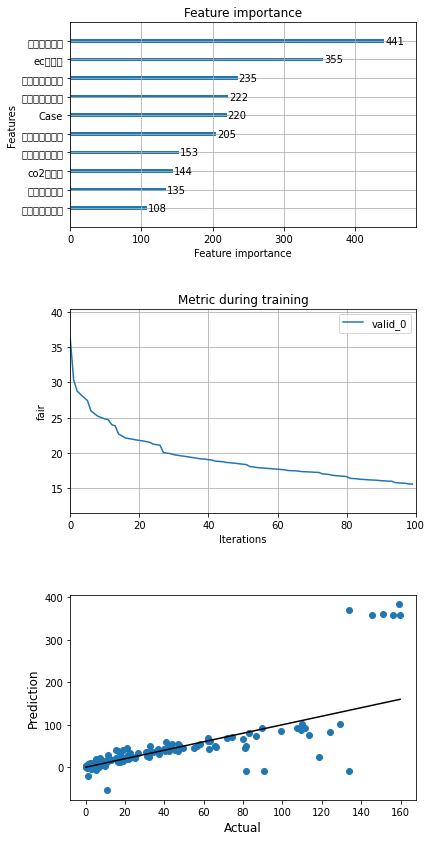

Features Importance Split & Gain...
    feature  split       gain
2   내부온도관측치    205  25.549958
7   시간당백색광량    153  16.516389
8   시간당적색광량    235  14.251440
5     ec관측치    355  14.075436
6    시간당분무량    441  12.134507
4    co2관측치    144   4.840277
1      Case    220   4.073667
3   내부습도관측치    222   3.790530
10   시간당총광량    135   2.319647
0       DAT    100   1.816200
9   시간당청색광량    108   0.631949
MAE: 97976792787120869959711763013940056230786912443786017878172788396093296647394054774207599994449220073662307924660525251504972837417674317669935021805886857080209408.000, MSE:    inf, RMSE:    inf


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


In [ ]:
import matplotlib.pyplot as plt
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


#max_bin = tuning_max_bin(train_x,train_y)
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train(train_x,train_y)

params = {'max_bin':2047, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [ ]:
#max_bin = tuning_max_bin()
max_bin = 2047
#train_x, train_y = load_train()
train_x = save_train
test_x = svae_test
RepNo = 5                                                                     # 품목 갯수


pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

predict['predicted_weight_g'] = pred_Y

test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = predict['predicted_weight_g'][i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.586217
1     2            1.532667
2     3            1.765668
3     4           -1.122647
4     5           -2.388947
5     6            9.591258
6     7            8.377445
7     8           -0.517700
8     9            4.380762
9    10            3.093411
10   11            7.440768
11   12           10.406772
12   13           16.544636
13   14           14.480500
14   15           20.400469
15   16           22.901854
16   17           32.242781
17   18           28.422598
18   19           30.067738
19   20           30.950042
20   21           35.943370
21   22           38.823700
22   23           50.233863
23   24           48.358921
24   25           68.006250
25   26          108.588201
26   27          118.523057
27   28          119.169410 0
    DAT  predicted_weight_g
0     1            1.549166
1     2            1.783523
2     3            1.412974
3     4            5.673309
4     5            8.827950
5     6           

# pycaret

In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 4.7 MB/s 
     |████████████████████████████████| 141 kB 74.6 MB/s 
     |████████████████████████████████| 1.7 MB 75.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8 MB 57.8 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 325 kB 77.4 MB/s 
     |████████████████████████████████| 5.0 MB 73.0 MB/s 
     |████████████████████████████████| 88 kB 8.2 MB/s 
     |████████████████████████████████| 1.3 MB 47.4 MB/s 
     |████████████████████████████████| 3.3 MB 68.7 MB/s 
     |████████████████████████████████| 662 kB 62.3 MB/s 
     |████████████████████████████████| 25.8 MB 2.7 MB/s 
     |████████████████████████████████| 2

In [ ]:
!pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.regression import *

In [ ]:
caret = pd.concat([train_x,train_y],axis = 1)

In [ ]:
setup(caret, target = 'predicted_weight_g', silent = True)

,Description,Value
0,session_id,7746
1,Target,predicted_weight_g
2,Original Data,"(784, 285)"
3,Missing Values,False
4,Numeric Features,283
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(548, 31)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='predicted_weight_g',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                nume...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

([('Setup Config',
                                  Description               Value
   0                               session_id                7746
   1                                   Target  predicted_weight_g
   2                            Original Data          (784, 285)
   3                           Missing Values               False
   4                         Numeric Features                 283
   5                     Categorical Features                   1
   6                         Ordinal Features               False
   7                High Cardinality Features               False
   8                  High Cardinality Method                None
   9                    Transformed Train Set           (548, 31)
   10                    Transformed Test Set           (236, 31)
   11                      Shuffle Train-Test                True
   12                     Stratify Train-Test               False
   13                          Fold Generator            

In [ ]:
bm = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.565100e+00,5.328580e+01,7.202300e+00,9.680000e-01,0.3292,4.519000e-01,0.272
lightgbm,Light Gradient Boosting Machine,5.823300e+00,9.381800e+01,9.474600e+00,9.447000e-01,0.3685,4.886000e-01,0.097
gbr,Gradient Boosting Regressor,6.260000e+00,1.014356e+02,9.924400e+00,9.392000e-01,0.3991,6.167000e-01,0.191
rf,Random Forest Regressor,6.474500e+00,1.137901e+02,1.048910e+01,9.319000e-01,0.3631,4.623000e-01,0.495
knn,K Neighbors Regressor,8.577900e+00,2.202895e+02,1.471960e+01,8.676000e-01,0.4804,6.620000e-01,0.012
dt,Decision Tree Regressor,8.093400e+00,2.351019e+02,1.501380e+01,8.525000e-01,0.4778,5.933000e-01,0.014
ridge,Ridge Regression,1.101680e+01,2.508789e+02,1.547670e+01,8.513000e-01,0.7194,1.968300e+00,0.009
ada,AdaBoost Regressor,1.414600e+01,2.768021e+02,1.656570e+01,8.337000e-01,1.0418,4.067700e+00,0.113
br,Bayesian Ridge,1.172380e+01,3.062195e+02,1.708320e+01,8.197000e-01,0.6888,1.785500e+00,0.010
lasso,Lasso Regression,1.205930e+01,3.245788e+02,1.751620e+01,8.111000e-01,0.7044,1.990800e+00,0.017


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 2
INFO:logs:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=7746, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
y_pred = predict_model(bm, test_x)
y_pred

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=7746, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,31_LPF,32_LPF,33_LPF,34_LPF,35_LPF,36_LPF,37_LPF,38_LPF,39_LPF,Label
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,6469.737331,6.972322e+03,3.916129e+04,1.036421e+05,1.397112e+05,1.225509e+05,8.903842e+04,6.469020e+04,4.700018e+04,1.662318
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,6856.454482,6.558109e+04,2.400900e+05,4.551325e+05,5.895620e+05,5.383766e+05,3.911535e+05,2.841897e+05,2.064759e+05,1.529403
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,9246.161347,1.917226e+05,6.387474e+05,1.123137e+06,1.437333e+06,1.320997e+06,9.597603e+05,6.973067e+05,5.066230e+05,2.856333
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,15905.875253,4.103413e+05,1.277409e+06,2.135115e+06,2.708277e+06,2.498173e+06,1.815029e+06,1.318696e+06,9.580885e+05,2.572758
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,14794.867894,7.096587e+05,2.105054e+06,3.354163e+06,4.209168e+06,3.896160e+06,2.830726e+06,2.056643e+06,1.494238e+06,3.178167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,105610.676546,7.760310e+05,1.986799e+06,2.954791e+06,3.653617e+06,3.424182e+06,2.567298e+06,1.949212e+06,1.498654e+06,59.143284
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,114854.494499,9.299059e+05,2.505445e+06,3.857250e+06,4.796682e+06,4.482012e+06,3.344794e+06,2.523019e+06,1.924476e+06,81.166218
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,123701.780726,1.205483e+06,3.249090e+06,4.949608e+06,6.140159e+06,5.736036e+06,4.264829e+06,3.200408e+06,2.425570e+06,78.370912
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,131999.710591,1.490920e+06,4.031110e+06,6.112800e+06,7.574464e+06,7.073427e+06,5.245446e+06,3.921813e+06,2.958646e+06,86.360142


In [ ]:
test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred['Label'][i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.662318
1     2            1.529403
2     3            2.856333
3     4            2.572758
4     5            3.178167
5     6            2.853431
6     7            4.846604
7     8            6.607011
8     9            8.506381
9    10            9.945400
10   11           11.547756
11   12           13.120465
12   13           16.518163
13   14           15.343259
14   15           25.658244
15   16           34.643139
16   17           42.051870
17   18           44.772611
18   19           53.782223
19   20           65.056130
20   21           73.961135
21   22           88.615942
22   23           96.992909
23   24           96.767346
24   25          103.679384
25   26          109.822115
26   27          113.116003
27   28          112.301899 0
    DAT  predicted_weight_g
0     1            1.734149
1     2            1.697654
2     3            2.508163
3     4            3.103280
4     5            3.110655
5     6           

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
#import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import warnings
import gc
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

In [ ]:
X

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대,측정될수분량2,측정될수분량1,측정될수분량3
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,...,0,0,0,0,0,0,2,0.0,0.0,0.0
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.0
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.0
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,3,0.0,0.0,0.0


In [ ]:
model = ExtraTreesRegressor(bootstrap=True, oob_score=True, warm_start=True, random_state=42, verbose=0)
model.fit(train_x, train_y)

ExtraTreesRegressor(bootstrap=True, oob_score=True, random_state=42,
                    warm_start=True)

In [ ]:
y_pred = model.predict(test_x)
y_pred

array([ 1.32714924,  1.93063041,  2.01365082,  1.89413641,  3.2416398 ,
        3.15698936,  4.58434635,  4.92662477,  6.64715589,  7.77923821,
        9.80512835, 11.96496066, 13.77703143, 15.32071092, 19.8384653 ,
       23.49712074, 26.23955574, 30.67313113, 37.33788617, 46.952378  ,
       55.08185632, 64.08300188, 68.95325955, 76.25060528, 88.34643281,
       91.9709107 , 98.5088374 , 99.31401645,  1.40760467,  2.21692444,
        1.60364851,  1.75645825,  2.50749563,  2.86400858,  3.27127802,
        3.8186682 ,  4.06128306,  4.93710305,  5.4407149 ,  6.75046541,
        7.99179939,  9.551948  , 11.26212958, 12.5056303 , 15.61061986,
       18.92395359, 21.8450105 , 24.2389591 , 27.53960603, 31.13085967,
       38.77888674, 49.28925058, 56.54329542, 63.64382147, 65.93054391,
       65.51740521,  1.63014939,  1.74818322,  1.60619519,  1.73025097,
        1.99352729,  2.19580756,  2.69984947,  3.25685051,  3.29905524,
        4.11344004,  4.64879712,  5.40408465,  6.14330205,  7.40

In [ ]:
test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred[i*28:i*28+28]
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.327149
1     2            1.930630
2     3            2.013651
3     4            1.894136
4     5            3.241640
5     6            3.156989
6     7            4.584346
7     8            4.926625
8     9            6.647156
9    10            7.779238
10   11            9.805128
11   12           11.964961
12   13           13.777031
13   14           15.320711
14   15           19.838465
15   16           23.497121
16   17           26.239556
17   18           30.673131
18   19           37.337886
19   20           46.952378
20   21           55.081856
21   22           64.083002
22   23           68.953260
23   24           76.250605
24   25           88.346433
25   26           91.970911
26   27           98.508837
27   28           99.314016 0
    DAT  predicted_weight_g
0     1            1.407605
1     2            2.216924
2     3            1.603649
3     4            1.756458
4     5            2.507496
5     6           

In [ ]:
maes = []
X = train[train.columns]
X.drop(columns=['predicted_weight_g'], inplace=True)
y = train['predicted_weight_g']

test = test[X.columns]

pred = np.zeros((test.shape[0]))
for i, idx in enumerate(kf.split(X, y)) :
    tr_x, tr_y = X.loc[idx[0]], y.loc[idx[0]]
    val_x, val_y = X.loc[idx[1]], y.loc[idx[1]]


    model = ExtraTreesRegressor(bootstrap=True, oob_score=True, warm_start=True, random_state=42, verbose=0)
    model.fit(tr_x, tr_y)
    
    val_pred = model.predict(val_x)
    mae = NMAE(val_y, val_pred)
    print(f"{i + 1} Fold MAE = {mae}")
    maes.append(mae)
    
    fold_pred = model.predict(test) / kf.n_splits
    pred += fold_pred

KeyError: ignored